In [171]:

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src import utility as utils

In [172]:
%pip install pyxlsb
%load_ext pyxlsb

Note: you may need to restart the kernel to use updated packages.
The pyxlsb module is not an IPython extension.


In [173]:
import warnings

warnings.filterwarnings('ignore')

In [174]:
file_names = [x for x in os.listdir() if ".xlsb" in x]
data_dict = {
    "2016": "CMI TA DB 2016 Datasheet v02 2024-06-17.xlsb",
    "2017": "CMI TA DB 2017 Datasheet v02 2024-06-17.xlsb",
    "2018": "CMI TA DB 2018 Datasheet v01 2022-05-20.xlsb",
    "2019": "CMI TA DB 2019 Datasheet v01 2022-05-20.xlsb",
    "2020": "CMI TA DB 2020 Datasheet v01 2022-05-20.xlsb",
}

In [175]:
df = utils.compile_data(
    data_dict,
    r'C:\Documents\Python\src',
)

2535449


In [176]:
df.columns

Index(['ProductCategory', 'Gender', 'SmokerStatus', 'DistributionChannel',
       'CommencementYear', 'JointLifeStatus', 'SumAssuredBand', 'Age',
       'Duration', 'LivesExposure', 'AmountsExposure', 'IncurredClaims',
       'AmountIncurred', 'ExpectedClaims', 'ExpectedAmountClaims',
       'ComparatorTable', 'CalendarYear', 'unique_id', 'holdout',
       'random_fold'],
      dtype='object')

In [177]:
combined_df = df.drop(["ComparatorTable", "unique_id"], axis=1)  # "CalendarYear",

In [178]:
combined_df["LivesExposure"] = combined_df["LivesExposure"].replace(0, 1/365)

In [179]:
combined_df["Actual_deaths"] = (
    combined_df["AmountIncurred"] / combined_df["AmountsExposure"]
)
combined_df["Actual_deaths_lives"] = (
    combined_df["IncurredClaims"] / combined_df["LivesExposure"]
)
combined_df["Expected_deaths"] = (
    combined_df["ExpectedAmountClaims"] / combined_df["AmountsExposure"]
)
combined_df["Expected_deaths_lives"] = (
    combined_df["ExpectedClaims"] / combined_df["LivesExposure"]
)

In [180]:
combined_df = combined_df[
    combined_df["LivesExposure"] != 0
]  # may be has claims can set 1/365
# combined_df.drop("ComparatorTable", axis=1, inplace=True)

In [181]:
combined_df["CommencementYear"].unique()

array(['2001', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '1999 or earlier', '2000', '2002', '2017', '2018', '2019', '2020'],
      dtype=object)

In [182]:
def CommencementYear_change(CommencementYear):
    if CommencementYear == "1999 or earlier":
        new_cy = 1
    else:
        new_cy = max(int(CommencementYear) - 1999 + 1, 0)
    return new_cy

In [183]:
def CalYear_change(CalendarYear):
    if CalendarYear == "1999 or earlier":
        new_cy = 1
    else:
        new_cy = max(int(CalendarYear) - 2016 + 1, 0)
    return new_cy

In [184]:
combined_df["CommencementYear"] = combined_df["CommencementYear"].apply(
    CommencementYear_change
)

In [185]:
combined_df["CalendarYear"] = combined_df["CalendarYear"].apply(CalYear_change)

In [186]:
def Duration_change(Duration):
    if Duration == "10+":
        dur = 10
    else:
        dur = max(int(Duration), 0)
    return dur

In [187]:
combined_df["Duration"] = combined_df["Duration"].apply(Duration_change)

In [188]:
grouped_df = combined_df.groupby(
    [
        "ProductCategory",
        "Gender",
        "SmokerStatus",
        "DistributionChannel",
        "CommencementYear",
        "JointLifeStatus",
        "SumAssuredBand",
        "Age",
        "Duration",
    ]
).mean()
grouped_df = grouped_df.reset_index()

In [189]:
# combined_df=grouped_df
combined_df.drop(
    [
        "AmountsExposure",  #'IncurredClaims',
        "AmountIncurred",
       # "ExpectedClaims",
        "ExpectedAmountClaims",  # 'ComparatorTable'
    ],
    axis=1,
    inplace=True,
)

In [190]:
combined_df = combined_df[combined_df["Actual_deaths_lives"] <= 1]

In [191]:
data = (
    combined_df.copy()
    .drop(
        [
           # "Expected_deaths",
            "Actual_deaths",
            "Expected_deaths_lives",
        ],  # "LivesExposure"],
        axis=1,
    )
    .copy()
)

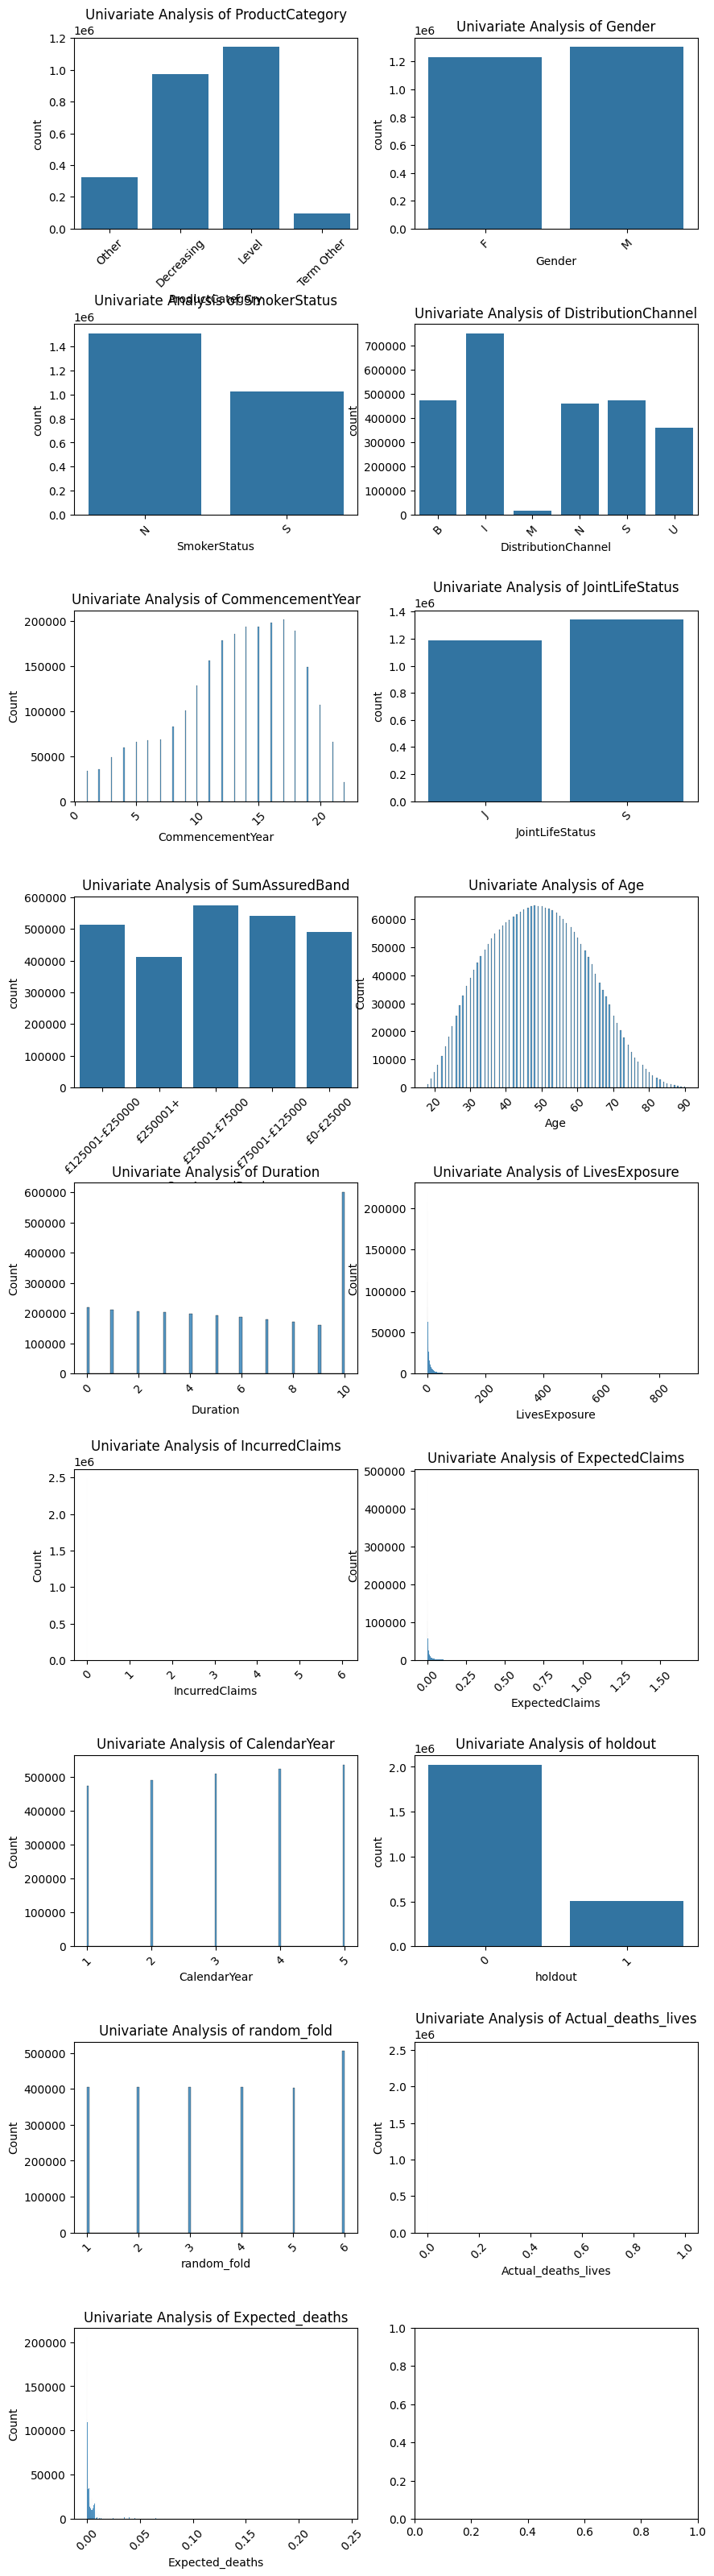

In [192]:
# Univariate plots

no_col = len(data.columns)
fig, axes = plt.subplots(nrows=(no_col // 2 + 1), ncols=2, figsize=(10, 40))
for i, column in enumerate(data.columns):
    if len(data[column].unique()) > 3 and pd.api.types.is_numeric_dtype(data[column]):
        ax = sns.histplot(data[column], ax=axes[i // 2, i % 2])
    else:
        ax = sns.countplot(x=column, data=data, ax=axes[i // 2, i % 2])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    axes[i // 2, i % 2].set_title(f"Univariate Analysis of {column}")
    plt.subplots_adjust(hspace=0.5)

plt.show()

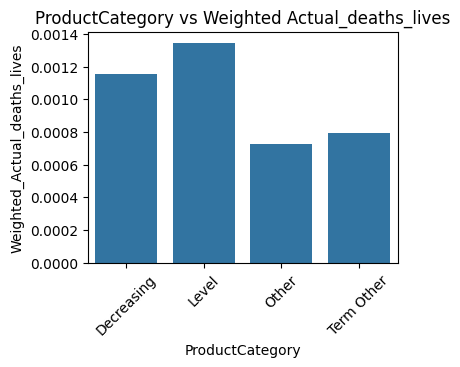

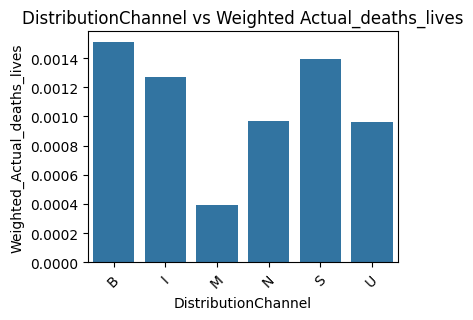

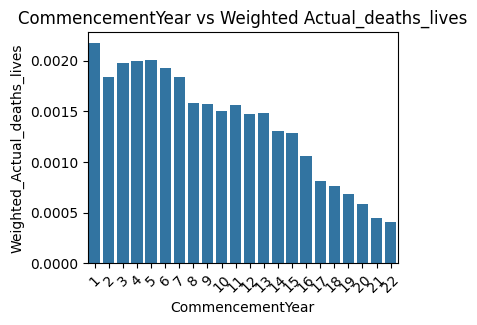

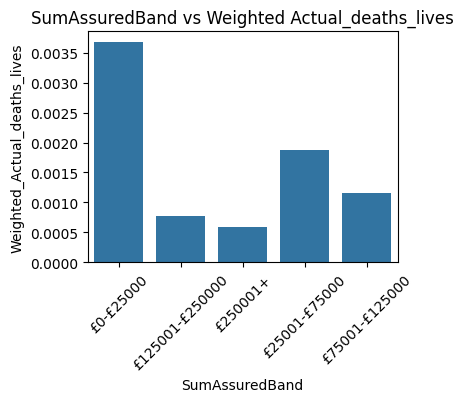

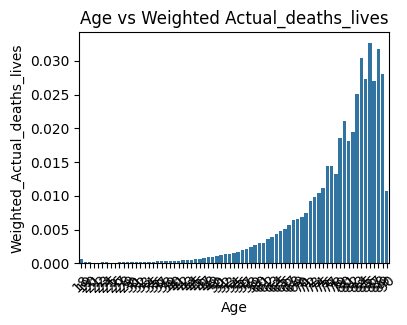

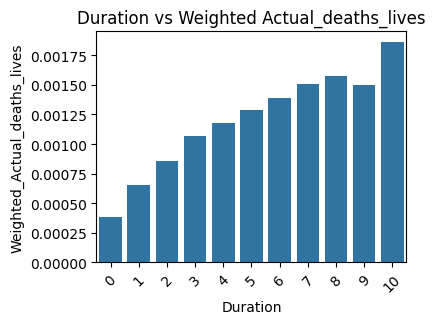

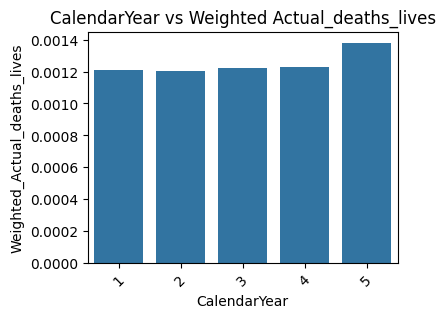

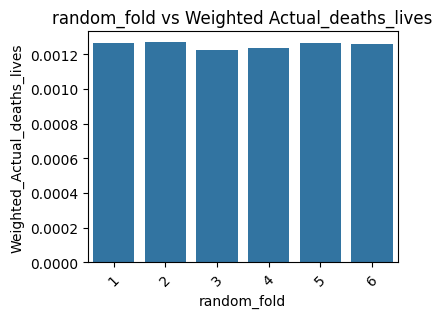

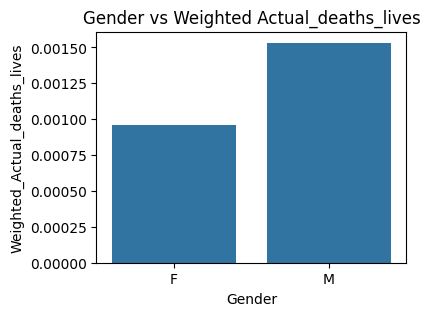

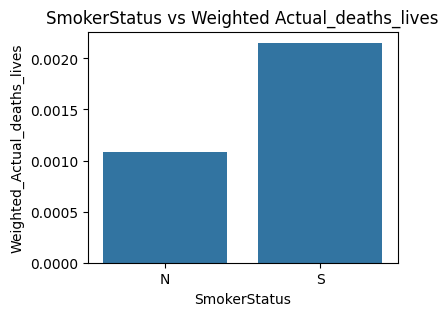

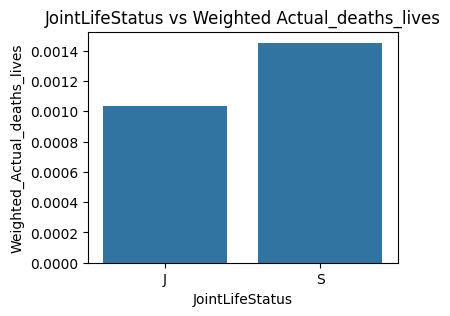

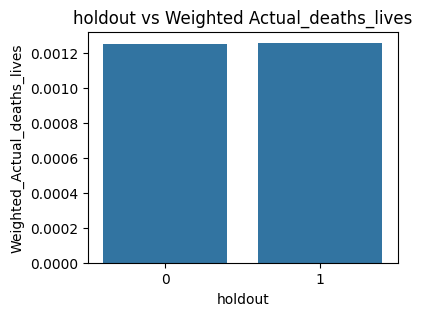

In [193]:
no_col = len(data.columns)
continuous_vars = []
categorical_vars = []
Target = "Actual_deaths_lives"
# data = data[data["Actual_deaths_lives"] <= 1]

for i, column in enumerate(data.drop([Target, "IncurredClaims","Expected_deaths","ExpectedClaims"], axis=1).columns):
    if column == "LivesExposure":
        pass
    else:

        if len(data[column].unique()) > 3:
            continuous_vars.append(column)
        else:
            categorical_vars.append(column)


# Function to calculate weighted mean
def weighted_mean(df, value, weight):
    return (df[value] * df[weight]).sum() / df[weight].sum()


# Scatter plots for continuous variables vs target
for var in continuous_vars:
    plt.figure(figsize=(4, 3))
    weighted_data = (
        data[[var, Target, "LivesExposure"]]
        .groupby(var)
        .apply(lambda x: weighted_mean(x, Target, "LivesExposure"))
        .reset_index(name=f"Weighted_{Target}")
    )
    ax = sns.barplot(x=var, y=f"Weighted_{Target}", data=weighted_data)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.title(f"{var} vs Weighted {Target}")
    plt.show()

# Bar plots for categorical variables vs target
for var in categorical_vars:
    plt.figure(figsize=(4, 3))
    weighted_data = (
        data[[var, Target, "LivesExposure"]]
        .groupby(var)
        .apply(lambda x: weighted_mean(x, Target, "LivesExposure"))
        .reset_index(name=f"Weighted_{Target}")
    )
    ax = sns.barplot(x=var, y=f"Weighted_{Target}", data=weighted_data)
    plt.title(f"{var} vs Weighted {Target}")
    plt.show()

plt.show()

In [194]:
import warnings

warnings.filterwarnings('ignore')

In [195]:
df_filtered = combined_df.drop(columns=["random_fold", "holdout"])

combined_df_encoded = pd.get_dummies(df_filtered, drop_first=True)

# Add the dropped columns back
combined_df_encoded["random_fold"] = combined_df["random_fold"]
combined_df_encoded["holdout"] = combined_df["holdout"]

In [196]:
combined_df_encoded = combined_df_encoded.apply(
    lambda x: x.astype(int) if x.dtypes == "bool" else x
)
combined_df_encoded.drop(
    ["Actual_deaths", #"Expected_deaths", "Expected_deaths_lives"
    ], axis=1, inplace=True
)

In [244]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# borrow the age transformations from the poisson neural net
# best_trial_params= {'lr': 0.16499400906958195, 'weight_decay': 7.771609386937672e-06, 'num_epochs': 707, 'lambda_l1': 0.012188947951286626, 'age_cut': 56, 'age_power': 3.5300139707482083, 'age_multiplier': 1, 'duration_power': -0.7700043460802583, 'duration_multiplier': 1, 'saturated_r2': 0.2776065468788147}
Best_trial_params={'lr': 0.39309010504152047, 'weight_decay': 1.5388238537764884e-05, 'num_epochs': 1063, 'lambda_l1': 2.618893820326042e-05, 'age_cut': 46, 'age_power': 2.221662081276728, 'age_multiplier': 0, 'duration_power': -1.804987497713285, 'duration_multiplier': 1}
Best_trial_params={'lr': 0.39309010504152047, 'weight_decay': 1.5388238537764884e-05, 'num_epochs': 1063, 'lambda_l1': 2.618893820326042e-05,'age_cut': 90, 'age_power': 4.869437275966766, 'age_multiplier': 0, 'duration_power': -0.6924619719911574, 'duration_multiplier': 1}
other_best_params = {'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001,'age_cut': 49, 'age_power': 3.538752691168995, 'age_multiplier': 1, 'duration_power': -1.2541909443550256, 'duration_multiplier': 1, 'saturated_r2': 0.2516699433326721}
#other_best_params=Best_trial_params
age_cut = other_best_params["age_cut"]  # 50
age_power = other_best_params["age_power"]  # 4.133448889716881  #
age_multiplier = other_best_params["age_multiplier"]
duration_multiplier = other_best_params["duration_multiplier"]
duration_power = other_best_params["duration_power"]
df = combined_df_encoded.drop("Actual_deaths_lives", axis=1).copy()
df["LivesExposure"] = df["LivesExposure"].clip(
    lower=1e-6
)  # Ensure no zero or negative values
df["Age2"] = age_multiplier * np.maximum(df["Age"] - age_cut, 0) ** age_power
df['dur2'] = duration_multiplier * ((df['Duration'] +1) ** duration_power)

# Split data based on holdout column
train_df = df[df["holdout"] == 0]
test_df = df[df["holdout"] == 1]
#add 


X_train = train_df.drop(
    ["IncurredClaims", 
        "Expected_deaths_lives",    
        "ExpectedClaims",
        "Expected_deaths", "LivesExposure", "holdout", "random_fold"], axis=1
)
y_train = train_df["IncurredClaims"]
X_test = test_df.drop(
    ["IncurredClaims", 
        "Expected_deaths_lives",    
        "ExpectedClaims",
        "Expected_deaths","LivesExposure", "holdout", "random_fold"], axis=1
)
y_test = test_df["IncurredClaims"]

# Add a constant term for the intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Replace inf with nan, then fill or drop
#X_train = X_train.replace([np.inf, -np.inf], np.nan)
#X_test = X_test.replace([np.inf, -np.inf], np.nan)
#X_train = X_train.fillna(0)
#X_test = X_test.fillna(0)

# Fit the Poisson regression model with LivesExposure as an offset
poisson_model_glm = sm.GLM(
    y_train,
    X_train,
    family=sm.families.Poisson(),
    offset=np.log(train_df["LivesExposure"]),
).fit()

# Print the summary of the model
print(poisson_model_glm.summary())

# Predict on the test set
y_pred_glm = poisson_model_glm.predict(X_test, offset=np.log(test_df["LivesExposure"]))



                 Generalized Linear Model Regression Results                  
Dep. Variable:         IncurredClaims   No. Observations:              2026643
Model:                            GLM   Df Residuals:                  2026621
Model Family:                 Poisson   Df Model:                           21
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3213e+05
Date:                Fri, 24 Oct 2025   Deviance:                   1.9577e+05
Time:                        14:23:59   Pearson chi2:                 1.66e+06
No. Iterations:                     8   Pseudo R-squ. (CS):            0.02107
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [245]:
# Remove features with high p-values from the Poisson GLM model
# Threshold for p-value (commonly 0.05 or 0.1)
pval_threshold = 0.005

# Get features with p-value above the threshold (excluding the intercept)
high_pval_features = poisson_model_glm.pvalues[poisson_model_glm.pvalues > pval_threshold].index
high_pval_features = [f for f in high_pval_features if f != "const"]
#high_pval_features.remove('Age2')
print("Features to remove due to high p-values:", high_pval_features)

# Drop these features from X_train and X_test
X_train_reduced = X_train.drop(columns=high_pval_features)
X_test_reduced = X_test.drop(columns=high_pval_features)

# Refit the Poisson GLM with reduced features
X_train_reduced = sm.add_constant(X_train_reduced)
X_test_reduced = sm.add_constant(X_test_reduced)
poisson_model_glm_reduced = sm.GLM(
    y_train,
    X_train_reduced,
    family=sm.families.Poisson(),
    offset=np.log(train_df["LivesExposure"]),
).fit()

print(poisson_model_glm_reduced.summary())

Features to remove due to high p-values: ['CommencementYear', 'CalendarYear', 'ProductCategory_Level', 'DistributionChannel_I', 'DistributionChannel_M', 'DistributionChannel_S', 'Age2']
                 Generalized Linear Model Regression Results                  
Dep. Variable:         IncurredClaims   No. Observations:              2026643
Model:                            GLM   Df Residuals:                  2026628
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3214e+05
Date:                Fri, 24 Oct 2025   Deviance:                   1.9578e+05
Time:                        14:24:10   Pearson chi2:                 1.64e+06
No. Iterations:                     8   Pseudo R-squ. (CS):            0.02106
Covariance Type:            nonrobust                                         
                        

In [246]:
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedPoisson
import numpy as np


# Fit Poisson regression with offset
poisson_model_glm = sm.GLM(
    y_train,
    X_train_reduced,
    family=sm.families.Poisson(),
    offset=np.log(train_df["LivesExposure"])
).fit()

# Fit Zero-Inflated Poisson model with offset
zip_model = ZeroInflatedPoisson(
    endog=y_train,
    exog=X_train_reduced,
    exog_infl=X_train_reduced,
    offset=np.log(train_df["LivesExposure"])
).fit(method='bfgs', maxiter=300, disp=0)





In [248]:
import math
# Get predicted values from Poisson GLM
poisson_pred_test = poisson_model_glm.predict(X_test_reduced, offset=np.log(test_df["LivesExposure"]))
weights = test_df["LivesExposure"].values
# Avoid zeros for log calculation
observed = y_test.values #+ 1e-25
predicted = poisson_pred_test.values 

# Weighted mean target (using exposure)
weighted_mean_target = np.sum(observed) / np.sum(weights) 

predicted_null = weights*weighted_mean_target

# Poisson log-likelihood (weighted by exposure)
log_likelihood = np.sum(
    weights * (observed * np.log(predicted) - predicted - np.log(np.maximum(1, np.array([math.factorial(int(y)) for y in observed]))))
)

# Number of parameters in the GLM model
num_params = len(poisson_model_glm.params)

# AIC calculation: AIC = 2k - 2ln(L)
aic_glm = 2 * num_params - 2 * log_likelihood

print(f"Poisson GLM AIC: {aic_glm:.2f}")

null_deviance = 2 * np.sum(
     weights*(observed* np.log((observed + 1e-25) / predicted_null)
    - (observed - predicted_null))
)
model_deviance = 2 * np.sum(
     weights*(observed * np.log((observed + 1e-25)/ predicted) - ((observed + 1e-25) - predicted))
)
poisson_deviance = null_deviance - model_deviance
#print( f"model deviance: {poisson_deviance}  weighted psuedo R2 ={ 1- model_deviance/null_deviance}")
# Calculate AIC for Zero-Inflated Poisson (ZIP) model on the test set
zip_pred_test = zip_model.predict(X_test_reduced, exog_infl=X_test_reduced, offset=np.log(test_df["LivesExposure"]))
# Clip predictions to avoid log(0)
zip_pred_test = np.clip(zip_pred_test, 1e-100, None)
log_likelihood_zip = np.sum(
    weights * (
        observed * np.log(zip_pred_test)
        - zip_pred_test
        - np.log(np.maximum(1, np.array([math.factorial(int(y)) for y in observed])))
    )
)
num_params_zip = len(zip_model.params)
aic_zip = 2 * num_params_zip - 2 * log_likelihood_zip
print(f"ZIP model AIC (manual): {aic_zip:.2f}")

Poisson GLM AIC: 3875001.09
ZIP model AIC (manual): 3874946.17


### Poisson distribution modelling

Input Layer
    |
    v
+---------------------+
| Original Features   |
+---------------------+
    |
    v
+---------------------+
| Interaction Terms   |
| (age, duration*,    |
|  calendar_year*)|
+---------------------+
    |
    v
+---------------------+
| Concatenation Layer |
+---------------------+
    |
    v
+---------------------+
| Fully Connected     |
| Layer               |
+---------------------+
    |
    v
+---------------------+
| Exp transform       |
+---------------------+
    |
    v
Output Layer


In [32]:
%pip install torch 
#-i https://pypi.org/simple

Note: you may need to restart the kernel to use updated packages.


In [249]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np


# combined_df_encoded = combined_df_encoded.drop("CommencementYear", axis=1)
df = combined_df_encoded.copy()
df['Duration']=df['Duration']+1
override = 1
if override == 1:
    #Best_trial_params = {'lr': 0.28673380833639397, 'weight_decay': 2.4526185176068275e-05, 'num_epochs': 1087, 'lambda_l1': 4.432372037338933e-05, 'age_cut': 35, 'age_power': 3.6003821546773658, 'age_multiplier': 1, 'duration_power': -0.4408474979805285, 'duration_multiplier': 1}
    #Best_trial_params = {'lr': 0.18673380833639397, 'weight_decay': 2.4526185176068275e-05, 'num_epochs': 1087, 'lambda_l1': 4.432372037338933e-05, 'age_cut': 62, 'age_power': 3.6003821546773658, 'age_multiplier': 1, 'duration_power': -0.4408474979805285, 'duration_multiplier': 1}
    Best_trial_params={'lr': 0.39309010504152047, 'weight_decay': 1.5388238537764884e-05, 'num_epochs': 1063, 'lambda_l1': 2.618893820326042e-05, 'age_cut': 46, 'age_power': 2.221662081276728, 'age_multiplier': 0, 'duration_power': -1.804987497713285, 'duration_multiplier': 1}
    Best_trial_params={'lr': 0.39309010504152047, 'weight_decay': 1.5388238537764884e-05, 'num_epochs': 1063, 'lambda_l1': 2.618893820326042e-05,'age_cut': 90, 'age_power': 4.869437275966766, 'age_multiplier': 0, 'duration_power': -0.6924619719911574, 'duration_multiplier': 1}
    lr = Best_trial_params["lr"]
    weight_decay = Best_trial_params["weight_decay"]
    num_epochs = Best_trial_params["num_epochs"]
    lambda_l1 = Best_trial_params["lambda_l1"]
    age_cut = Best_trial_params["age_cut"]
    age_power = Best_trial_params["age_power"]
    age_multiplier = Best_trial_params["age_multiplier"]
    duration_power = Best_trial_params["duration_power"]
    duration_multiplier = Best_trial_params["duration_multiplier"]
else:
    try:
        age_cut = study.best_params["age_cut"]  # 50
        age_power = study.best_params["age_power"]  # - 2  # 4.133448889716881  #
        weight_decay = study.best_params["weight_decay"]  # 1.0441166112064366e-05
        num_epochs = study.best_params["num_epochs"]  # 680
        lambda_l1 = study.best_params["lambda_l1"]
        lr = study.best_params["lr"]
        age_multiplier = study.best_params["age_multiplier"]
        print(f"read best params{study.best_params}")
    except:
        age_cut = 35  # study.best_params["age_cut"]  # 50
        age_power = 1.3  # study.best_params["age_power"]  # 4.133448889716881  #
        weight_decay = (
            0.0002  # study.best_params["weight_decay"]  # 1.0441166112064366e-05
        )
        num_epochs = 650  # study.best_params["num_epochs"]  # 680
        lambda_l1 = 0.00005  # study.best_params["lambda_l1"]
        lr = 0.1  # study.best_params["lr"]
        print("read other params")


df["Age2"] = (
    age_multiplier * np.maximum( df["Age"] - age_cut  , 0) ** age_power
)  # np.exp(df['Age'])

df["Dur2"] = (
    duration_multiplier * np.maximum(df["Duration"] , 0) ** duration_power
)
df["LivesExposure"] = df["LivesExposure"].clip(
    lower=1e-6
)  # Ensure no zero or negative values;w we did filter out few cases earlier
train_df = df[df["holdout"] == 0]
test_df = df[df["holdout"] == 1]
train_lives_exposure = train_df["LivesExposure"]
test_lives_exposure = test_df["LivesExposure"]
X_train = train_df.drop(
    [
        "IncurredClaims",
        "LivesExposure",
        "Actual_deaths_lives",
        "Expected_deaths_lives",
        "ExpectedClaims",
        "Expected_deaths",
        "holdout",
        "random_fold",
        "CommencementYear",
    ],
    axis=1,
)
y_train = train_df["IncurredClaims"]
X_test = test_df.drop(
    [
        "IncurredClaims",
        "LivesExposure",
        "Actual_deaths_lives",
        "Expected_deaths_lives",    
        "ExpectedClaims",
        "Expected_deaths",
        "holdout",
        "random_fold",
        "CommencementYear",
    ],
    axis=1,
)
y_test = test_df["IncurredClaims"]
age_test_tensor = torch.tensor(X_test["Age"].values, dtype=torch.float32)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

# Convert LivesExposure to tensors
lives_exposure_train_tensor = torch.tensor(
    train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
)
lives_exposure_test_tensor = torch.tensor(
    test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
)


# NN with custom interaction layer and offset
class Mort_Net(nn.Module):
    def __init__(self):
        super(Mort_Net, self).__init__()

        # Identify the indices of the specific columns
        self.age_idx = X_train_scaled.columns.get_loc("Age")
        self.duration_indices = [
            i
            for i, col in enumerate(X_train_scaled.columns)
            if col.startswith("Duration")
        ]
        self.commencement_year_indices = [
            i
            for i, col in enumerate(X_train_scaled.columns)
            if col.startswith("CalendarYear")
        ]
        # Define the fully connected layer
        interaction_input_size = len(self.duration_indices) + len(
            self.commencement_year_indices
        )
        self.fc2 = nn.Linear(
            len(X_train_scaled.columns) + interaction_input_size, 1
        )  # Include original features and interaction terms

    def forward(self, x, exposure):
        # Create interaction terms
        age_feature = x[:, self.age_idx].unsqueeze(1)
        interaction_terms = []  # torch.tensor(data=[], dtype=torch.float32)
        for idx in (
            self.duration_indices + self.commencement_year_indices  # + [self.age_idx]
        ):
            interaction_term = age_feature * x[:, idx].unsqueeze(1)
            interaction_terms.append(interaction_term)
            # print(interaction_term)

            # interaction_terms= torch.tensor(data=[], dtype=torch.float32)
            interaction_terms1 = torch.cat(interaction_terms, dim=1)
        # Concatenate the original features with interaction terms

        x_combined = torch.cat((x, interaction_terms1), dim=1)
        # print(f"x shape: {x.shape}")
        # print(f"interaction_terms1 shape: {interaction_terms1.shape}")
        # print(f"x_combined shape: {x_combined.shape}")

        # Final fully connected layer
        linear_output = self.fc2(x_combined)

        # Adding the log of the exposure as an offset
        offset_output = linear_output + torch.log(exposure)

        # Apply exponential activation for the poisson
        output = torch.exp(offset_output)

        return output


model = Mort_Net()
criterion = nn.PoissonNLLLoss(log_input=False)  # nn.MSELoss()#
optimizer = optim.Adam(
    model.parameters(), lr=lr, weight_decay=weight_decay
)  # Lower learning rate; weight decay acts to mimimise large weights like L2 regularisation


def l1_loss(model, lambda_l1):
    l1 = 0
    for param in model.parameters():
        l1 += torch.sum(torch.abs(param))
    return lambda_l1 * l1


for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor, lives_exposure_train_tensor)
    loss = criterion(outputs, y_train_tensor)  # + l1_loss(model, lambda_l1=0.00008)
    if torch.isnan(loss):
        print(f"Epoch {epoch+1}, Loss: NaN detected")
        break
    l1_reg = l1_loss(model, lambda_l1=lambda_l1)
    total_loss = loss + l1_reg
    total_loss.backward()
    optimizer.step()
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor, lives_exposure_test_tensor)
    loss = criterion(outputs, y_test_tensor)
    print(f"Test Loss: {loss.item()}")

y_test_tensor = y_test_tensor #+ 1e-25
avg=torch.sum(y_test_tensor) / torch.sum(lives_exposure_test_tensor)  
mean_target = avg* lives_exposure_test_tensor
null_deviance = 2 * torch.sum(
    lives_exposure_test_tensor*(y_test_tensor * torch.log((y_test_tensor + 1e-25) / mean_target)
    - (y_test_tensor - mean_target))
)
model_deviance = 2 * torch.sum(
    lives_exposure_test_tensor*(y_test_tensor * torch.log((y_test_tensor + 1e-25)/ outputs) - ((y_test_tensor + 1e-25) - outputs))
)
poisson_deviance = null_deviance - model_deviance
print(
    f"psuedo R2 ={ 1- model_deviance/null_deviance}"
)
y_pred = outputs.numpy().flatten()

Epoch 20, Loss: 0.24981428682804108
Epoch 40, Loss: 0.11386746913194656
Epoch 60, Loss: 0.09409811347723007
Epoch 80, Loss: 0.0865551307797432
Epoch 100, Loss: 0.08202949911355972
Epoch 120, Loss: 0.07881056517362595
Epoch 140, Loss: 0.07641863077878952
Epoch 160, Loss: 0.07460226118564606
Epoch 180, Loss: 0.07318520545959473
Epoch 200, Loss: 0.07204227894544601
Epoch 220, Loss: 0.07109080255031586
Epoch 240, Loss: 0.07027997821569443
Epoch 260, Loss: 0.06957906484603882
Epoch 280, Loss: 0.06896820664405823
Epoch 300, Loss: 0.06843329221010208
Epoch 320, Loss: 0.06796330213546753
Epoch 340, Loss: 0.06754923611879349
Epoch 360, Loss: 0.06718354672193527
Epoch 380, Loss: 0.0668599009513855
Epoch 400, Loss: 0.06657286733388901
Epoch 420, Loss: 0.06631775200366974
Epoch 440, Loss: 0.06609060615301132
Epoch 460, Loss: 0.06588806957006454
Epoch 480, Loss: 0.06570721417665482
Epoch 500, Loss: 0.06554552167654037
Epoch 520, Loss: 0.06540080159902573
Epoch 540, Loss: 0.06527115404605865
Epoch 5

In [250]:
y_test_tensor = y_test_tensor #+ 1e-25
mean_target = torch.sum(y_test_tensor) / torch.sum(lives_exposure_test_tensor)  
predicted_null= lives_exposure_test_tensor*mean_target
null_deviance = 2 * torch.sum(
    lives_exposure_test_tensor*((y_test_tensor * torch.log((y_test_tensor + 1e-25) / predicted_null)
    - (y_test_tensor - predicted_null)))
)
model_deviance = 2 * torch.sum(
    lives_exposure_test_tensor*(y_test_tensor * torch.log((y_test_tensor + 1e-25)/ outputs) - ((y_test_tensor + 1e-25) - outputs))
)

poisson_deviance = null_deviance - model_deviance
print(
    f"psuedo R2 ={ 1- model_deviance/null_deviance}"
)
y_pred = outputs.numpy().flatten()

psuedo R2 =0.23907530307769775


In [80]:
test_df["Predicted_Claims"] = y_pred
filtered_combined_df = test_df  # combined_df.loc[combined_df.index.isin(test_df.index)]
# filtered_combined_df = filtered_combined_df.assign(
#    Predicted_Claims=test_df["Predicted_Claims"].values
# )
filtered_combined_df["Predicted_Claims_rate"] = (
    filtered_combined_df["Predicted_Claims"] / filtered_combined_df["LivesExposure"]
)

In [81]:
filtered_combined_df["Predicted_Claims_rate"] = (
    filtered_combined_df["Predicted_Claims"] / filtered_combined_df["LivesExposure"]
)

##### plot of high level trends for predicted  followed by partial dependence plots( to be developed)

Text(0, 0.5, 'Frequency (Count)')

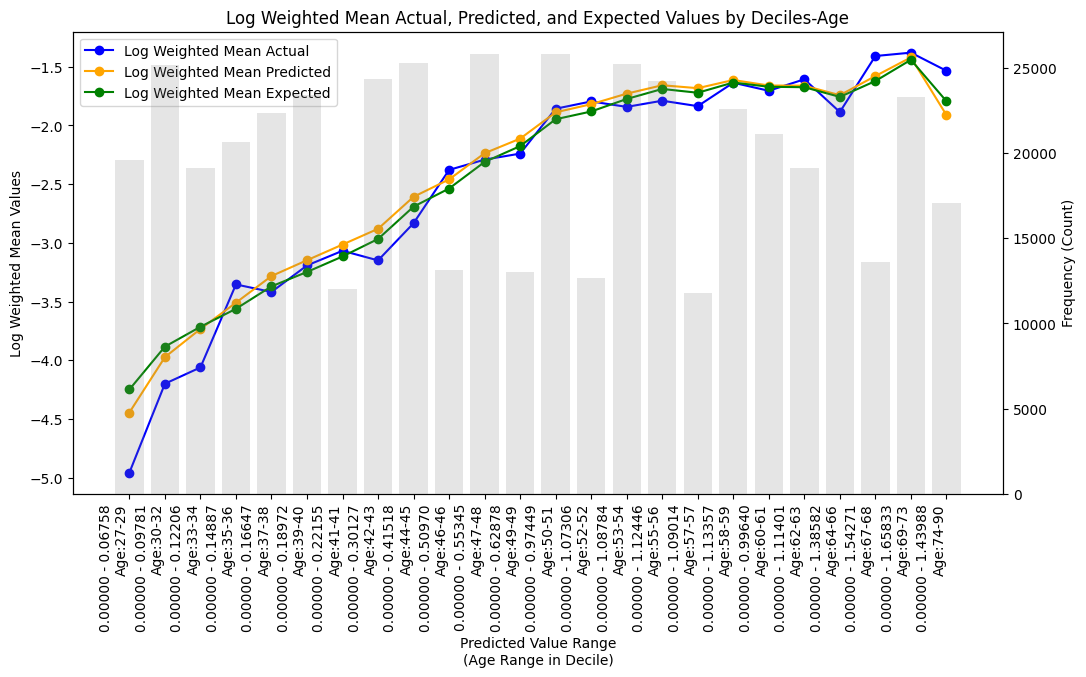

In [82]:
#y_test_tensor = torch.maximum(y_test_tensor, torch.tensor(1e-10))
actual = y_test_tensor.numpy().flatten()
predicted = np.round(y_pred, 10)
weights2 = lives_exposure_test_tensor.numpy().flatten()

# Add ExpectedClaims from test_df
expected_claims = test_df["ExpectedClaims"].values.flatten()

# Create a DataFrame for lift analysis
df_lift = pd.DataFrame({
    "actual": actual,
    "predicted": predicted,
    "Age": test_df["Age"].values.flatten(),
    "expected": expected_claims,
    "weights": weights2
})
df_lift = df_lift.sort_values(by="Age", ascending=False)

# Create deciles (25 groups)
df_lift["decile"] = pd.qcut(df_lift["Age"], 25, labels=False)

def weighted_mean(group):
    return pd.Series({
        "weighted_actual": np.average(group["actual"], weights=group["weights"]),
        "weighted_predicted": np.average(group["predicted"], weights=group["weights"]),
        "weighted_expected": np.average(group["expected"], weights=group["weights"]),
        "range": f"{group['predicted'].min():.5f} - {group['predicted'].max():.5f}",
        "count": len(group),
        "age_range": f"{group['Age'].min():.0f}-{group['Age'].max():.0f}"
    })

# Calculate weighted means for each decile
decile_summary = df_lift.groupby("decile").apply(weighted_mean)
decile_summary = decile_summary.iloc[1:].reset_index(drop=True)
# Take log of actual, predicted, and expected values
decile_summary["log_weighted_actual"] = np.log(decile_summary["weighted_actual"])
decile_summary["log_weighted_predicted"] = np.log(decile_summary["weighted_predicted"])
decile_summary["log_weighted_expected"] = np.log(decile_summary["weighted_expected"])

# Combine predicted range and age range for x-axis labels
xtick_labels = [
    f"{r}\nAge:{a}" for r, a in zip(decile_summary["range"], decile_summary["age_range"])
]

# Plot the weighted mean actual, predicted, and expected values for each decile
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(decile_summary["log_weighted_actual"], label="Log Weighted Mean Actual", color="blue", marker="o")
ax1.plot(decile_summary["log_weighted_predicted"], label="Log Weighted Mean Predicted", color="orange", marker="o")
ax1.plot(decile_summary["log_weighted_expected"], label="Log Weighted Mean Expected", color="green", marker="o")
ax1.set_xlabel("Predicted Value Range\n(Age Range in Decile)")
ax1.set_ylabel("Log Weighted Mean Values")
ax1.set_title("Log Weighted Mean Actual, Predicted, and Expected Values by Deciles-Age")
ax1.set_xticks(ticks=range(len(decile_summary)))
ax1.set_xticklabels(xtick_labels, rotation=90, ha="right")
ax1.legend(loc="upper left")

# Add frequency (count) as a bar plot on a secondary y-axis
ax2 = ax1.twinx()
ax2.bar(range(len(decile_summary)), decile_summary["count"], color="gray", alpha=0.2, label="Frequency (Count)")
ax2.set_ylabel("Frequency (Count)")

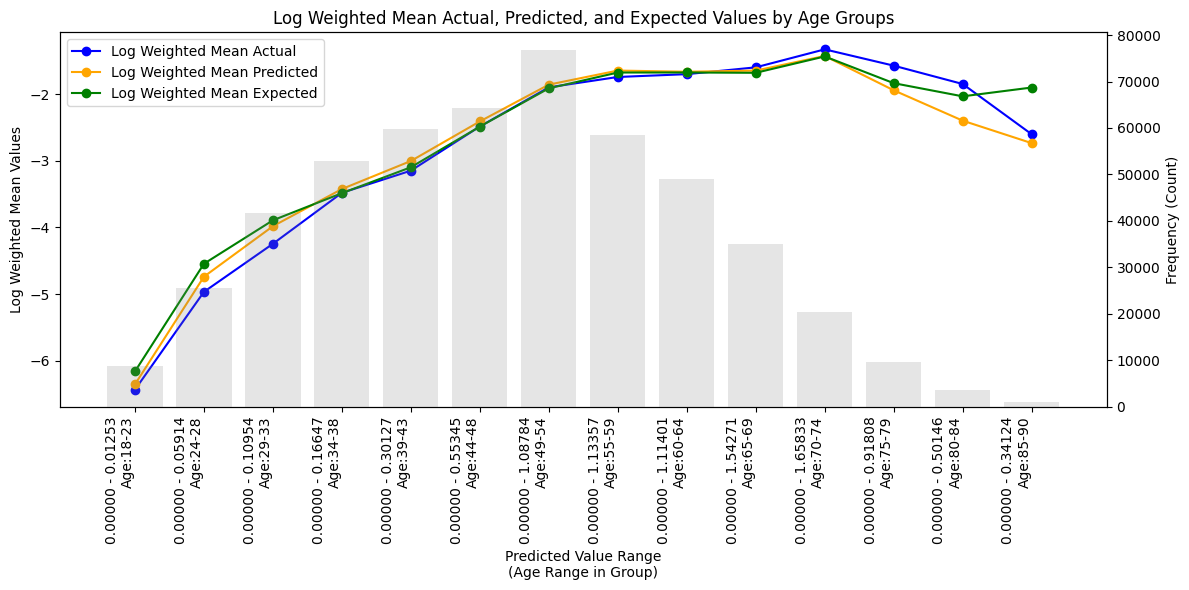

In [83]:
# Convert tensors to numpy arrays
actual = y_test_tensor.numpy().flatten()
predicted = np.round(y_pred, 10)
weights2 = lives_exposure_test_tensor.numpy().flatten()
expected_claims = test_df["ExpectedClaims"].values.flatten()

# Create DataFrame
df_lift = pd.DataFrame({
    "actual": actual,
    "predicted": predicted,
    "Age": test_df["Age"].values.flatten(),
    "expected": expected_claims,
    "weights": weights2
})

# Bin ages into 10 equal-width groups using nearest integer ages
min_age = int(df_lift["Age"].min())
max_age = int(df_lift["Age"].max())
bins = np.linspace(min_age, max_age, 15)
labels = range(len(bins)-1)
df_lift["age_group"] = pd.cut(df_lift["Age"], bins=bins, labels=labels, include_lowest=True)

# Define weighted mean function
def weighted_mean(group):
    return pd.Series({
        "weighted_actual": np.average(group["actual"], weights=group["weights"]),
        "weighted_predicted": np.average(group["predicted"], weights=group["weights"]),
        "weighted_expected": np.average(group["expected"], weights=group["weights"]),
        "range": f"{group['predicted'].min():.5f} - {group['predicted'].max():.5f}",
        "count": len(group),
        "age_range": f"{group['Age'].min():.0f}-{group['Age'].max():.0f}"
    })

# Group by age_group and compute summary
age_group_summary = df_lift.groupby("age_group").apply(weighted_mean).reset_index(drop=True)

# Log-transform values
age_group_summary["log_weighted_actual"] = np.log(age_group_summary["weighted_actual"])
age_group_summary["log_weighted_predicted"] = np.log(age_group_summary["weighted_predicted"])
age_group_summary["log_weighted_expected"] = np.log(age_group_summary["weighted_expected"])

# Create x-axis labels
xtick_labels = [
    f"{r}\nAge:{a}" for r, a in zip(age_group_summary["range"], age_group_summary["age_range"])
]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(age_group_summary["log_weighted_actual"], label="Log Weighted Mean Actual", color="blue", marker="o")
ax1.plot(age_group_summary["log_weighted_predicted"], label="Log Weighted Mean Predicted", color="orange", marker="o")
ax1.plot(age_group_summary["log_weighted_expected"], label="Log Weighted Mean Expected", color="green", marker="o")
ax1.set_xlabel("Predicted Value Range\n(Age Range in Group)")
ax1.set_ylabel("Log Weighted Mean Values")
ax1.set_title("Log Weighted Mean Actual, Predicted, and Expected Values by Age Groups")
ax1.set_xticks(ticks=range(len(age_group_summary)))
ax1.set_xticklabels(xtick_labels, rotation=90, ha="right")
ax1.legend(loc="upper left")

# Add frequency bar plot
ax2 = ax1.twinx()
ax2.bar(range(len(age_group_summary)), age_group_summary["count"], color="gray", alpha=0.2, label="Frequency (Count)")
ax2.set_ylabel("Frequency (Count)")

plt.tight_layout()
plt.show()


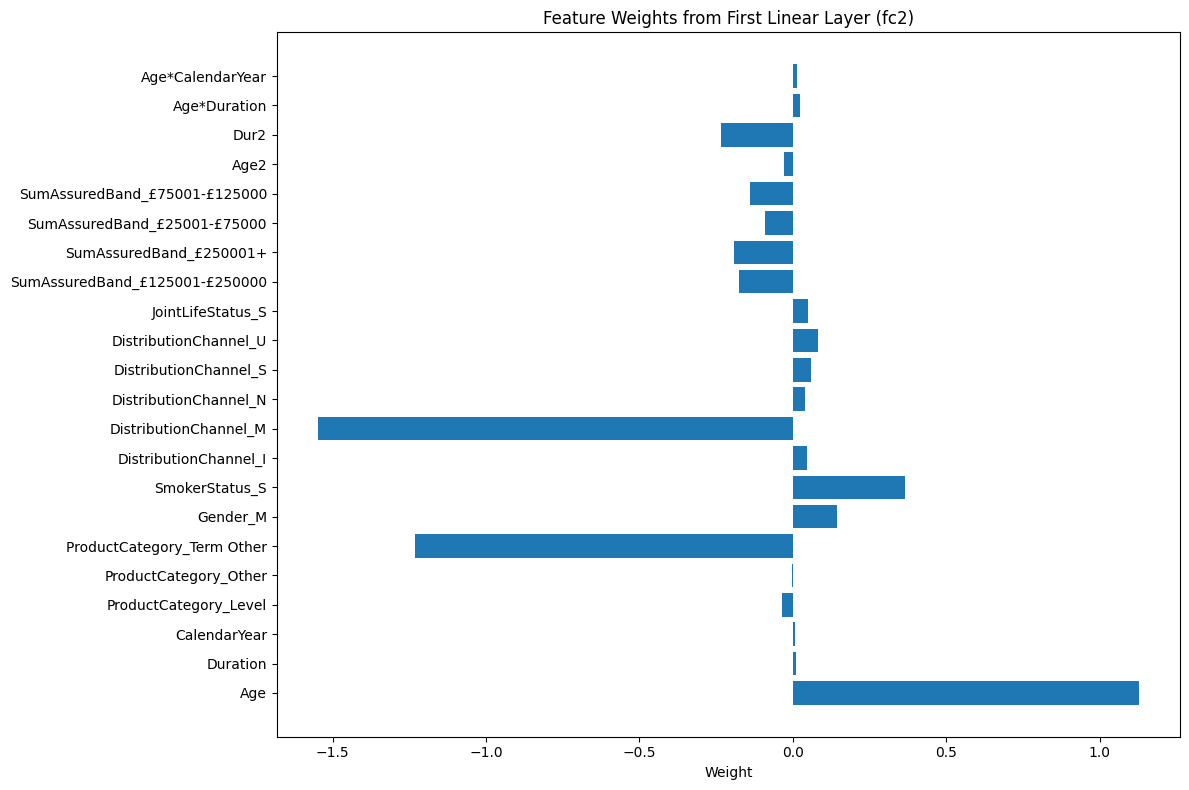

In [84]:
feature_names = list(X_train_scaled.columns)
# Add interaction term names: Age*Duration and Age*CalendarYear
interaction_names = []
for idx in model.duration_indices:
    interaction_names.append(f"Age*{X_train_scaled.columns[idx]}")
for idx in model.commencement_year_indices:
    interaction_names.append(f"Age*{X_train_scaled.columns[idx]}")

feature_names += interaction_names

weights_dict = model.state_dict()
fc2_weights = weights_dict["fc2.weight"].detach().cpu().numpy().flatten()

plt.figure(figsize=(12, 8))
plt.barh(feature_names, fc2_weights)
plt.xlabel("Weight")
plt.title("Feature Weights from First Linear Layer (fc2)")
plt.tight_layout()
plt.show()

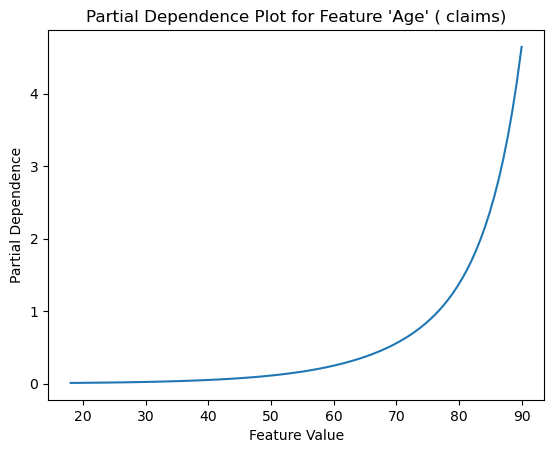

In [ ]:
feature_index = X_train.columns.get_loc("Age")
feature_index2 = X_train.columns.get_loc("Age2")
grid_values = np.linspace(
    X_train.iloc[:, feature_index].min(), X_train.iloc[:, feature_index].max(), 100
)

partial_dependence = []
for val in grid_values:
    X_temp = X_train.copy()
    X_temp.iloc[:, feature_index] = val
    X_temp.iloc[:, feature_index2] = (
        age_multiplier * np.maximum(val - age_cut, 0) ** age_power
    )
    X_temp_scaled = scaler.transform(X_temp)

    model.eval()
    with torch.no_grad():
        preds = model(
            torch.tensor(X_temp_scaled, dtype=torch.float32),
            lives_exposure_train_tensor,
        )
        # pred_rate = preds / lives_exposure_train_tensor
        weighted_avg = torch.sum(preds * lives_exposure_train_tensor) / torch.sum(
            lives_exposure_train_tensor
        )
        partial_dependence.append(weighted_avg.item())

# Plot the partial dependence
plt.plot(grid_values, partial_dependence)
plt.xlabel("Feature Value")
plt.ylabel("Partial Dependence")
plt.title("Partial Dependence Plot for Feature 'Age' ( claims)")
plt.show()

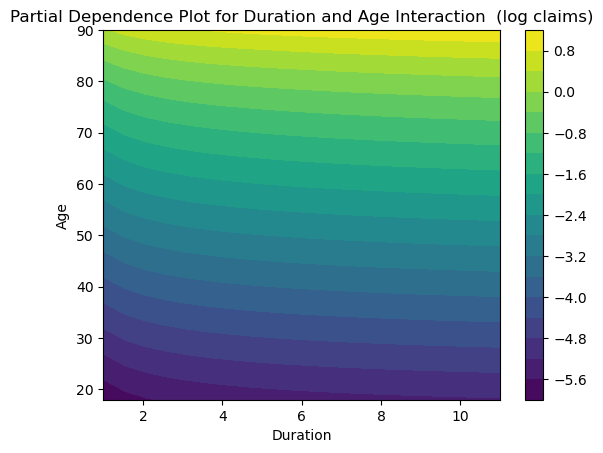

In [ ]:
feature_index_duration = X_train.columns.get_loc("Duration")
feature_index_age = X_train.columns.get_loc("Age")
feature_index_age2 = X_train.columns.get_loc("Age2")
feature_index_dur2 = X_train.columns.get_loc("Dur2")
# Create a grid of values for Duration and Age
grid_values_duration = np.linspace(
    X_train.iloc[:, feature_index_duration].min(),
    X_train.iloc[:, feature_index_duration].max(),
    20,
)
grid_values_age = np.linspace(
    X_train.iloc[:, feature_index_age].min(),
    X_train.iloc[:, feature_index_age].max(),
    20,
)

# Initialize an array to store partial dependence values
partial_dependence = np.zeros((len(grid_values_duration), len(grid_values_age)))

# Compute partial dependence values
for i, val_duration in enumerate(grid_values_duration):
    for j, val_age in enumerate(grid_values_age):
        X_temp = X_train.copy()
        X_temp.iloc[:, feature_index_duration] = val_duration
        X_temp.iloc[:, feature_index_age] = val_age
        X_temp.iloc[:, feature_index_age2] = age_multiplier * (
            np.maximum(val_age - age_cut, 0) ** age_power
        )
        X_temp.iloc[:, feature_index_dur2] = duration_multiplier * (
            np.maximum(val_duration, 0) ** duration_power
        )
        X_temp_scaled = scaler.transform(X_temp)

        model.eval()
        with torch.no_grad():
            y_pred = model(
                torch.tensor(X_temp_scaled, dtype=torch.float32),
                lives_exposure_train_tensor,
            )
            y_pred_log = np.log(y_pred)
            weights = lives_exposure_train_tensor.numpy().flatten()
            weighted_avg = np.sum(y_pred_log.numpy().flatten() * weights) / np.sum(
                weights
            )
            partial_dependence[i, j] = weighted_avg

# Plot the partial dependence
X, Y = np.meshgrid(grid_values_duration, grid_values_age)
plt.contourf(X, Y, partial_dependence.T, levels=20, cmap="viridis")
plt.colorbar()
plt.xlabel("Duration")
plt.ylabel("Age")
plt.title("Partial Dependence Plot for Duration and Age Interaction  (log claims)")
plt.show()

Other high level trends

#### Model 2 : Zero inflation Poisson

###### didnt use indipendence check

In [85]:
from scipy.stats import chi2_contingency

# Not used 
def check_independence(df):
    # Create a contingency table
    contingency_table = pd.crosstab(df["IncurredClaims"] == 0, df["IncurredClaims"] > 0)
    print(f"contingency_table : {contingency_table}")
    # Perform chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency_table)

    print(f"Chi-squared statistic: {chi2:.4f}")
    print(f"P-value: {p:.4f}")

    if p < 0.05:
        print(
            "The zero-inflation and Poisson processes are not independent (p < 0.05)."
        )
    else:
        print("The zero-inflation and Poisson processes are independent (p >= 0.05).")

In [106]:
df = combined_df_encoded.copy()

other_best_params = {
    "lr": 0.18636853215485796,
    "weight_decay": 1.178832278553321e-05,
    "num_epochs": 938,
    "lambda_l1": 0.09532607373570341,
    "age_cut": 89,
    "age_power": 4.012759717541797,
    "age_multiplier": 0,
    "duration_multiplier": 1,
    "duration_power": -0.5,
}
#best_trial_params= {'lr': 0.26499400906958195, 'weight_decay': 7.771609386937672e-06, 'num_epochs': 707, 'lambda_l1': 0.012188947951286626, 'age_cut': 56, 'age_power': 3.5300139707482083, 'age_multiplier': 1, 'duration_power': -1.7700043460802583, 'duration_multiplier': 1, 'saturated_r2': 0.2776065468788147}
best_trial_params= {'lr': 0.26499400906958195, 'weight_decay': 7.771609386937672e-06, 'num_epochs': 707, 'lambda_l1': 0.012188947951286626, 'age_cut': 26, 'age_power': 2.7649671012856936, 'age_multiplier': 0, 'duration_power': -1.017654352008134, 'duration_multiplier': 1, 'saturated_r2': 0.23898053169250488}
#best_trial_params={'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001,'age_cut': 49, 'age_power': 3.538752691168995, 'age_multiplier': 1, 'duration_power': -1.2241909443550256, 'duration_multiplier': 1, 'saturated_r2': 0.2516699433326721}
other_best_params=best_trial_params
age_cut = other_best_params["age_cut"]  # 50
age_power = other_best_params["age_power"]  # 4.133448889716881  #
weight_decay = other_best_params["weight_decay"]  # 1.0441166112064366e-05
num_epochs = other_best_params["num_epochs"]  # 680
lambda_l1 = other_best_params["lambda_l1"]
lr = other_best_params["lr"]
age_multiplier = other_best_params["age_multiplier"]
duration_multiplier = other_best_params["duration_multiplier"]
duration_power = other_best_params["duration_power"]
print("using other params")

exclude_features = [
    "DistributionChannel_I",
    "DistributionChannel_M",
    "DistributionChannel_N",
    "DistributionChannel_S",
    # "DistributionChannel_U",
    "SumAssuredBand_£125001-£250000",
    "SumAssuredBand_£250001+",
    # "SumAssuredBand_£25001-£75000",
    # "SumAssuredBand_£75001-£125000",
    # "Duration",
    "ProductCategory_Level",
    # "ProductCategory_Other",
    "ProductCategory_Term Other",
]
exclude_features1 = []
df = df.drop(columns=exclude_features)
df["Age2"] = (
    age_multiplier * np.maximum(df["Age"] - age_cut, 0) ** age_power
)  # np.exp(df['Age'])
df["Dur2"] = (
    duration_multiplier * np.maximum(df["Duration"] + 1 , 0) ** duration_power
)
df["LivesExposure"] = df["LivesExposure"].clip(
    lower=1e-6
)  # Ensure no zero or negative values;w we did filter out few cases earlier
train_df = df[df["holdout"] == 0]
test_df = df[df["holdout"] == 1]
train_lives_exposure = train_df["LivesExposure"]
test_lives_exposure = test_df["LivesExposure"]
X_train = train_df.drop(
    [
        "IncurredClaims",
        "LivesExposure",
        "Actual_deaths_lives",
        "Expected_deaths_lives",
        "ExpectedClaims",
        "Expected_deaths",
        "holdout",
        "random_fold",
        "CommencementYear",
    ],
    axis=1,
)
y_train = train_df["IncurredClaims"]
X_test = test_df.drop(
    [
        "IncurredClaims",
        "LivesExposure",
        "Actual_deaths_lives",
        "Expected_deaths_lives",
        "ExpectedClaims",
        "Expected_deaths",
        "holdout",
        "random_fold",
        "CommencementYear",
    ],
    axis=1,
)
y_test = test_df["IncurredClaims"]

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)
age_test_tensor = torch.tensor(X_test["Age"].values, dtype=torch.float32)
# Convert LivesExposure to tensors
lives_exposure_train_tensor = torch.tensor(
    train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
)
lives_exposure_test_tensor = torch.tensor(
    test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
)


class Mort_Net_ZIP(nn.Module):
    def __init__(self):
        super(Mort_Net_ZIP, self).__init__()

        # Identify the indices of the specific columns
        self.age_idx = X_train_scaled.columns.get_loc("Age")
        self.duration_indices = [
            i
            for i, col in enumerate(X_train_scaled.columns)
            if col.startswith("Duration")
        ]
        self.commencement_year_indices = [
            i
            for i, col in enumerate(X_train_scaled.columns)
            if col.startswith("CalendarYear")
        ]

        # Define the fully connected layers
        interaction_input_size = len(self.duration_indices) + len(
            self.commencement_year_indices
        )
        self.fc2 = nn.Linear(
            len(X_train_scaled.columns) + interaction_input_size, 1
        )  # Include original features and interaction terms

        # Additional layer for zero inflation
        self.fc_zero_inflation = nn.Linear(
            len(X_train_scaled.columns) + interaction_input_size, 1
        )

    def forward(self, x, exposure):
        # Create interaction terms
        age_feature = x[:, self.age_idx].unsqueeze(1)
        interaction_terms = []
        for idx in self.duration_indices + self.commencement_year_indices:
            interaction_term = age_feature * x[:, idx].unsqueeze(1)
            interaction_terms.append(interaction_term)
        interaction_terms1 = torch.cat(interaction_terms, dim=1)

        # Concatenate the original features with interaction terms
        x_combined = torch.cat((x, interaction_terms1), dim=1)

        # Final fully connected layer for Poisson part
        linear_output = self.fc2(x_combined)

        # Adding the log of the exposure as an offset
        offset_output = linear_output + torch.log(exposure)

        # Apply exponential activation for the Poisson part
        poisson_output = torch.exp(offset_output)

        # Zero inflation part
        zero_inflation_output = torch.sigmoid(self.fc_zero_inflation(x_combined))

        return poisson_output, zero_inflation_output


model = Mort_Net_ZIP()


def joint_loss(poisson_output, zero_inflation_output, y_true, exposure):
    """
    Torch-only negative weighted log-likelihood for Zero-Inflated Poisson.
    Ensures no unintended broadcasting by reshaping to 1-D.
    """
    eps = 1e-8

    # Force 1-D vectors (same length) to avoid broadcasting -> O(N^2) allocations
    mu = poisson_output.reshape(-1).clamp(min=eps)
    pi = zero_inflation_output.reshape(-1).clamp(min=eps, max=1.0 - eps)
    y = y_true.reshape(-1)
    w = exposure.reshape(-1)

    # sanity check
    if not (mu.shape == pi.shape == y.shape == w.shape):
        raise ValueError(f"Shape mismatch: mu{mu.shape} pi{pi.shape} y{y.shape} w{w.shape}")

    is_zero = (y == 0).float()

    # log-prob for zero and positive outcomes
    log_p_zero = torch.log(pi + (1.0 - pi) * torch.exp(-mu) + eps)
    log_poisson = y * torch.log(mu) - mu - torch.lgamma(y + 1.0)
    log_p_pos = torch.log(1.0 - pi + eps) + log_poisson

    log_prob = is_zero * log_p_zero + (1.0 - is_zero) * log_p_pos

    # weighted negative log-likelihood (normalize by total exposure)
    weighted_log_prob = log_prob * w
    neg_weighted_nll = -torch.sum(weighted_log_prob) / (torch.sum(w) + eps)

    return neg_weighted_nll

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


def l1_loss(model, lambda_l1):
    l1 = 0
    for param in model.parameters():
        l1 += torch.sum(torch.abs(param))
    return lambda_l1 * l1


def weighted_poisson_loss(poisson_output, y_true, exposure):
    poisson_log_likelihood = (
        y_true * torch.log(poisson_output + 1e-8)
        - poisson_output
        - torch.lgamma(y_true + 1)
    )
    weighted_poisson_log_likelihood = poisson_log_likelihood * exposure
    neg_weighted_poisson_log_likelihood = -torch.mean(weighted_poisson_log_likelihood)
    return neg_weighted_poisson_log_likelihood


def weighted_bernoulli_loss(zero_inflation_output, y_true, exposure):
    bernoulli_log_likelihood = y_true * torch.log(1 - zero_inflation_output + 1e-8) + (
        1 - y_true
    ) * torch.log(zero_inflation_output + 1e-8)
    weighted_bernoulli_log_likelihood = bernoulli_log_likelihood * exposure
    neg_weighted_bernoulli_log_likelihood = -torch.mean(
        weighted_bernoulli_log_likelihood
    )
    return neg_weighted_bernoulli_log_likelihood


# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    poisson_outputs, zero_inflation_outputs = model(
        X_train_tensor, lives_exposure_train_tensor
    )

    # Calculate losses
    loss = joint_loss(
        poisson_outputs,
        zero_inflation_outputs,
        y_train_tensor,
        lives_exposure_train_tensor,
    )
    l1_reg = l1_loss(model, lambda_l1=lambda_l1)
    poisson_loss = weighted_poisson_loss(
        poisson_outputs, y_train_tensor, lives_exposure_train_tensor
    )
    bernoulli_loss = weighted_bernoulli_loss(
        zero_inflation_outputs,
        (y_train_tensor == 0).float(),
        lives_exposure_train_tensor,
    )
    total_loss = poisson_loss + bernoulli_loss + l1_reg
    #    total_loss = loss + l1_reg
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(
            f"Epoch {epoch+1}, Joint Loss: {loss.item()}, Total Loss: {total_loss.item()}"
        )

model.eval()
with torch.no_grad():
    poisson_outputs, zero_inflation_outputs = model(
        X_test_tensor, lives_exposure_test_tensor
    )
    loss = joint_loss(
        poisson_outputs,
        zero_inflation_outputs,
        y_test_tensor,
        lives_exposure_test_tensor,
    )
    l1_reg = l1_loss(model, lambda_l1=lambda_l1)
    poisson_loss = weighted_poisson_loss(
        poisson_outputs, y_test_tensor, lives_exposure_test_tensor
    )
    bernoulli_loss = weighted_bernoulli_loss(
        zero_inflation_outputs,
        (y_test_tensor == 0).float(),
        lives_exposure_test_tensor,
    )
    total_loss = poisson_loss + bernoulli_loss + l1_reg

    # total_loss = loss + l1_reg
    print(
        f"Test Poisson Loss: Joint Loss: {loss.item()}, Total Loss: {total_loss.item()}"
    )

using other params
Epoch 20, Joint Loss: 1.0226463079452515, Total Loss: 67.10333251953125
Epoch 40, Joint Loss: 0.724256694316864, Total Loss: 20.47709846496582
Epoch 60, Joint Loss: 0.5948795676231384, Total Loss: 15.011362075805664
Epoch 80, Joint Loss: 0.5347135663032532, Total Loss: 13.187323570251465
Epoch 100, Joint Loss: 0.4947526752948761, Total Loss: 12.164912223815918
Epoch 120, Joint Loss: 0.46454399824142456, Total Loss: 11.455164909362793
Epoch 140, Joint Loss: 0.440782368183136, Total Loss: 10.920083045959473
Epoch 160, Joint Loss: 0.42077502608299255, Total Loss: 10.499945640563965
Epoch 180, Joint Loss: 0.4036937952041626, Total Loss: 10.162711143493652
Epoch 200, Joint Loss: 0.38907089829444885, Total Loss: 9.885920524597168
Epoch 220, Joint Loss: 0.3765343427658081, Total Loss: 9.656331062316895
Epoch 240, Joint Loss: 0.36575692892074585, Total Loss: 9.464425086975098
Epoch 260, Joint Loss: 0.35641855001449585, Total Loss: 9.300353050231934
Epoch 280, Joint Loss: 0.3

In [87]:
%pip install copulas

from scipy.stats import norm
from copulas.bivariate import Clayton, Gumbel, Frank
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import scatter_2d
from scipy.stats import poisson, bernoulli
from scipy.stats import multivariate_normal

Note: you may need to restart the kernel to use updated packages.


In [107]:
model.eval()
with torch.no_grad():
    poisson_outputs, zero_inflation_outputs = model(
        X_train_tensor, lives_exposure_train_tensor
    )
    predicted_claims = poisson_outputs * (1 - zero_inflation_outputs)
    predicted_claims = predicted_claims.numpy()

# Calculate residuals
residuals = y_train_tensor.numpy().flatten() - predicted_claims.flatten()

# Transform residuals to uniform marginals for copula fitting
uniform_residuals = norm.cdf(residuals)

# Transform Poisson outputs to uniform marginals using Poisson CDF
uniform_poisson = poisson.cdf(poisson_outputs, mu=poisson_outputs)

# Transform Bernoulli outputs to uniform marginals using Bernoulli CDF
uniform_bernoulli = bernoulli.cdf(zero_inflation_outputs, p=zero_inflation_outputs)

# Create a two-dimensional dataset
copula_data = np.column_stack((uniform_poisson, uniform_bernoulli))

# Fit different copulas using the residuals from Mort_Net_ZIP model
gaussian_copula = GaussianMultivariate()
gaussian_copula.fit(copula_data)

frank_copula = Frank()
frank_copula.fit(copula_data)
# Compute log-likelihood for Gaussian copula
# mean = gaussian_copula.distribution.mean
# covariance = gaussian_copula.distribution.covariance
# gaussian_log_likelihood = np.sum(multivariate_normal.logpdf(copula_data, mean=mean, cov=covariance))
# gaussian_aic = 2 * len(mean) - 2 * gaussian_log_likelihood

In [108]:
# Extract the theta parameter
theta_frank = frank_copula.theta
print(f"Frank copula theta: {theta_frank}")

# Interpretation
if theta_frank == 0:
    print("The variables are independent.")
elif theta_frank > 0:
    print("There is positive dependence between the variables.")
else:
    print("There is negative dependence between the variables.")

Frank copula theta: 0.7121466702560096
There is positive dependence between the variables.


## Boosted Model approach  

In [216]:
other_best_params = {'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001, 'age_cut': 25, 'age_power': 2.065978965764992, 'age_cut2':35,'age_power2':1.795259099626305,'age_multiplier': 1, 'duration_power': -0.7488155250040655, 'duration_multiplier': 1, 'saturated_r2': 0.28533536195755005}
#best_trial_params= {'lr': 0.12429320100834627, 'weight_decay': 0.0009981635839948447, 'num_epochs': 1113, 'lambda_l1': 0.004462617584860143, 'age_cut': 84, 'age_power': 4.395259099626305, 'age_multiplier': 0, 'duration_power': 1.9747705114245737, 'duration_multiplier': 0, 'saturated_r2': 0.2742123007774353}
#other_best_params = best_trial_params
other_best_params = {'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001,'age_cut': 25, 'age_power': 2.065978965764992,'age_cut2': 38, 'age_power2': 3.8160596568977105, 'age_multiplier2': 1, 'duration_power': -0.97948666632435, 'duration_multiplier': 1, 'saturated_r2': 0.2515134811401367}
other_best_params = {'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001,'age_cut2': 49, 'age_power2': 2.636071487968217, 'age_multiplier2': 1, 'duration_power': -1.5612518467907566, 'duration_multiplier': 1, 'saturated_r2': 0.2415328025817871}
other_best_params = {'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001,'age_cut2': 49, 'age_power2': 3.538752691168995, 'age_multiplier2': 1, 'duration_power': -1.2541909443550256, 'duration_multiplier': 1, 'saturated_r2': 0.2516699433326721}
#other_best_params = {'lr': 0.3526063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001,'age_cut2': 57, 'age_power2': 3.1612619686126617, 'age_multiplier2': 1,'duration_power': -0.92477973943264487,'duration_multiplier': 1}
#age_cut = other_best_params["age_cut"]
age_cut2 = other_best_params["age_cut2"]
age_power2 = other_best_params["age_power2"]
#age_power = other_best_params["age_power"]
weight_decay = other_best_params["weight_decay"]
num_epochs = other_best_params["num_epochs"]
lambda_l1 = other_best_params["lambda_l1"]
lr = other_best_params["lr"]
age_multiplier2 = other_best_params["age_multiplier2"]
duration_multiplier = other_best_params["duration_multiplier"]
duration_power = other_best_params["duration_power"]

# Prepare the data
df = combined_df_encoded.copy()
exclude_features = [
    "DistributionChannel_I",
    "DistributionChannel_M",
    # "DistributionChannel_N",
    # "DistributionChannel_S",
    # "DistributionChannel_U",
    # "SumAssuredBand_£125001-£250000",
    "SumAssuredBand_£250001+",
    # "SumAssuredBand_£25001-£75000",
    # "SumAssuredBand_£75001-£125000",
    # "Duration",
    "ProductCategory_Level",
    "ProductCategory_Other",
    # "ProductCategory_Term Other",
]
exclude_features1 = []
df = df.drop(columns=exclude_features1)
#df["Age2"] = 0 #* np.maximum(age_cut2 - df["Age"], 0) ** age_power2
df["Age3"]= age_multiplier2 * np.maximum(df["Age"]-age_cut2, 0) ** age_power2
df["Dur2"] = duration_multiplier * np.maximum(df["Duration"] + 1, 0) ** duration_power
df["LivesExposure"] = df["LivesExposure"].clip(lower=1e-6)

train_df = df[df["holdout"] == 0]
test_df = df[df["holdout"] == 1]

train_lives_exposure = train_df["LivesExposure"]
test_lives_exposure = test_df["LivesExposure"]

X_train = train_df.drop(
    [
        "IncurredClaims",
        "LivesExposure",
        "Actual_deaths_lives",
        "Expected_deaths_lives",
        "ExpectedClaims",
        "Expected_deaths",
        "holdout",
        "random_fold",
        "CommencementYear",
    ],
    axis=1,
)
y_train = train_df["IncurredClaims"]
X_test = test_df.drop(
    [
        "IncurredClaims",
        "LivesExposure",
        "Actual_deaths_lives",
        "Expected_deaths_lives",
        "ExpectedClaims",
        "Expected_deaths",
        "holdout",
        "random_fold",
        "CommencementYear",
    ],
    axis=1,
)
y_test = test_df["IncurredClaims"]

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)
lives_exposure_train_tensor = torch.tensor(
    train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
)
lives_exposure_test_tensor = torch.tensor(
    test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
)
X_train_initial = X_train_scaled[
    ["Age",  "Gender_M", "Duration", "CalendarYear", "SmokerStatus_S","Dur2","Age3"]
]
X_test_initial = X_test_scaled[
    ["Age",  "Gender_M", "Duration", "CalendarYear", "SmokerStatus_S","Dur2", "Age3"]
]

# Convert to tensors
X_train_initial_tensor = torch.tensor(X_train_initial.values, dtype=torch.float32)
X_test_initial_tensor = torch.tensor(X_test_initial.values, dtype=torch.float32)


# Define the ZIP model with interaction terms
class Mort_Net_ZIP(nn.Module):
    def __init__(self):
        super(Mort_Net_ZIP, self).__init__()
        self.age_idx = X_train_scaled.columns.get_loc("Age")
        self.duration_idx = X_train_scaled.columns.get_loc("Duration")
        self.calendar_year_idx = X_train_scaled.columns.get_loc("CalendarYear")
        self.gender_idx = X_train_scaled.columns.get_loc("Gender_M")
        self.dur2_idx = X_train_scaled.columns.get_loc("Dur2")

        self.fc2 = nn.Linear(
            len(X_train_initial.columns) + 2, 1
        )  # +2 for interaction terms
        self.fc_zero_inflation = nn.Linear(len(X_train_initial.columns) + 2, 1)

    def forward(self, x, exposure):
        age_feature = x[:, self.age_idx].unsqueeze(1)
        duration_feature = x[:, self.duration_idx].unsqueeze(1)
        calendar_year_feature = x[:, self.calendar_year_idx].unsqueeze(1)

        interaction_age_duration = age_feature * duration_feature
        interaction_age_calendar_year = age_feature * calendar_year_feature

        x_combined = torch.cat(
            (x, interaction_age_duration, interaction_age_calendar_year), dim=1
        )

        linear_output = self.fc2(x_combined)
        offset_output = linear_output + torch.log(exposure)
        poisson_output = torch.exp(offset_output)

        zero_inflation_output = torch.sigmoid(self.fc_zero_inflation(x_combined))

        return poisson_output, zero_inflation_output


# Initialize and train the ZIP model
initial_model = Mort_Net_ZIP()
optimizer_initial = optim.Adam(
    initial_model.parameters(), lr=lr, weight_decay=weight_decay
)


def joint_loss(poisson_output, zero_inflation_output, y_true, exposure):

    poisson_loss = weighted_poisson_loss(poisson_output, y_true, exposure)
    bernoulli_loss = weighted_bernoulli_loss(
        zero_inflation_output, (y_true == 0).float(), exposure
    )

    # Transform Poisson outputs to uniform marginals using Poisson CDF
    uniform_poisson = poisson.cdf(
        poisson_output.detach().numpy(), mu=poisson_output.detach().numpy()
    )

    # Transform Bernoulli outputs to uniform marginals using Bernoulli CDF
    uniform_bernoulli = bernoulli.cdf(
        zero_inflation_output.detach().numpy(),
        p=zero_inflation_output.detach().numpy(),
    )
    uniform_poisson = np.clip(uniform_poisson, 1e-6, 1 - 1e-6)
    uniform_bernoulli = np.clip(uniform_bernoulli, 1e-6, 1 - 1e-6)
    # Create a two-dimensional dataset for copula fitting
    copula_data = np.column_stack(
        (uniform_poisson.flatten(), uniform_bernoulli.flatten())
    )

    # Fit the Frank copula to the data
    frank_copula = Frank()
    frank_copula.fit(copula_data)

    pdf_values = frank_copula.probability_density(copula_data)

    loss_ll = poisson_loss + bernoulli_loss
    n_log_likelihood_copula_weighted = -np.sum(
        np.log(pdf_values) * exposure.detach().numpy().flatten()
    ) / np.sum(exposure.detach().numpy().flatten())

    return loss_ll + n_log_likelihood_copula_weighted


for epoch in range(num_epochs):
    optimizer_initial.zero_grad()
    poisson_outputs, zero_inflation_outputs = initial_model(
        X_train_initial_tensor, lives_exposure_train_tensor
    )
    loss = joint_loss(
        poisson_outputs,
        zero_inflation_outputs,
        y_train_tensor,
        lives_exposure_train_tensor,
    )
    loss.backward()
    optimizer_initial.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Initial Model Loss: {loss.item()}")

# Get predictions from the initial model
poisson_outputs, zero_inflation_outputs = initial_model(
    X_train_initial_tensor, lives_exposure_train_tensor
)
initial_predictions = poisson_outputs * (1 - zero_inflation_outputs)
initial_predictions = initial_predictions.detach()


# Define the second Poisson model with offset
class SecondPoissonModel(nn.Module):
    def __init__(self, input_size):
        super(SecondPoissonModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x, exposure, initial_predictions):
        linear_output = self.fc(x)
        offset_output = linear_output + torch.log(initial_predictions)
        poisson_output = torch.exp(offset_output)
        return poisson_output


# Prepare features for the second model
features_except_age_sex = [
    f
    for f in X_train_scaled.columns
    if f not in []#"Age", "Age2", "Gender_M", "Duration", "CalendarYear", "Dur2"]
]
X_train_second = X_train_scaled[features_except_age_sex]
X_test_second = X_test_scaled[features_except_age_sex]

X_train_second_tensor = torch.tensor(X_train_second.values, dtype=torch.float32)
X_test_second_tensor = torch.tensor(X_test_second.values, dtype=torch.float32)

# Initialize and train the second model
second_model = SecondPoissonModel(len(X_train_second.columns))
optimizer_second = optim.Adam(
    second_model.parameters(), lr=lr, weight_decay=weight_decay
)


def weighted_poisson_loss(poisson_output, y_true, exposure):
    poisson_log_likelihood = (
        y_true * torch.log(poisson_output + 1e-25)
        - poisson_output
        - torch.lgamma(y_true + 1)
    )
    weighted_poisson_log_likelihood = poisson_log_likelihood * exposure
    neg_weighted_poisson_log_likelihood = -torch.mean(weighted_poisson_log_likelihood)
    return neg_weighted_poisson_log_likelihood


for epoch in range(num_epochs):
    optimizer_second.zero_grad()
    second_outputs = second_model(
        X_train_second_tensor, lives_exposure_train_tensor, initial_predictions
    )
    second_loss = weighted_poisson_loss(
        second_outputs, y_train_tensor, lives_exposure_train_tensor
    )
    second_loss.backward()
    optimizer_second.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Second Model Loss: {second_loss.item()}")

# Evaluation
initial_model.eval()
second_model.eval()
with torch.no_grad():
    poisson_outputs_test, zero_inflation_outputs_test = initial_model(
        X_test_initial_tensor, lives_exposure_test_tensor
    )
    initial_predictions_test = poisson_outputs_test * (1 - zero_inflation_outputs_test)
    initial_predictions_test = initial_predictions_test.detach()
    second_outputs = second_model(
        X_test_second_tensor, lives_exposure_test_tensor, initial_predictions_test
    )
    second_loss = weighted_poisson_loss(
        second_outputs, y_test_tensor, lives_exposure_test_tensor
    )

    y_pred = second_outputs
    y_test_tensor = y_test_tensor + 1e-25
    weighted_mean_target = torch.sum(
        y_test_tensor  
    ) / torch.sum(lives_exposure_test_tensor)
    predicted_null=lives_exposure_test_tensor * weighted_mean_target
    null_deviance = 2 * torch.sum(
        lives_exposure_test_tensor
        * (
            y_test_tensor * torch.log(y_test_tensor / predicted_null)
            - (y_test_tensor - predicted_null)
        )
    )
    model_deviance = 2 * torch.sum(
        lives_exposure_test_tensor
        * (y_test_tensor * torch.log(y_test_tensor / y_pred) - (y_test_tensor - y_pred))
    )
    pseudo_r2 = 1 - (model_deviance / null_deviance)
    print(f"Pseudo R2: {pseudo_r2.item()}")
    


Epoch 20, Initial Model Loss: 32.90424728393555
Epoch 40, Initial Model Loss: 14.389984130859375
Epoch 60, Initial Model Loss: 11.511615753173828
Epoch 80, Initial Model Loss: 10.58183765411377
Epoch 100, Initial Model Loss: 9.971379280090332
Epoch 120, Initial Model Loss: 9.550707817077637
Epoch 140, Initial Model Loss: 9.216141700744629
Epoch 160, Initial Model Loss: 8.943257331848145
Epoch 180, Initial Model Loss: 8.718445777893066
Epoch 200, Initial Model Loss: 8.529398918151855
Epoch 220, Initial Model Loss: 8.36764907836914
Epoch 240, Initial Model Loss: 8.228001594543457
Epoch 260, Initial Model Loss: 8.106425285339355
Epoch 280, Initial Model Loss: 7.999828815460205
Epoch 300, Initial Model Loss: 7.905801773071289
Epoch 320, Initial Model Loss: 7.822467803955078
Epoch 340, Initial Model Loss: 7.748289585113525
Epoch 360, Initial Model Loss: 7.681983470916748
Epoch 380, Initial Model Loss: 7.622464656829834
Epoch 400, Initial Model Loss: 7.568899154663086
Epoch 420, Initial Mode

In [226]:
def objective(trial, features, df, best_trial_params=None):
    if best_trial_params is None:
        other_best_params = {'lr': 0.3526063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1016, 'lambda_l1': 0.0010042726424270001, 'age_cut': 25, 'age_power': 2.065978965764992, 'age_cut2':35,'age_power2':1.795259099626305,'age_multiplier': 1, 'duration_power': -1.7488155250040655, 'duration_multiplier': 1, 'saturated_r2': 0.28533536195755005}
        lr = other_best_params["lr"]
        weight_decay = other_best_params["weight_decay"]
        num_epochs = other_best_params["num_epochs"]
        lambda_l1 = other_best_params["lambda_l1"]
        #age_cut = trial.suggest_int("age_cut", 20, 90)
        age_cut2 = trial.suggest_int("age_cut2", 45, 75)
        age_power2 = trial.suggest_float("age_power2", 1.9, 4)
        #age_power = trial.suggest_float("age_power", 1.1, 5)
        #age_multiplier = trial.suggest_int("age_multiplier", 0, 1)
        age_multiplier2 = 1 #trial.suggest_int("age_multiplier2", 0, 1)
        duration_power = trial.suggest_float("duration_power", -3, 0.5)
        duration_multiplier = 1#trial.suggest_int("duration_multiplier", 0, 1)
    else:
        lr = best_trial_params["lr"]
        weight_decay = best_trial_params["weight_decay"]
        num_epochs = best_trial_params["num_epochs"]
        lambda_l1 = best_trial_params["lambda_l1"]
        age_cut = best_trial_params["age_cut"]
        age_power = best_trial_params["age_power"]
        age_multiplier = best_trial_params["age_multiplier"]
        duration_power = best_trial_params["duration_power"]
        duration_multiplier = best_trial_params["duration_multiplier"]

    pseudo_r2_scores = []

    for fold in range(1, 2):
        #df["Age3"] = 0#np.maximum(age_cut-df["Age"], 0) ** age_power*age_multiplier2
        df["Age2"] = age_multiplier2 * np.maximum(df["Age"] - age_cut2, 0) ** age_power2
        df["Dur2"] = duration_multiplier * np.maximum(df["Duration"] + 1, 0) ** duration_power
        df["LivesExposure"] = df["LivesExposure"].clip(lower=1e-6)
        train_df = df[df["holdout"] == 0]
        test_df = df[~(df["holdout"] == 0)]

        train_lives_exposure = train_df["LivesExposure"]
        test_lives_exposure = test_df["LivesExposure"]

        if "Age2" not in features:
            features.append("Age2")
        if "Dur2" not in features:
            features.append("Dur2")
        #if "Age3" not in features:
        #    features.append("Age3")
        X_train = train_df[features]
        y_train = train_df["IncurredClaims"]
        X_test = test_df[features]
        y_test = test_df["IncurredClaims"]

        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), columns=X_train.columns
        )
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

        X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(
            y_train.values.reshape(-1, 1), dtype=torch.float32
        )
        y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)
        lives_exposure_train_tensor = torch.tensor(
            train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )
        lives_exposure_test_tensor = torch.tensor(
            test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )

        # Initialize the initial ZIP model with interaction terms
        X_train_initial = X_train_scaled[
            ["Age",  "Gender_M", "Duration", "CalendarYear", "SmokerStatus_S","Age2","Dur2"]#,"Age3"]
        ]
        X_test_initial = X_test_scaled[
            ["Age",  "Gender_M", "Duration", "CalendarYear", "SmokerStatus_S","Age2","Dur2"]#, "Age3"]
        ]
        # Conrt to tensors
        X_train_initial_tensor = torch.tensor(
            X_train_initial.values, dtype=torch.float32
        )
        X_test_initial_tensor = torch.tensor(X_test_initial.values, dtype=torch.float32)

        initial_model = Mort_Net_ZIP()
        optimizer_initial = optim.Adam(
            initial_model.parameters(), lr=lr, weight_decay=weight_decay
        )

        # Train the initial ZIP model
        for epoch in range(num_epochs):
            optimizer_initial.zero_grad()
            poisson_outputs, zero_inflation_outputs = initial_model(
                X_train_initial_tensor, lives_exposure_train_tensor
            )
            loss = joint_loss(
                poisson_outputs,
                zero_inflation_outputs,
                y_train_tensor,
                lives_exposure_train_tensor,
            )
            loss.backward()
            optimizer_initial.step()

        # Get predictions from the initial model
        with torch.no_grad():
            poisson_outputs, zero_inflation_outputs = initial_model(
                X_train_initial_tensor, lives_exposure_train_tensor
            )
            initial_predictions = poisson_outputs * (1 - zero_inflation_outputs)
            initial_predictions = initial_predictions.detach()

        # Initialize and train the second model with all features except the ones used in the initial model
        features_except_initial = [
            f
            for f in features
            #if f not in ["Age", "Age2", "Gender_M", "Duration", "CalendarYear", "Dur2"]
        ]
        X_train_second = X_train_scaled[features_except_initial]
        X_test_second = X_test_scaled[features_except_initial]

        X_train_second_tensor = torch.tensor(X_train_second.values, dtype=torch.float32)
        X_test_second_tensor = torch.tensor(X_test_second.values, dtype=torch.float32)

        second_model = SecondPoissonModel(len(X_train_second.columns))
        optimizer_second = optim.Adam(
            second_model.parameters(), lr=lr, weight_decay=weight_decay
        )

        for epoch in range(num_epochs):
            optimizer_second.zero_grad()
            second_outputs = second_model(
                X_train_second_tensor, lives_exposure_train_tensor, initial_predictions
            )
            second_loss = weighted_poisson_loss(
                second_outputs, y_train_tensor, lives_exposure_train_tensor
            )
            second_loss.backward()
            optimizer_second.step()

        # Evaluation for the second model
        second_model.eval()
        initial_model.eval()
        with torch.no_grad():
            poisson_outputs_test, zero_inflation_outputs_test = initial_model(
                X_test_initial_tensor, lives_exposure_test_tensor
            )
            initial_predictions_test = poisson_outputs_test * (
                1 - zero_inflation_outputs_test
            )
            initial_predictions_test = initial_predictions_test.detach()
            second_outputs = second_model(
                X_test_second_tensor,
                lives_exposure_test_tensor,
                initial_predictions_test,
            )
            second_loss = weighted_poisson_loss(
                second_outputs, y_test_tensor, lives_exposure_test_tensor
            ) + l1_loss(second_model, lambda_l1=lambda_l1)

            y_pred = second_outputs
            y_test_tensor = y_test_tensor + 1e-8
            weighted_mean_target = torch.sum(
                y_test_tensor 
            ) / torch.sum(lives_exposure_test_tensor)
            predicted_null = lives_exposure_test_tensor * weighted_mean_target
            null_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log((y_test_tensor+1e-25) / predicted_null)
                    - (y_test_tensor - predicted_null)
                )
            )
            model_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log((y_test_tensor+1e-25) / y_pred)
                    - (y_test_tensor - y_pred)
                )
            )
            pseudo_r2 = 1 - (model_deviance / null_deviance)
            pseudo_r2_scores.append(pseudo_r2.item())

    mean_pseudo_r2 = np.mean(pseudo_r2_scores)
    print(f"Mean Pseudo_R2: {mean_pseudo_r2:.4f}")
    return mean_pseudo_r2


# Initial set of features
features = combined_df_encoded.columns.tolist()
features.remove("IncurredClaims")
features.remove("LivesExposure")
features.remove("Actual_deaths_lives")
features.remove("holdout")
features.remove("random_fold")
features.remove("CommencementYear")
features.remove("ExpectedClaims")
features.remove("Expected_deaths_lives")
features.remove("Expected_deaths")
exclude_features = [
   #"DistributionChannel_I",
    #"DistributionChannel_M",
    # "DistributionChannel_N",
    # "DistributionChannel_S",
    # "DistributionChannel_U",
    # "SumAssuredBand_£125001-£250000",
    #"SumAssuredBand_£250001+",
    # "SumAssuredBand_£25001-£75000",
    # "SumAssuredBand_£75001-£125000",
    # "Duration",
    #"ProductCategory_Level",
    #"ProductCategory_Other",
    # "ProductCategory_Term Other",
]
features = [feature for feature in features if feature not in exclude_features1]
df = combined_df_encoded.drop(columns=exclude_features, axis=1)

# Determine the best parameters using Optuna to maximize R2 score of deciles
study_ZIP = optuna.create_study(direction="maximize")
study_ZIP.optimize(
    lambda trial: objective(trial, features, df.sample(frac=0.6, random_state=1)),
    n_trials=20,
)

best_trial = study_ZIP.best_trial
best_trial_params = best_trial.params
best_trial_params["saturated_r2"] = best_trial.value
print(f"best_trial_params {best_trial_params}")


[I 2025-10-13 01:37:01,507] A new study created in memory with name: no-name-c9344451-03c3-4ac6-844d-0803a62a6a51
[I 2025-10-13 02:08:52,627] Trial 0 finished with value: 0.25121748447418213 and parameters: {'age_cut2': 50, 'age_power2': 2.840696933291285, 'duration_power': -0.5115169536626314}. Best is trial 0 with value: 0.25121748447418213.


Mean Pseudo_R2: 0.2512


[I 2025-10-13 02:40:38,498] Trial 1 finished with value: 0.25074493885040283 and parameters: {'age_cut2': 45, 'age_power2': 3.734113484370592, 'duration_power': -0.007532033241387737}. Best is trial 0 with value: 0.25121748447418213.


Mean Pseudo_R2: 0.2507


[I 2025-10-13 03:12:25,302] Trial 2 finished with value: 0.2496587634086609 and parameters: {'age_cut2': 46, 'age_power2': 2.685758921620446, 'duration_power': -1.4003400141942164}. Best is trial 0 with value: 0.25121748447418213.


Mean Pseudo_R2: 0.2497


[I 2025-10-13 03:44:38,321] Trial 3 finished with value: 0.2492222785949707 and parameters: {'age_cut2': 45, 'age_power2': 2.5539705598345965, 'duration_power': 0.37584137764112624}. Best is trial 0 with value: 0.25121748447418213.


Mean Pseudo_R2: 0.2492


[I 2025-10-13 04:16:37,146] Trial 4 finished with value: -0.005070805549621582 and parameters: {'age_cut2': 65, 'age_power2': 3.8153318026335805, 'duration_power': -0.8013389385931804}. Best is trial 0 with value: 0.25121748447418213.


Mean Pseudo_R2: -0.0051


[I 2025-10-13 04:49:14,148] Trial 5 finished with value: 0.25043541193008423 and parameters: {'age_cut2': 69, 'age_power2': 3.865769026710617, 'duration_power': -2.655482722203634}. Best is trial 0 with value: 0.25121748447418213.


Mean Pseudo_R2: 0.2504


[I 2025-10-13 05:22:20,469] Trial 6 finished with value: 0.2481868863105774 and parameters: {'age_cut2': 51, 'age_power2': 2.172554229482126, 'duration_power': 0.025739402836466585}. Best is trial 0 with value: 0.25121748447418213.


Mean Pseudo_R2: 0.2482


[I 2025-10-13 05:55:02,587] Trial 7 finished with value: 0.09456276893615723 and parameters: {'age_cut2': 67, 'age_power2': 2.7802174156994632, 'duration_power': -1.8023567503927944}. Best is trial 0 with value: 0.25121748447418213.


Mean Pseudo_R2: 0.0946


[I 2025-10-13 06:27:17,377] Trial 8 finished with value: 0.2505914568901062 and parameters: {'age_cut2': 45, 'age_power2': 2.476205245071246, 'duration_power': -1.5006281238982355}. Best is trial 0 with value: 0.25121748447418213.


Mean Pseudo_R2: 0.2506


[I 2025-10-13 06:59:45,295] Trial 9 finished with value: 0.2507464289665222 and parameters: {'age_cut2': 63, 'age_power2': 1.9079035939068667, 'duration_power': -0.4303776463795477}. Best is trial 0 with value: 0.25121748447418213.


Mean Pseudo_R2: 0.2507


[I 2025-10-13 07:32:06,845] Trial 10 finished with value: 0.24899399280548096 and parameters: {'age_cut2': 56, 'age_power2': 3.263470114856286, 'duration_power': -2.550571840365582}. Best is trial 0 with value: 0.25121748447418213.


Mean Pseudo_R2: 0.2490


[I 2025-10-13 08:04:57,190] Trial 11 finished with value: 0.2515833377838135 and parameters: {'age_cut2': 75, 'age_power2': 1.9262479204967635, 'duration_power': -0.6588861458136704}. Best is trial 11 with value: 0.2515833377838135.


Mean Pseudo_R2: 0.2516


[I 2025-10-13 08:37:28,035] Trial 12 finished with value: 0.25068384408950806 and parameters: {'age_cut2': 72, 'age_power2': 3.2014755541966022, 'duration_power': -0.810808830556015}. Best is trial 11 with value: 0.2515833377838135.


Mean Pseudo_R2: 0.2507


[I 2025-10-13 09:10:09,481] Trial 13 finished with value: 0.25171470642089844 and parameters: {'age_cut2': 57, 'age_power2': 3.1612619686126617, 'duration_power': -0.9247797394326448}. Best is trial 13 with value: 0.25171470642089844.


Mean Pseudo_R2: 0.2517
Mean Pseudo_R2: 0.2514


[I 2025-10-13 09:45:18,313] Trial 14 finished with value: 0.25141626596450806 and parameters: {'age_cut2': 59, 'age_power2': 3.2380942018312435, 'duration_power': -2.004563518541564}. Best is trial 13 with value: 0.25171470642089844.


Mean Pseudo_R2: 0.2516


[I 2025-10-13 10:21:20,992] Trial 15 finished with value: 0.25162631273269653 and parameters: {'age_cut2': 73, 'age_power2': 3.518924739144039, 'duration_power': -1.008493583405969}. Best is trial 13 with value: 0.25171470642089844.
[I 2025-10-13 10:52:50,842] Trial 16 finished with value: 0.25124484300613403 and parameters: {'age_cut2': 57, 'age_power2': 3.549250266181268, 'duration_power': -1.0521258663592268}. Best is trial 13 with value: 0.25171470642089844.


Mean Pseudo_R2: 0.2512


[I 2025-10-13 12:22:09,848] Trial 17 finished with value: 0.2478574514389038 and parameters: {'age_cut2': 61, 'age_power2': 3.4853880127307253, 'duration_power': -1.9029597249013308}. Best is trial 13 with value: 0.25171470642089844.


Mean Pseudo_R2: 0.2479


[I 2025-10-13 12:59:59,518] Trial 18 finished with value: 0.2514994144439697 and parameters: {'age_cut2': 54, 'age_power2': 3.070759871081642, 'duration_power': -0.15016718545974184}. Best is trial 13 with value: 0.25171470642089844.


Mean Pseudo_R2: 0.2515


[I 2025-10-13 13:34:00,024] Trial 19 finished with value: 0.12856841087341309 and parameters: {'age_cut2': 70, 'age_power2': 3.541948435503858, 'duration_power': -1.061826877152942}. Best is trial 13 with value: 0.25171470642089844.


Mean Pseudo_R2: 0.1286
best_trial_params {'age_cut2': 57, 'age_power2': 3.1612619686126617, 'duration_power': -0.9247797394326448, 'saturated_r2': 0.25171470642089844}


In [212]:
def objective(trial, features, df, best_trial_params=None):
    if best_trial_params is None:
        other_best_params = {'lr': 0.3526063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1016, 'lambda_l1': 0.0010042726424270001, 'age_cut': 25, 'age_power': 2.065978965764992, 'age_cut2':35,'age_power2':1.795259099626305,'age_multiplier': 1, 'duration_power': -1.7488155250040655, 'duration_multiplier': 1, 'saturated_r2': 0.28533536195755005}
        lr = other_best_params["lr"]
        weight_decay = other_best_params["weight_decay"]
        num_epochs = other_best_params["num_epochs"]
        lambda_l1 = other_best_params["lambda_l1"]
        #age_cut = trial.suggest_int("age_cut", 20, 90)
        age_cut2 = trial.suggest_int("age_cut2", 45, 75)
        age_power2 = trial.suggest_float("age_power2", 1.9, 4)
        #age_power = trial.suggest_float("age_power", 1.1, 5)
        #age_multiplier = trial.suggest_int("age_multiplier", 0, 1)
        age_multiplier2 = 1 #trial.suggest_int("age_multiplier2", 0, 1)
        duration_power = trial.suggest_float("duration_power", -3, 0.5)
        duration_multiplier = 1#trial.suggest_int("duration_multiplier", 0, 1)
    else:
        lr = best_trial_params["lr"]
        weight_decay = best_trial_params["weight_decay"]
        num_epochs = best_trial_params["num_epochs"]
        lambda_l1 = best_trial_params["lambda_l1"]
        age_cut = best_trial_params["age_cut"]
        age_power = best_trial_params["age_power"]
        age_multiplier = best_trial_params["age_multiplier"]
        duration_power = best_trial_params["duration_power"]
        duration_multiplier = best_trial_params["duration_multiplier"]

    pseudo_r2_scores = []

    for fold in range(1, 2):
        #df["Age3"] = 0#np.maximum(age_cut-df["Age"], 0) ** age_power*age_multiplier2
        df["Age2"] = age_multiplier2 * np.maximum(df["Age"] - age_cut2, 0) ** age_power2
        df["Dur2"] = duration_multiplier * np.maximum(df["Duration"] + 1, 0) ** duration_power
        df["LivesExposure"] = df["LivesExposure"].clip(lower=1e-6)
        train_df = df[df["holdout"] == 0]
        test_df = df[~(df["holdout"] == 0)]

        train_lives_exposure = train_df["LivesExposure"]
        test_lives_exposure = test_df["LivesExposure"]

        if "Age2" not in features:
            features.append("Age2")
        if "Dur2" not in features:
            features.append("Dur2")
        X_train = train_df[features]
        y_train = train_df["IncurredClaims"]
        X_test = test_df[features]
        y_test = test_df["IncurredClaims"]

        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), columns=X_train.columns
        )
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

        X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(
            y_train.values.reshape(-1, 1), dtype=torch.float32
        )
        y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)
        lives_exposure_train_tensor = torch.tensor(
            train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )
        lives_exposure_test_tensor = torch.tensor(
            test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )

        # Initialize the initial ZIP model with interaction terms
        X_train_initial = X_train_scaled[
            ["Age",  "Gender_M", "Duration", "CalendarYear", "SmokerStatus_S","Age2","Dur2"]
        ]
        X_test_initial = X_test_scaled[
            ["Age",  "Gender_M", "Duration", "CalendarYear", "SmokerStatus_S","Age2","Dur2"]
        ]
        # Conrt to tensors
        X_train_initial_tensor = torch.tensor(
            X_train_initial.values, dtype=torch.float32
        )
        X_test_initial_tensor = torch.tensor(X_test_initial.values, dtype=torch.float32)

        initial_model = Mort_Net_ZIP()
        optimizer_initial = optim.Adam(
            initial_model.parameters(), lr=lr, weight_decay=weight_decay
        )

        # Train the initial ZIP model
        for epoch in range(num_epochs):
            optimizer_initial.zero_grad()
            poisson_outputs, zero_inflation_outputs = initial_model(
                X_train_initial_tensor, lives_exposure_train_tensor
            )
            loss = joint_loss(
                poisson_outputs,
                zero_inflation_outputs,
                y_train_tensor,
                lives_exposure_train_tensor,
            )
            loss.backward()
            optimizer_initial.step()

        # Get predictions from the initial model
        with torch.no_grad():
            poisson_outputs, zero_inflation_outputs = initial_model(
                X_train_initial_tensor, lives_exposure_train_tensor
            )
            initial_predictions = poisson_outputs * (1 - zero_inflation_outputs)
            initial_predictions = initial_predictions.detach()

        # Initialize and train the second model with all features except the ones used in the initial model
        features_except_initial = [
            f
            for f in features
            #if f not in ["Age", "Age2", "Gender_M", "Duration", "CalendarYear", "Dur2"]
        ]
        X_train_second = X_train_scaled[features_except_initial]
        X_test_second = X_test_scaled[features_except_initial]

        X_train_second_tensor = torch.tensor(X_train_second.values, dtype=torch.float32)
        X_test_second_tensor = torch.tensor(X_test_second.values, dtype=torch.float32)

        second_zip_model = SecondMort_Net_ZIP(len(X_train_second.columns))
        optimizer_second_zip = optim.Adam(
            second_zip_model.parameters(), lr=lr, weight_decay=weight_decay
        )

        for epoch in range(num_epochs):
            optimizer_second_zip.zero_grad()
            poisson_outputs, zero_inflation_outputs = second_zip_model(
                X_train_second_tensor, lives_exposure_train_tensor, initial_predictions
            )
            loss = joint_loss(
                poisson_outputs,
                zero_inflation_outputs,
                y_train_tensor,
                lives_exposure_train_tensor,
            )
            loss.backward()
            optimizer_second_zip.step()

        # Evaluation
        initial_model.eval()
        second_zip_model.eval()
        with torch.no_grad():
            poisson_outputs_test, zero_inflation_outputs_test = initial_model(
                X_test_initial_tensor, lives_exposure_test_tensor
            )
            initial_predictions_test = poisson_outputs_test * (1 - zero_inflation_outputs_test)
            initial_predictions_test = initial_predictions_test.detach()
            poisson_outputs_test, zero_inflation_outputs_test = second_zip_model(
                X_test_second_tensor, lives_exposure_test_tensor, initial_predictions_test
            )
            y_pred_zip = poisson_outputs_test * (1 - zero_inflation_outputs_test)
            y_test_tensor = y_test_tensor + 1e-25
            weighted_mean_target = torch.sum(y_test_tensor) / torch.sum(lives_exposure_test_tensor)
            predicted_null = lives_exposure_test_tensor * weighted_mean_target
            null_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log(y_test_tensor / predicted_null)
                    - (y_test_tensor - predicted_null)
                )
            )
            model_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (y_test_tensor * torch.log(y_test_tensor / y_pred_zip) - (y_test_tensor - y_pred_zip))
            )
            pseudo_r2 = 1 - (model_deviance / null_deviance)
            print(f"Fold {fold} Pseudo_R2: {pseudo_r2:.4f}")
            pseudo_r2_scores.append(pseudo_r2.item())

    mean_pseudo_r2 = np.mean(pseudo_r2_scores)
    print(f"Mean Pseudo_R2: {mean_pseudo_r2:.4f}")
    return mean_pseudo_r2


# Initial set of features
features = combined_df_encoded.columns.tolist()
features.remove("IncurredClaims")
features.remove("LivesExposure")
features.remove("Actual_deaths_lives")
features.remove("holdout")
features.remove("random_fold")
features.remove("CommencementYear")
features.remove("ExpectedClaims")
features.remove("Expected_deaths_lives")
features.remove("Expected_deaths")
exclude_features = [
   #"DistributionChannel_I",
    #"DistributionChannel_M",
    # "DistributionChannel_N",
    # "DistributionChannel_S",
    # "DistributionChannel_U",
    # "SumAssuredBand_£125001-£250000",
    #"SumAssuredBand_£250001+",
    # "SumAssuredBand_£25001-£75000",
    # "SumAssuredBand_£75001-£125000",
    # "Duration",
    #"ProductCategory_Level",
    #"ProductCategory_Other",
    # "ProductCategory_Term Other",
]
features = [feature for feature in features if feature not in exclude_features1]
df = combined_df_encoded.drop(columns=exclude_features, axis=1)

# Determine the best parameters using Optuna to maximize R2 score of deciles
study_ZIP = optuna.create_study(direction="maximize")
study_ZIP.optimize(
    lambda trial: objective(trial, features, df.sample(frac=0.6, random_state=1)),
    n_trials=10,
)

best_trial = study_ZIP.best_trial
best_trial_params = best_trial.params
best_trial_params["saturated_r2"] = best_trial.value
print(f"best_trial_params {best_trial_params}")


[I 2025-10-11 13:48:28,883] A new study created in memory with name: no-name-9c741907-967e-447a-9d4c-297235e49baa


Fold 1 Pseudo_R2: 0.2430
Mean Pseudo_R2: 0.2430


[I 2025-10-11 14:51:27,339] Trial 0 finished with value: 0.24301844835281372 and parameters: {'age_cut2': 66, 'age_power2': 2.315632798090118, 'duration_power': -0.9442160863972697}. Best is trial 0 with value: 0.24301844835281372.


Fold 1 Pseudo_R2: -inf
Mean Pseudo_R2: -inf


[I 2025-10-11 15:54:47,873] Trial 1 finished with value: -inf and parameters: {'age_cut2': 50, 'age_power2': 3.6983540109930235, 'duration_power': -1.5581649436199188}. Best is trial 0 with value: 0.24301844835281372.


Fold 1 Pseudo_R2: 0.2427
Mean Pseudo_R2: 0.2427


[I 2025-10-11 16:58:41,948] Trial 2 finished with value: 0.2426537275314331 and parameters: {'age_cut2': 68, 'age_power2': 3.670068926265291, 'duration_power': -0.052232194781260954}. Best is trial 0 with value: 0.24301844835281372.
[I 2025-10-11 18:03:35,529] Trial 3 finished with value: -inf and parameters: {'age_cut2': 70, 'age_power2': 2.4099077462930985, 'duration_power': -0.6038050702267599}. Best is trial 0 with value: 0.24301844835281372.


Fold 1 Pseudo_R2: -inf
Mean Pseudo_R2: -inf


[I 2025-10-11 19:07:53,707] Trial 4 finished with value: 0.23560094833374023 and parameters: {'age_cut2': 55, 'age_power2': 2.6060465167513653, 'duration_power': -1.6156329167514827}. Best is trial 0 with value: 0.24301844835281372.


Fold 1 Pseudo_R2: 0.2356
Mean Pseudo_R2: 0.2356


[I 2025-10-11 20:27:07,235] Trial 5 finished with value: 0.24287980794906616 and parameters: {'age_cut2': 71, 'age_power2': 3.8656746427571527, 'duration_power': -0.9371182412373318}. Best is trial 0 with value: 0.24301844835281372.


Fold 1 Pseudo_R2: 0.2429
Mean Pseudo_R2: 0.2429
Fold 1 Pseudo_R2: 0.2496
Mean Pseudo_R2: 0.2496


[I 2025-10-11 21:32:04,956] Trial 6 finished with value: 0.24962729215621948 and parameters: {'age_cut2': 52, 'age_power2': 3.4801075812897238, 'duration_power': -2.0417606291166237}. Best is trial 6 with value: 0.24962729215621948.


Fold 1 Pseudo_R2: 0.1825
Mean Pseudo_R2: 0.1825


[I 2025-10-11 22:36:21,253] Trial 7 finished with value: 0.18254905939102173 and parameters: {'age_cut2': 75, 'age_power2': 2.970694132242518, 'duration_power': -2.8128944562007723}. Best is trial 6 with value: 0.24962729215621948.


Fold 1 Pseudo_R2: 0.2429
Mean Pseudo_R2: 0.2429


[I 2025-10-11 23:40:17,377] Trial 8 finished with value: 0.2428857684135437 and parameters: {'age_cut2': 50, 'age_power2': 2.14302474400558, 'duration_power': -2.3622422125387708}. Best is trial 6 with value: 0.24962729215621948.
[I 2025-10-12 00:47:35,335] Trial 9 finished with value: 0.24282068014144897 and parameters: {'age_cut2': 71, 'age_power2': 3.350192665141268, 'duration_power': 0.09682461007168097}. Best is trial 6 with value: 0.24962729215621948.


Fold 1 Pseudo_R2: 0.2428
Mean Pseudo_R2: 0.2428
best_trial_params {'age_cut2': 52, 'age_power2': 3.4801075812897238, 'duration_power': -2.0417606291166237, 'saturated_r2': 0.24962729215621948}


In [ ]:

def compute_feature_importance_zip(df, features, best_trial_params, objective_fn, n_trials=1, sample_frac=0.6):
    """
    Returns dict: {feature: importance} where importance = baseline_r2 - r2_with_feature_baselined.
    Runs lightweight Optuna evals using objective_fn with best_trial_params fixed.
    """
    one_hot_groups = {
        "ProductCategory": ["ProductCategory_Level","ProductCategory_Other","ProductCategory_Term Other"],
        "Gender": ["Gender_M"],
        "SmokerStatus": ["SmokerStatus_S"],
        "DistributionChannel": ["DistributionChannel_I","DistributionChannel_M","DistributionChannel_N","DistributionChannel_S","DistributionChannel_U"],
        "JointLifeStatus": ["JointLifeStatus_S"],
        "SumAssuredBand": ["SumAssuredBand_£125001-£250000","SumAssuredBand_£250001+","SumAssuredBand_£25001-£75000","SumAssuredBand_£75001-£125000"],
    }

    df_sample = df.sample(frac=sample_frac, random_state=1).copy()
    baseline_r2 = best_trial_params.get("saturated_r2", None)
    if baseline_r2 is None:
        raise ValueError("best_trial_params must include 'saturated_r2' (baseline R2 from ZIP tuning)")

    importances = {}
    for feat in features:
        # skip target / exposures / holdout cols
        if feat in ("IncurredClaims","LivesExposure","holdout","random_fold","Actual_deaths_lives","ExpectedClaims","Expected_deaths_lives","Expected_deaths"):
            continue
        if feat in ("Age2","Dur2","Age3"):
            continue

        df_tmp = df_sample.copy()

        # if feature is part of a one-hot group, baseline the whole group
        handled = False
        for grp, cols in one_hot_groups.items():
            if feat in cols:
                handled = True
                # set modal dummy to its mode, others to 0
                mode_val = df_tmp[cols].mode().iloc[0]
                for c in cols:
                    df_tmp[c] = mode_val[c] if c in mode_val.index else 0
                break

        if not handled:
            if feat in ("Age","Duration","CalendarYear"):
                df_tmp[feat] = df_tmp[feat].mean()
            else:
                df_tmp[feat] = df_tmp[feat].mode().iloc[0]

        # run a very small Optuna run that uses the provided objective with best params fixed
        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: objective_fn(trial, features.copy(), df_tmp, best_trial_params), n_trials=n_trials)
        r2 = study.best_trial.value
        importances[feat] = baseline_r2 - r2
        print(f"{feat}: baseline {baseline_r2:.5f} -> {r2:.5f}  importance {importances[feat]:.5f}")

    # sort and plot
    sorted_feats = sorted(importances, key=importances.get, reverse=True)
    sorted_imps = [importances[f] for f in sorted_feats]

    plt.figure(figsize=(8, max(4, len(sorted_feats)*0.25)))
    plt.barh(sorted_feats, sorted_imps, color="C0")
    plt.xlabel("Importance (drop in pseudo-R2)")
    plt.title("Feature importance (Mort_Net_ZIP)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return importances

# Example invocation (put this in the same new cell). Adjust sample fraction / n_trials for speed.
feature_list = features.copy()   # `features` defined earlier in notebook
fi = compute_feature_importance_zip(df.sample(frac=0.8, random_state=1), feature_list, best_trial_params, objective, n_trials=1, sample_frac=0.6)
print("Top 10 features:", sorted(fi.items(), key=lambda x: x[1], reverse=True)[:10])


boosted Neural Net AIC: 3872020.24


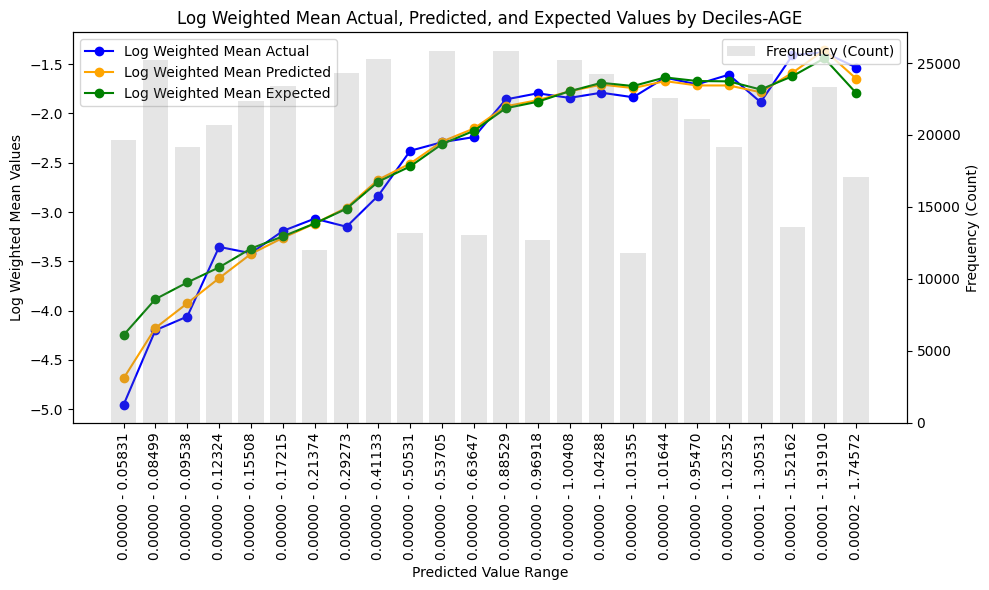

In [217]:
initial_model.eval()
second_model.eval()
with torch.no_grad():
    poisson_outputs_test = second_model(#, zero_inflation_outputs_test  = second_model(
        X_test_second_tensor, lives_exposure_test_tensor, initial_predictions_test
    )
second_outputs =   poisson_outputs_test #* (1 - zero_inflation_outputs_test)
y_pred = second_outputs.numpy().flatten()
actual = y_test_tensor.numpy().flatten()
predicted = y_pred
weights = lives_exposure_test_tensor.numpy().flatten()
# Poisson log-likelihood (weighted by exposure)
log_likelihood = np.sum(
        weights * (actual * np.log(predicted ) - predicted - np.log(np.maximum(1, np.array([math.factorial(int(y)) for y in actual]))))
    )

    # Number of parameters in the neural net (sum of all trainable parameters)
num_params = sum(p.numel() for p in initial_model.parameters() if p.requires_grad) + sum(p.numel() for p in second_model.parameters() if p.requires_grad)

    # AIC calculation: AIC = 2k - 2ln(L)
aic_boosted_nn = 2 * num_params - 2 * log_likelihood

print(f"boosted Neural Net AIC: {aic_boosted_nn:.2f}")
# Add ExpectedClaims from test_df if available
expected_claims = test_df["ExpectedClaims"].values.flatten() if "ExpectedClaims" in test_df.columns else np.zeros_like(actual)

# Create a DataFrame for lift analysis
df_lift = pd.DataFrame({
    "actual": actual,
    "predicted": predicted,
    "Age": age_test_tensor.numpy().flatten(),
    "expected": expected_claims,
    "weights": weights
})
df_lift = df_lift.sort_values(by="Age", ascending=False)
df_lift["decile"] = pd.qcut(df_lift["Age"], 25, labels=False)

def weighted_mean(group):
    return pd.Series({
        "weighted_actual": np.average(group["actual"], weights=group["weights"]),
        "weighted_predicted": np.average(group["predicted"], weights=group["weights"]),
        "weighted_expected": np.average(group["expected"], weights=group["weights"]),
        "range": f"{group['predicted'].min():.5f} - {group['predicted'].max():.5f}",
        "count": len(group)
    })

# Calculate weighted means and count for each decile
decile_summary = df_lift.groupby("decile").apply(weighted_mean)
decile_summary = decile_summary.iloc[1:].reset_index(drop=True)

# Take log of actual, predicted, and expected values
decile_summary["log_weighted_actual"] = np.log(decile_summary["weighted_actual"])
decile_summary["log_weighted_predicted"] = np.log(decile_summary["weighted_predicted"])
decile_summary["log_weighted_expected"] = np.log(decile_summary["weighted_expected"])

# Plot the weighted mean actual, predicted, and expected values for each decile
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(decile_summary["log_weighted_actual"], label="Log Weighted Mean Actual", color="blue", marker="o")
ax1.plot(decile_summary["log_weighted_predicted"], label="Log Weighted Mean Predicted", color="orange", marker="o")
ax1.plot(decile_summary["log_weighted_expected"], label="Log Weighted Mean Expected", color="green", marker="o")
ax1.set_xlabel("Predicted Value Range")
ax1.set_ylabel("Log Weighted Mean Values")
ax1.set_title("Log Weighted Mean Actual, Predicted, and Expected Values by Deciles-AGE")
ax1.set_xticks(ticks=range(len(decile_summary)))
ax1.set_xticklabels(decile_summary["range"], rotation=90)
ax1.legend(loc="upper left")

# Add frequency (count) as a bar plot on a secondary y-axis
ax2 = ax1.twinx()
ax2.bar(range(len(decile_summary)), decile_summary["count"], color="gray", alpha=0.2, label="Frequency (Count)")
ax2.set_ylabel("Frequency (Count)")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


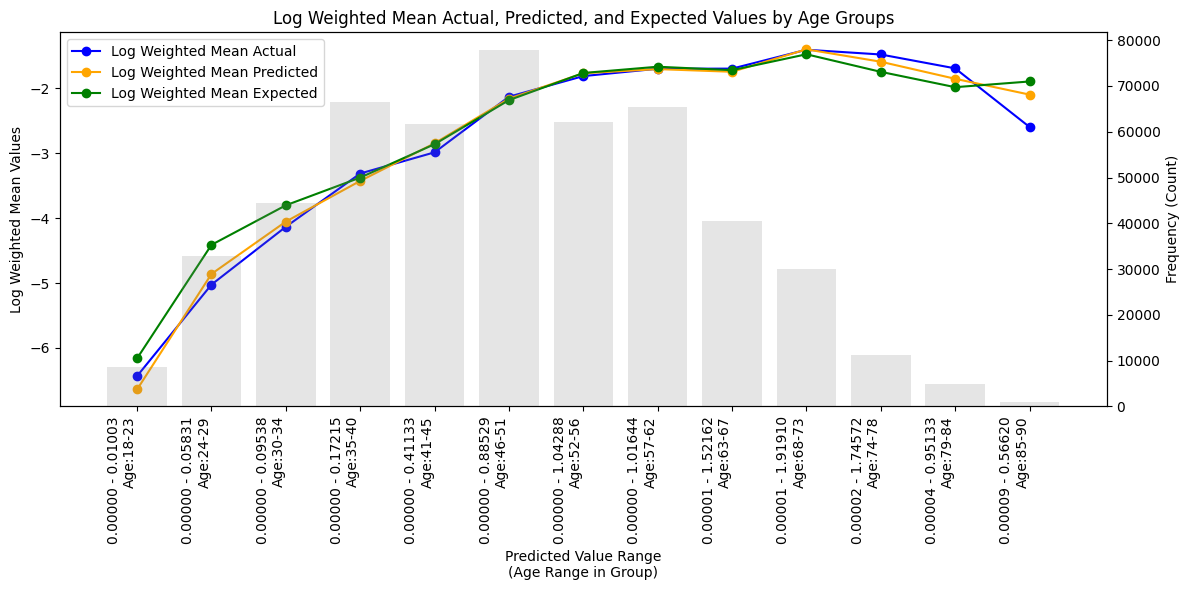

poisson deviance: 819882.0  psuedo R2 =0.24099379777908325
fc2.weight: tensor([[ 1.2272,  0.0835,  0.0427,  0.0032,  0.4712, -0.2062,  0.1424,  0.0743,
         -0.0090]])
fc2.bias: tensor([-6.7596])
fc_zero_inflation.weight: tensor([[ 0.9754,  0.1264,  0.2734,  0.0204, -0.3580,  0.0882, -0.5371,  0.1036,
         -0.0735]])
fc_zero_inflation.bias: tensor([-2.7621])
fc.weight: tensor([[ 0.0488,  0.0441,  0.0097, -0.0031, -0.0226, -0.0158,  0.0402, -0.1184,
         -0.0331, -0.0656, -0.0528, -0.0313, -0.0022,  0.0181, -0.1042, -0.1615,
         -0.0613, -0.0803, -0.1090,  0.0117]])
fc.bias: tensor([0.0059])


In [218]:
min_age = int(df_lift["Age"].min())
max_age = int(df_lift["Age"].max())
bins = np.linspace(min_age, max_age, 14)
labels = range(1, len(bins))
df_lift["age_group"] = pd.cut(df_lift["Age"], bins=bins, labels=labels, include_lowest=True)

# Define weighted mean function
def weighted_mean(group):
    return pd.Series({
        "weighted_actual": np.average(group["actual"], weights=group["weights"]),
        "weighted_predicted": np.average(group["predicted"], weights=group["weights"]),
        "weighted_expected": np.average(group["expected"], weights=group["weights"]),
        "range": f"{group['predicted'].min():.5f} - {group['predicted'].max():.5f}",
        "count": len(group),
        "age_range": f"{group['Age'].min():.0f}-{group['Age'].max():.0f}"
    })

# Group by age_group and compute summary
age_group_summary = df_lift.groupby("age_group").apply(weighted_mean).reset_index(drop=True)

# Log-transform values
age_group_summary["log_weighted_actual"] = np.clip(np.log(age_group_summary["weighted_actual"]), +10, -10)
age_group_summary["log_weighted_predicted"] = np.log(age_group_summary["weighted_predicted"])
age_group_summary["log_weighted_expected"] = np.log(age_group_summary["weighted_expected"])

# Create x-axis labels
xtick_labels = [
    f"{r}\nAge:{a}" for r, a in zip(age_group_summary["range"], age_group_summary["age_range"])
]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(age_group_summary["log_weighted_actual"], label="Log Weighted Mean Actual", color="blue", marker="o")
ax1.plot(age_group_summary["log_weighted_predicted"], label="Log Weighted Mean Predicted", color="orange", marker="o")
ax1.plot(age_group_summary["log_weighted_expected"], label="Log Weighted Mean Expected", color="green", marker="o")
ax1.set_xlabel("Predicted Value Range\n(Age Range in Group)")
ax1.set_ylabel("Log Weighted Mean Values")
ax1.set_title("Log Weighted Mean Actual, Predicted, and Expected Values by Age Groups")
ax1.set_xticks(ticks=range(len(age_group_summary)))
ax1.set_xticklabels(xtick_labels, rotation=90, ha="right")
ax1.legend(loc="upper left")

# Add frequency bar plot
ax2 = ax1.twinx()
ax2.bar(range(len(age_group_summary)), age_group_summary["count"], color="gray", alpha=0.2, label="Frequency (Count)")
ax2.set_ylabel("Frequency (Count)")

plt.tight_layout()
plt.show()

actual = actual #+ 1e-25
mean_target = np.sum(actual)/np.sum(weights)
predicted_null = weights * mean_target
null_deviance = 2 * sum(weights*(actual * np.log(actual / predicted_null) - (actual - predicted_null)))
model_deviance = 2 * sum(weights*(actual * np.log(actual / y_pred) - (actual - y_pred)))
poisson_deviance = null_deviance - model_deviance
print(
    f"poisson deviance: {poisson_deviance}  psuedo R2 ={ 1- model_deviance/null_deviance}"
)

weights = initial_model.state_dict()
for layer_name, weight in weights.items():
    print(f"{layer_name}: {weight}")

weights = second_model.state_dict()
for layer_name, weight in weights.items():
    print(f"{layer_name}: {weight}")


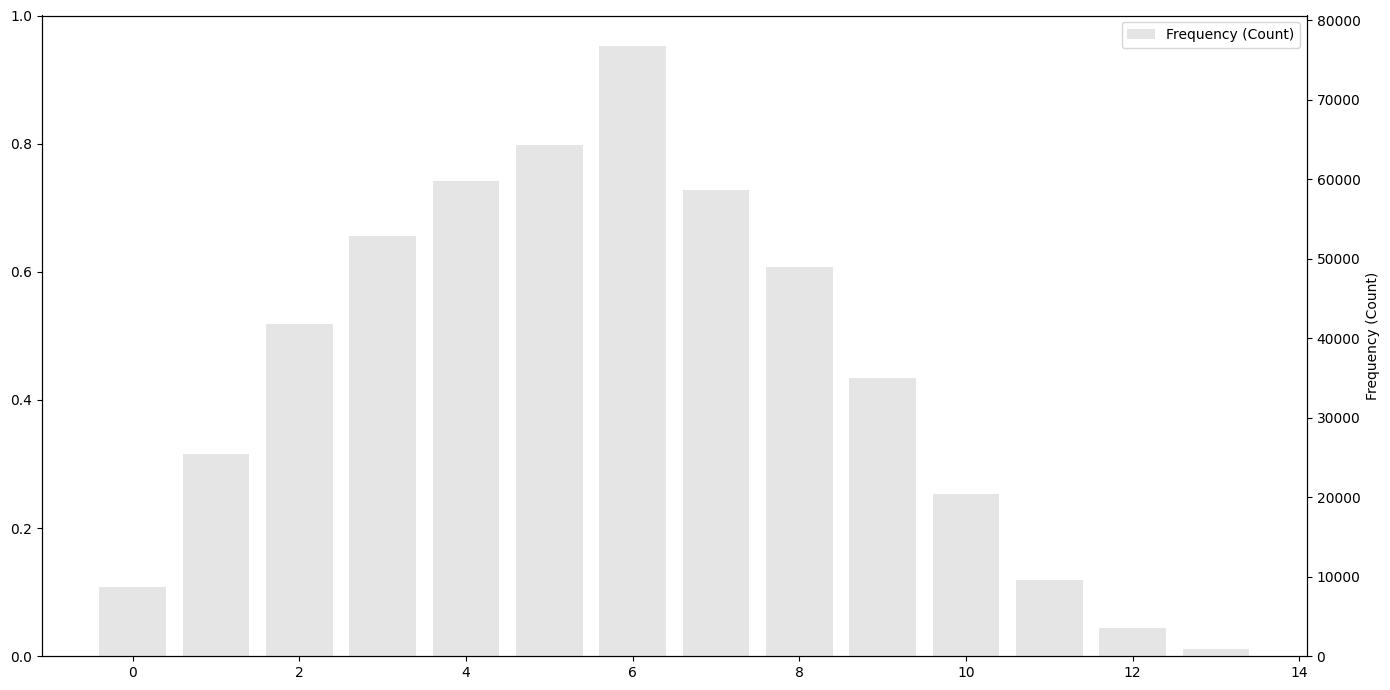

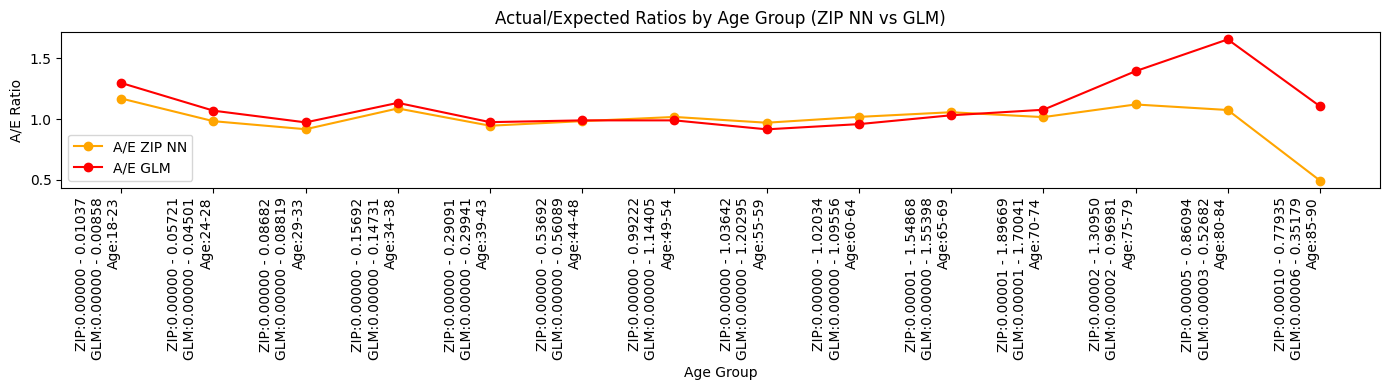

In [219]:
# Double lift plot: Compare ZIP boosted NN predictions vs GLM predictions by age group

def weighted_mean_double(group):
    return pd.Series({
        "weighted_actual": np.average(group["actual"], weights=group["weights"]),
        "weighted_zip": np.average(group["predicted_zip"], weights=group["weights"]),
        "weighted_glm": np.average(group["predicted_glm"], weights=group["weights_glm"]),
        "weighted_expected": np.average(group["expected_glm"], weights=group["weights_glm"]),
        "count": len(group),
        "age_range": f"{group['Age'].min():.0f}-{group['Age'].max():.0f}",
        "range_zip": f"{group['predicted_zip'].min():.5f} - {group['predicted_zip'].max():.5f}",
        "range_glm": f"{group['predicted_glm'].min():.5f} - {group['predicted_glm'].max():.5f}"
    })

double_lift_summary = df_lift_glm.groupby("age_group").apply(weighted_mean_double).reset_index(drop=True)

# Log-transform values for better visualization
double_lift_summary["log_weighted_actual"] = np.log(double_lift_summary["weighted_actual"] + 1e-8)
double_lift_summary["log_weighted_zip"] = np.log(double_lift_summary["weighted_zip"] + 1e-8)
double_lift_summary["log_weighted_glm"] = np.log(double_lift_summary["weighted_glm"] + 1e-8)
double_lift_summary["log_weighted_expected"] = np.log(double_lift_summary["weighted_expected"] + 1e-8)

# Calculate A/E ratios for ZIP NN and GLM
double_lift_summary["AE_zip"] = double_lift_summary["weighted_actual"] / (double_lift_summary["weighted_zip"] + 1e-8)
double_lift_summary["AE_glm"] = double_lift_summary["weighted_actual"] / (double_lift_summary["weighted_glm"] + 1e-8)

xtick_labels = [
    f"ZIP:{rz}\nGLM:{rg}\nAge:{a}" 
    for rz, rg, a in zip(double_lift_summary["range_zip"], double_lift_summary["range_glm"], double_lift_summary["age_range"])
]

fig, ax1 = plt.subplots(figsize=(14, 7))

# Add frequency bar plot on secondary y-axis
ax2 = ax1.twinx()
ax2.bar(range(len(double_lift_summary)), double_lift_summary["count"], color="gray", alpha=0.2, label="Frequency (Count)")
ax2.set_ylabel("Frequency (Count)")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

# Plot A/E ratios for ZIP NN and GLM
plt.figure(figsize=(14, 4))
plt.plot(double_lift_summary["AE_zip"], label="A/E ZIP NN", color="orange", marker="o")
plt.plot(double_lift_summary["AE_glm"], label="A/E GLM", color="red", marker="o")
plt.xlabel("Age Group")
plt.ylabel("A/E Ratio")
plt.title("Actual/Expected Ratios by Age Group (ZIP NN vs GLM)")
plt.xticks(range(len(double_lift_summary)), xtick_labels, rotation=90, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

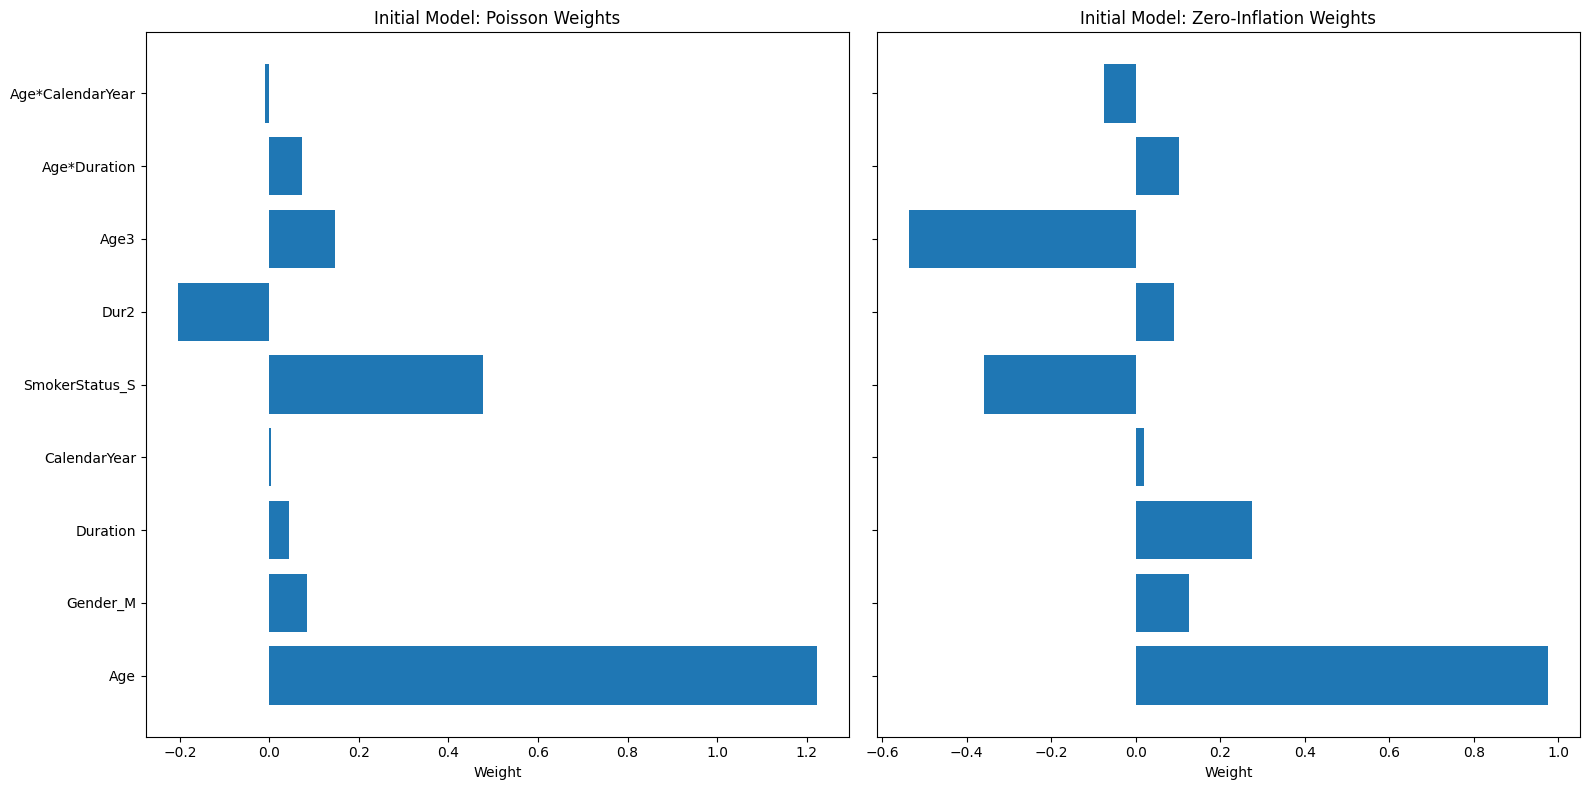

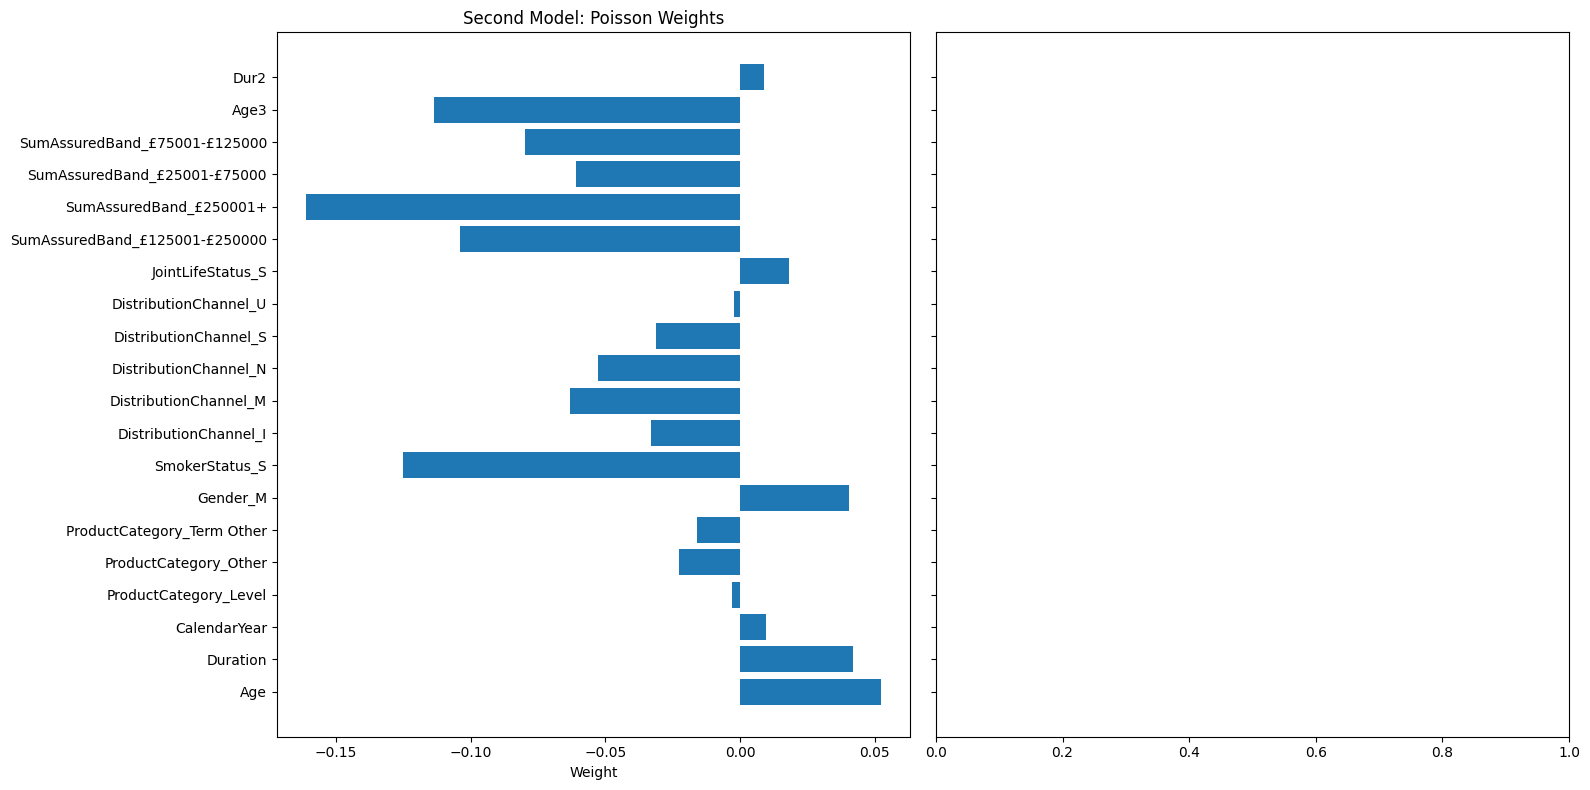

In [101]:
# For initial_model (ZIP): show both Poisson and Zero-Inflation weights
init_weights = initial_model.state_dict()
init_fc2_weights = init_weights["fc2.weight"].detach().cpu().numpy().flatten()
init_fc_zero_weights = init_weights["fc_zero_inflation.weight"].detach().cpu().numpy().flatten()

init_feature_names = list(X_train_initial.columns) + ["Age*Duration", "Age*CalendarYear"]

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
axes[0].barh(init_feature_names, init_fc2_weights)
axes[0].set_title("Initial Model: Poisson Weights")
axes[0].set_xlabel("Weight")

axes[1].barh(init_feature_names, init_fc_zero_weights)
axes[1].set_title("Initial Model: Zero-Inflation Weights")
axes[1].set_xlabel("Weight")

plt.tight_layout()
plt.show()

# For second_model (Poisson): show weights
sec_weights = second_model.state_dict()
sec_fc_weights = sec_weights["fc.weight"].detach().cpu().numpy().flatten()
#sec_fc_zero_weights = sec_weights["fc_zero_inflation.weight"].detach().cpu().numpy().flatten()
sec_feature_names = features_except_age_sex #+ ["Age*Duration", "Age*CalendarYear"]

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
axes[0].barh(sec_feature_names, sec_fc_weights)
axes[0].set_title("Second Model: Poisson Weights")
axes[0].set_xlabel("Weight")
plt.tight_layout()
plt.show()

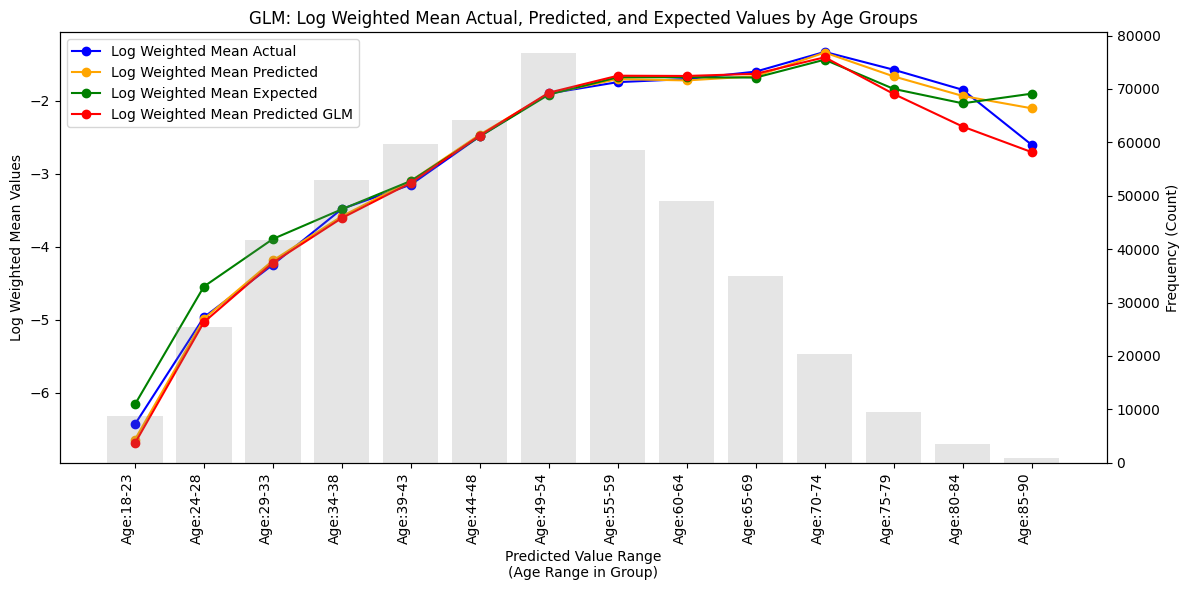

In [102]:
actual_glm = y_test.values
predicted_glm = y_pred_glm if 'y_pred_glm' in locals() else poisson_model_glm.predict(X_test, offset=np.log(test_df["LivesExposure"]))
weights_glm = test_df["LivesExposure"].values
expected_claims_glm = test_df["ExpectedClaims"].values if "ExpectedClaims" in test_df.columns else np.zeros_like(actual_glm)
ages_glm = test_df["Age"].values
initial_model.eval()
second_model.eval()
with torch.no_grad():
    second_outputs = second_model(
        X_test_second_tensor, lives_exposure_test_tensor, initial_predictions_test
    )

y_pred = second_outputs.numpy().flatten()
#actual = y_test_tensor.numpy().flatten()
predicted = np.round(y_pred, 6)
weights = lives_exposure_test_tensor.numpy().flatten()

df_lift_glm = pd.DataFrame({
    "actual": actual_glm,
    "predicted_glm": predicted_glm,
    "Age": ages_glm,
    "expected_glm": expected_claims_glm,
    "weights_glm": weights_glm,
    "predicted_zip": predicted.flatten() if predicted.ndim > 1 else predicted,
    "weights": weights.flatten() if weights.ndim > 1 else weights
})

min_age_glm = int(df_lift_glm["Age"].min())
max_age_glm = int(df_lift_glm["Age"].max())
bins_glm = np.linspace(min_age_glm, max_age_glm, int((max_age_glm-min_age_glm+1)/2)*0+15)
labels_glm = range(len(bins_glm) - 1)
df_lift_glm["age_group"] = pd.cut(df_lift_glm["Age"], bins=bins_glm, labels=labels_glm, include_lowest=True)

def weighted_mean_glm(group):
    # Ensure all arrays are 1D for np.average
    actual = group["actual"].values.flatten()
    predicted_glm = group["predicted_glm"].values.flatten()
    predicted_zip = group["predicted_zip"].values.flatten()
    expected_glm = group["expected_glm"].values.flatten()
    weights_glm = group["weights_glm"].values.flatten()
    weights = group["weights"].values.flatten()
    return pd.Series({
        "weighted_actual": np.average(actual, weights=weights_glm),
        "weighted_predicted_glm": np.average(predicted_glm, weights=weights_glm),
        "weighted_predicted": np.average(predicted_zip, weights=weights),
        "weighted_expected": np.average(expected_glm, weights=weights_glm),
        "range": f"{predicted_glm.min():.5f} - {predicted_glm.max():.5f}",
        "count": len(group),
        "age_range": f"{group['Age'].min():.0f}-{group['Age'].max():.0f}"
    })

age_group_summary_glm = df_lift_glm.groupby("age_group").apply(weighted_mean_glm).reset_index(drop=True)
age_group_summary_glm["log_weighted_actual"] = np.log(age_group_summary_glm["weighted_actual"])
age_group_summary_glm["log_weighted_predicted"] = np.log(age_group_summary_glm["weighted_predicted"])
age_group_summary_glm["log_weighted_expected"] = np.log(age_group_summary_glm["weighted_expected"])
age_group_summary_glm["log_weighted_predicted_glm"] = np.log(age_group_summary_glm["weighted_predicted_glm"])

xtick_labels_glm = [
    f"\nAge:{a}" for r, a in zip(age_group_summary_glm["range"], age_group_summary_glm["age_range"])
]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(age_group_summary_glm["log_weighted_actual"], label="Log Weighted Mean Actual", color="blue", marker="o")
ax1.plot(age_group_summary_glm["log_weighted_predicted"], label="Log Weighted Mean Predicted", color="orange", marker="o")
ax1.plot(age_group_summary_glm["log_weighted_expected"], label="Log Weighted Mean Expected", color="green", marker="o")
ax1.plot(age_group_summary_glm["log_weighted_predicted_glm"], label="Log Weighted Mean Predicted GLM", color="red", marker="o")
ax1.set_xlabel("Predicted Value Range\n(Age Range in Group)")
ax1.set_ylabel("Log Weighted Mean Values")
ax1.set_title("GLM: Log Weighted Mean Actual, Predicted, and Expected Values by Age Groups")
ax1.set_xticks(ticks=range(len(age_group_summary_glm)))
ax1.set_xticklabels(xtick_labels_glm, rotation=90, ha="right")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.bar(range(len(age_group_summary_glm)), age_group_summary_glm["count"], color="gray", alpha=0.2, label="Frequency (Count)")
ax2.set_ylabel("Frequency (Count)")

plt.tight_layout()
plt.show()

parameter tuning for the earlier runs

In [ ]:
def objective(trial, features, df, best_trial_params=None):
    if best_trial_params is None:
        other_best_params = {'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001, 'age_cut': 25, 'age_power': 2.065978965764992, 'age_cut2':35,'age_power2':1.795259099626305,'age_multiplier': 1, 'duration_power': -1.7488155250040655, 'duration_multiplier': 1, 'saturated_r2': 0.28533536195755005}
        lr = other_best_params["lr"]
        weight_decay = other_best_params["weight_decay"]
        num_epochs = other_best_params["num_epochs"]
        lambda_l1 = other_best_params["lambda_l1"]
        #age_cut = trial.suggest_int("age_cut", 20, 90)
        age_cut2 = trial.suggest_int("age_cut2", 20, 80)
        age_power2 = trial.suggest_float("age_power2", 1.1, 5)
        #age_power = trial.suggest_float("age_power", 1.1, 5)
        #age_multiplier = trial.suggest_int("age_multiplier", 0, 1)
        age_multiplier2 = trial.suggest_int("age_multiplier2", 0, 1)
        duration_power = trial.suggest_float("duration_power", -3, 2)
        duration_multiplier = trial.suggest_int("duration_multiplier", 0, 1)
    else:
        lr = best_trial_params["lr"]
        weight_decay = best_trial_params["weight_decay"]
        num_epochs = best_trial_params["num_epochs"]
        lambda_l1 = best_trial_params["lambda_l1"]
        age_cut = best_trial_params["age_cut"]
        age_power = best_trial_params["age_power"]
        age_multiplier = best_trial_params["age_multiplier"]
        duration_power = best_trial_params["duration_power"]
        duration_multiplier = best_trial_params["duration_multiplier"]

    pseudo_r2_scores = []

    for fold in range(1, 2):
        df["Age3"] = 0#np.maximum(age_cut-df["Age"], 0) ** age_power*age_multiplier2
        df["Age2"] = age_multiplier2 * np.maximum(df["Age"] - age_cut2, 0) ** age_power2
        df["Dur2"] = duration_multiplier * np.maximum(df["Duration"] + 1, 0) ** duration_power
        df["LivesExposure"] = df["LivesExposure"].clip(lower=1e-6)
        train_df = df[df["holdout"] == 0]
        test_df = df[~(df["holdout"] == 0)]

        train_lives_exposure = train_df["LivesExposure"]
        test_lives_exposure = test_df["LivesExposure"]

        if "Age2" not in features:
            features.append("Age2")
        if "Dur2" not in features:
            features.append("Dur2")
        if "Age3" not in features:
            features.append("Age3")
        X_train = train_df[features]
        y_train = train_df["IncurredClaims"]
        X_test = test_df[features]
        y_test = test_df["IncurredClaims"]

        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), columns=X_train.columns
        )
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

        X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(
            y_train.values.reshape(-1, 1), dtype=torch.float32
        )
        y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)
        lives_exposure_train_tensor = torch.tensor(
            train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )
        lives_exposure_test_tensor = torch.tensor(
            test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )

        # Initialize the initial ZIP model with interaction terms
        X_train_initial = X_train_scaled[
            ["Age",  "Gender_M", "Duration", "CalendarYear", "SmokerStatus_S","Age2","Dur2","Age3"]
        ]
        X_test_initial = X_test_scaled[
            ["Age",  "Gender_M", "Duration", "CalendarYear", "SmokerStatus_S","Age2","Dur2", "Age3"]
        ]
        # Conrt to tensors
        X_train_initial_tensor = torch.tensor(
            X_train_initial.values, dtype=torch.float32
        )
        X_test_initial_tensor = torch.tensor(X_test_initial.values, dtype=torch.float32)

        initial_model = Mort_Net_ZIP()
        optimizer_initial = optim.Adam(
            initial_model.parameters(), lr=lr, weight_decay=weight_decay
        )

        # Train the initial ZIP model
        for epoch in range(num_epochs):
            optimizer_initial.zero_grad()
            poisson_outputs, zero_inflation_outputs = initial_model(
                X_train_initial_tensor, lives_exposure_train_tensor
            )
            loss = joint_loss(
                poisson_outputs,
                zero_inflation_outputs,
                y_train_tensor,
                lives_exposure_train_tensor,
            )
            loss.backward()
            optimizer_initial.step()

        # Get predictions from the initial model
        with torch.no_grad():
            poisson_outputs, zero_inflation_outputs = initial_model(
                X_train_initial_tensor, lives_exposure_train_tensor
            )
            initial_predictions = poisson_outputs * (1 - zero_inflation_outputs)
            initial_predictions = initial_predictions.detach()

        # Initialize and train the second model with all features except the ones used in the initial model
        features_except_initial = [
            f
            for f in features
            #if f not in ["Age", "Age2", "Gender_M", "Duration", "CalendarYear", "Dur2"]
        ]
        X_train_second = X_train_scaled[features_except_initial]
        X_test_second = X_test_scaled[features_except_initial]

        X_train_second_tensor = torch.tensor(X_train_second.values, dtype=torch.float32)
        X_test_second_tensor = torch.tensor(X_test_second.values, dtype=torch.float32)

        second_model = SecondPoissonModel(len(X_train_second.columns))
        optimizer_second = optim.Adam(
            second_model.parameters(), lr=lr, weight_decay=weight_decay
        )

        for epoch in range(num_epochs):
            optimizer_second.zero_grad()
            second_outputs = second_model(
                X_train_second_tensor, lives_exposure_train_tensor, initial_predictions
            )
            second_loss = weighted_poisson_loss(
                second_outputs, y_train_tensor, lives_exposure_train_tensor
            )
            second_loss.backward()
            optimizer_second.step()

        # Evaluation for the second model
        second_model.eval()
        initial_model.eval()
        with torch.no_grad():
            poisson_outputs_test, zero_inflation_outputs_test = initial_model(
                X_test_initial_tensor, lives_exposure_test_tensor
            )
            initial_predictions_test = poisson_outputs_test * (
                1 - zero_inflation_outputs_test
            )
            initial_predictions_test = initial_predictions_test.detach()
            second_outputs = second_model(
                X_test_second_tensor,
                lives_exposure_test_tensor,
                initial_predictions_test,
            )
            second_loss = weighted_poisson_loss(
                second_outputs, y_test_tensor, lives_exposure_test_tensor
            ) + l1_loss(second_model, lambda_l1=lambda_l1)

            y_pred = second_outputs
            y_test_tensor = y_test_tensor + 1e-8
            weighted_mean_target = torch.sum(
                y_test_tensor 
            ) / torch.sum(lives_exposure_test_tensor)
            predicted_null = lives_exposure_test_tensor * weighted_mean_target
            null_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log((y_test_tensor+1e-25) / predicted_null)
                    - (y_test_tensor - predicted_null)
                )
            )
            model_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log((y_test_tensor+1e-25) / y_pred)
                    - (y_test_tensor - y_pred)
                )
            )
            pseudo_r2 = 1 - (model_deviance / null_deviance)
            pseudo_r2_scores.append(pseudo_r2.item())

    mean_pseudo_r2 = np.mean(pseudo_r2_scores)
    print(f"Mean Pseudo_R2: {mean_pseudo_r2:.4f}")
    return mean_pseudo_r2


# Initial set of features
features = combined_df_encoded.columns.tolist()
features.remove("IncurredClaims")
features.remove("LivesExposure")
features.remove("Actual_deaths_lives")
features.remove("holdout")
features.remove("random_fold")
features.remove("CommencementYear")
features.remove("ExpectedClaims")
features.remove("Expected_deaths_lives")
features.remove("Expected_deaths")
exclude_features = [
   #"DistributionChannel_I",
    #"DistributionChannel_M",
    # "DistributionChannel_N",
    # "DistributionChannel_S",
    # "DistributionChannel_U",
    # "SumAssuredBand_£125001-£250000",
    #"SumAssuredBand_£250001+",
    # "SumAssuredBand_£25001-£75000",
    # "SumAssuredBand_£75001-£125000",
    # "Duration",
    #"ProductCategory_Level",
    #"ProductCategory_Other",
    # "ProductCategory_Term Other",
]
features = [feature for feature in features if feature not in exclude_features1]
df = combined_df_encoded.drop(columns=exclude_features, axis=1)

# Determine the best parameters using Optuna to maximize R2 score of deciles
study_ZIP = optuna.create_study(direction="maximize")
study_ZIP.optimize(
    lambda trial: objective(trial, features, df.sample(frac=0.6, random_state=1)),
    n_trials=20,
)

best_trial = study_ZIP.best_trial
best_trial_params = best_trial.params
best_trial_params["saturated_r2"] = best_trial.value
print(f"best_trial_params {best_trial_params}")


[I 2025-09-21 21:02:43,454] A new study created in memory with name: no-name-796a716e-5e89-454b-8e7c-0e6befb9b5c0
[I 2025-09-21 21:38:03,493] Trial 0 finished with value: 0.2513772249221802 and parameters: {'age_cut2': 73, 'age_power2': 4.279253516400334, 'age_multiplier2': 0, 'duration_power': -2.0270856605148135, 'duration_multiplier': 1}. Best is trial 0 with value: 0.2513772249221802.


Mean Pseudo_R2: 0.2514


[I 2025-09-21 22:11:33,182] Trial 1 finished with value: 0.2513912320137024 and parameters: {'age_cut2': 22, 'age_power2': 1.28676011203339, 'age_multiplier2': 1, 'duration_power': -1.5353198712841993, 'duration_multiplier': 1}. Best is trial 1 with value: 0.2513912320137024.


Mean Pseudo_R2: 0.2514


[I 2025-09-21 22:46:07,604] Trial 2 finished with value: 0.2492188811302185 and parameters: {'age_cut2': 38, 'age_power2': 2.74141632407414, 'age_multiplier2': 1, 'duration_power': 0.6883574404726138, 'duration_multiplier': 1}. Best is trial 1 with value: 0.2513912320137024.


Mean Pseudo_R2: 0.2492


[I 2025-09-21 23:18:10,069] Trial 3 finished with value: 0.2448081374168396 and parameters: {'age_cut2': 36, 'age_power2': 2.245339076857293, 'age_multiplier2': 0, 'duration_power': -0.8108254358511142, 'duration_multiplier': 0}. Best is trial 1 with value: 0.2513912320137024.


Mean Pseudo_R2: 0.2448


[I 2025-09-21 23:49:24,159] Trial 4 finished with value: 0.24975639581680298 and parameters: {'age_cut2': 69, 'age_power2': 1.6631352272465314, 'age_multiplier2': 1, 'duration_power': 1.626198054605534, 'duration_multiplier': 1}. Best is trial 1 with value: 0.2513912320137024.


Mean Pseudo_R2: 0.2498


[I 2025-09-22 08:38:57,452] Trial 5 finished with value: 0.24691808223724365 and parameters: {'age_cut2': 25, 'age_power2': 2.120338481175521, 'age_multiplier2': 1, 'duration_power': 1.3798411589610646, 'duration_multiplier': 1}. Best is trial 1 with value: 0.2513912320137024.


Mean Pseudo_R2: 0.2469


[I 2025-09-22 09:11:53,857] Trial 6 finished with value: 0.020654022693634033 and parameters: {'age_cut2': 72, 'age_power2': 3.7355709824567493, 'age_multiplier2': 1, 'duration_power': -1.0472554473203783, 'duration_multiplier': 1}. Best is trial 1 with value: 0.2513912320137024.


Mean Pseudo_R2: 0.0207


[I 2025-09-22 09:48:35,816] Trial 7 finished with value: 0.2515134811401367 and parameters: {'age_cut2': 38, 'age_power2': 3.8160596568977105, 'age_multiplier2': 0, 'duration_power': -0.97948666632435, 'duration_multiplier': 1}. Best is trial 7 with value: 0.2515134811401367.


Mean Pseudo_R2: 0.2515


[I 2025-09-22 10:27:48,687] Trial 8 finished with value: 0.2495213747024536 and parameters: {'age_cut2': 58, 'age_power2': 3.2804099959775486, 'age_multiplier2': 0, 'duration_power': 1.6931637194391378, 'duration_multiplier': 1}. Best is trial 7 with value: 0.2515134811401367.


Mean Pseudo_R2: 0.2495


[I 2025-09-22 11:06:08,715] Trial 9 finished with value: 0.2452436089515686 and parameters: {'age_cut2': 48, 'age_power2': 2.688558666015808, 'age_multiplier2': 0, 'duration_power': 0.384200180046264, 'duration_multiplier': 0}. Best is trial 7 with value: 0.2515134811401367.


Mean Pseudo_R2: 0.2452


[I 2025-09-22 11:41:35,133] Trial 10 finished with value: 0.24403220415115356 and parameters: {'age_cut2': 50, 'age_power2': 4.99789861191687, 'age_multiplier2': 0, 'duration_power': -2.999471129188324, 'duration_multiplier': 0}. Best is trial 7 with value: 0.2515134811401367.


Mean Pseudo_R2: 0.2440


[I 2025-09-22 12:16:21,950] Trial 11 finished with value: 0.25127530097961426 and parameters: {'age_cut2': 20, 'age_power2': 1.1343003781880623, 'age_multiplier2': 1, 'duration_power': -1.4779869034510968, 'duration_multiplier': 1}. Best is trial 7 with value: 0.2515134811401367.


Mean Pseudo_R2: 0.2513


[I 2025-09-22 12:48:56,666] Trial 12 finished with value: 0.2505096197128296 and parameters: {'age_cut2': 31, 'age_power2': 3.8563626541772096, 'age_multiplier2': 0, 'duration_power': -0.1845084644398905, 'duration_multiplier': 1}. Best is trial 7 with value: 0.2515134811401367.


Mean Pseudo_R2: 0.2505


[I 2025-09-22 13:28:16,165] Trial 13 finished with value: 0.25073742866516113 and parameters: {'age_cut2': 42, 'age_power2': 4.356056892049789, 'age_multiplier2': 1, 'duration_power': -2.154079908118919, 'duration_multiplier': 1}. Best is trial 7 with value: 0.2515134811401367.


Mean Pseudo_R2: 0.2507


[I 2025-09-22 14:09:31,405] Trial 14 finished with value: 0.2452194094657898 and parameters: {'age_cut2': 28, 'age_power2': 3.1797448760341114, 'age_multiplier2': 0, 'duration_power': -0.3257789782999314, 'duration_multiplier': 0}. Best is trial 7 with value: 0.2515134811401367.


Mean Pseudo_R2: 0.2452


[I 2025-09-22 14:46:54,041] Trial 15 finished with value: 0.24989312887191772 and parameters: {'age_cut2': 20, 'age_power2': 3.6818053727844386, 'age_multiplier2': 1, 'duration_power': -1.6219549058571738, 'duration_multiplier': 1}. Best is trial 7 with value: 0.2515134811401367.


Mean Pseudo_R2: 0.2499


[I 2025-09-22 15:26:07,274] Trial 16 finished with value: 0.25049418210983276 and parameters: {'age_cut2': 63, 'age_power2': 1.1626266517954125, 'age_multiplier2': 0, 'duration_power': -2.4198225963493396, 'duration_multiplier': 1}. Best is trial 7 with value: 0.2515134811401367.


Mean Pseudo_R2: 0.2505


[I 2025-09-22 16:04:50,478] Trial 17 finished with value: 0.24519163370132446 and parameters: {'age_cut2': 80, 'age_power2': 1.7752583288951609, 'age_multiplier2': 1, 'duration_power': -1.1842254847566562, 'duration_multiplier': 0}. Best is trial 7 with value: 0.2515134811401367.


Mean Pseudo_R2: 0.2452


[I 2025-09-22 16:46:35,307] Trial 18 finished with value: 0.24891412258148193 and parameters: {'age_cut2': 43, 'age_power2': 4.719197504836924, 'age_multiplier2': 1, 'duration_power': 0.02788082134538783, 'duration_multiplier': 1}. Best is trial 7 with value: 0.2515134811401367.


Mean Pseudo_R2: 0.2489


[I 2025-09-22 17:24:53,677] Trial 19 finished with value: 0.2511666417121887 and parameters: {'age_cut2': 34, 'age_power2': 2.6748096335317446, 'age_multiplier2': 0, 'duration_power': -0.7166730248623668, 'duration_multiplier': 1}. Best is trial 7 with value: 0.2515134811401367.


Mean Pseudo_R2: 0.2512
best_trial_params {'age_cut2': 38, 'age_power2': 3.8160596568977105, 'age_multiplier2': 0, 'duration_power': -0.97948666632435, 'duration_multiplier': 1, 'saturated_r2': 0.2515134811401367}


In [ ]:
def objective(trial, features, df, best_trial_params=None):
    if best_trial_params is None:
        other_best_params = {'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001, 'age_cut': 25, 'age_power': 2.065978965764992, 'age_cut2':35,'age_power2':1.795259099626305,'age_multiplier': 1, 'duration_power': -1.7488155250040655, 'duration_multiplier': 1, 'saturated_r2': 0.28533536195755005}
        lr = other_best_params["lr"]
        weight_decay = other_best_params["weight_decay"]
        num_epochs = other_best_params["num_epochs"]
        lambda_l1 = other_best_params["lambda_l1"]
        #age_cut = trial.suggest_int("age_cut", 20, 90)
        age_cut2 = trial.suggest_int("age_cut2", 30, 80)
        age_power2 = trial.suggest_float("age_power2", 1.1, 3)
        #age_power = trial.suggest_float("age_power", 1.1, 5)
        #age_multiplier = trial.suggest_int("age_multiplier", 0, 1)
        age_multiplier2 = trial.suggest_int("age_multiplier2", 0, 1)
        duration_power = trial.suggest_float("duration_power", -2, 1)
        duration_multiplier = trial.suggest_int("duration_multiplier", 0, 1)
    else:
        lr = best_trial_params["lr"]
        weight_decay = best_trial_params["weight_decay"]
        num_epochs = best_trial_params["num_epochs"]
        lambda_l1 = best_trial_params["lambda_l1"]
        age_cut = best_trial_params["age_cut"]
        age_power = best_trial_params["age_power"]
        age_multiplier = best_trial_params["age_multiplier"]
        duration_power = best_trial_params["duration_power"]
        duration_multiplier = best_trial_params["duration_multiplier"]

    pseudo_r2_scores = []

    for fold in range(1, 2):
        df["Age3"] = 0#np.maximum(age_cut-df["Age"], 0) ** age_power*age_multiplier2
        df["Age2"] = age_multiplier2 * np.maximum(df["Age"] - age_cut2, 0) ** age_power2
        df["Dur2"] = duration_multiplier * np.maximum(df["Duration"] + 1, 0) ** duration_power
        df["LivesExposure"] = df["LivesExposure"].clip(lower=1e-6)
        train_df = df[df["holdout"] == 0]
        test_df = df[~(df["holdout"] == 0)]

        train_lives_exposure = train_df["LivesExposure"]
        test_lives_exposure = test_df["LivesExposure"]

        if "Age2" not in features:
            features.append("Age2")
        if "Dur2" not in features:
            features.append("Dur2")
        if "Age3" not in features:
            features.append("Age3")
        X_train = train_df[features]
        y_train = train_df["IncurredClaims"]
        X_test = test_df[features]
        y_test = test_df["IncurredClaims"]

        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), columns=X_train.columns
        )
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

        X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(
            y_train.values.reshape(-1, 1), dtype=torch.float32
        )
        y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)
        lives_exposure_train_tensor = torch.tensor(
            train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )
        lives_exposure_test_tensor = torch.tensor(
            test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )

        # Initialize the initial ZIP model with interaction terms
        X_train_initial = X_train_scaled[
            ["Age",  "Gender_M", "Duration", "CalendarYear", "SmokerStatus_S","Age2","Dur2","Age3"]
        ]
        X_test_initial = X_test_scaled[
            ["Age",  "Gender_M", "Duration", "CalendarYear", "SmokerStatus_S","Age2","Dur2", "Age3"]
        ]
        # Conrt to tensors
        X_train_initial_tensor = torch.tensor(
            X_train_initial.values, dtype=torch.float32
        )
        X_test_initial_tensor = torch.tensor(X_test_initial.values, dtype=torch.float32)

        initial_model = Mort_Net_ZIP()
        optimizer_initial = optim.Adam(
            initial_model.parameters(), lr=lr, weight_decay=weight_decay
        )

        # Train the initial ZIP model
        for epoch in range(num_epochs):
            optimizer_initial.zero_grad()
            poisson_outputs, zero_inflation_outputs = initial_model(
                X_train_initial_tensor, lives_exposure_train_tensor
            )
            loss = joint_loss(
                poisson_outputs,
                zero_inflation_outputs,
                y_train_tensor,
                lives_exposure_train_tensor,
            )
            loss.backward()
            optimizer_initial.step()

        # Get predictions from the initial model
        with torch.no_grad():
            poisson_outputs, zero_inflation_outputs = initial_model(
                X_train_initial_tensor, lives_exposure_train_tensor
            )
            initial_predictions = poisson_outputs * (1 - zero_inflation_outputs)
            initial_predictions = initial_predictions.detach()

        # Initialize and train the second model with all features except the ones used in the initial model
        features_except_initial = [
            f
            for f in features
            #if f not in ["Age", "Age2", "Gender_M", "Duration", "CalendarYear", "Dur2"]
        ]
        X_train_second = X_train_scaled[features_except_initial]
        X_test_second = X_test_scaled[features_except_initial]

        X_train_second_tensor = torch.tensor(X_train_second.values, dtype=torch.float32)
        X_test_second_tensor = torch.tensor(X_test_second.values, dtype=torch.float32)

        second_model = SecondPoissonModel(len(X_train_second.columns))
        optimizer_second = optim.Adam(
            second_model.parameters(), lr=lr, weight_decay=weight_decay
        )

        for epoch in range(num_epochs):
            optimizer_second.zero_grad()
            second_outputs = second_model(
                X_train_second_tensor, lives_exposure_train_tensor, initial_predictions
            )
            second_loss = weighted_poisson_loss(
                second_outputs, y_train_tensor, lives_exposure_train_tensor
            )
            second_loss.backward()
            optimizer_second.step()

        # Evaluation for the second model
        second_model.eval()
        initial_model.eval()
        with torch.no_grad():
            poisson_outputs_test, zero_inflation_outputs_test = initial_model(
                X_test_initial_tensor, lives_exposure_test_tensor
            )
            initial_predictions_test = poisson_outputs_test * (
                1 - zero_inflation_outputs_test
            )
            initial_predictions_test = initial_predictions_test.detach()
            second_outputs = second_model(
                X_test_second_tensor,
                lives_exposure_test_tensor,
                initial_predictions_test,
            )
            second_loss = weighted_poisson_loss(
                second_outputs, y_test_tensor, lives_exposure_test_tensor
            ) + l1_loss(second_model, lambda_l1=lambda_l1)

            y_pred = second_outputs
            y_test_tensor = y_test_tensor + 1e-8
            weighted_mean_target = torch.sum(
                y_test_tensor 
            ) / torch.sum(lives_exposure_test_tensor)
            predicted_null = lives_exposure_test_tensor * weighted_mean_target
            null_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log((y_test_tensor+1e-25) / predicted_null)
                    - (y_test_tensor - predicted_null)
                )
            )
            model_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log((y_test_tensor+1e-25) / y_pred)
                    - (y_test_tensor - y_pred)
                )
            )
            pseudo_r2 = 1 - (model_deviance / null_deviance)
            pseudo_r2_scores.append(pseudo_r2.item())

    mean_pseudo_r2 = np.mean(pseudo_r2_scores)
    print(f"Mean Pseudo_R2: {mean_pseudo_r2:.4f}")
    return mean_pseudo_r2


# Initial set of features
features = combined_df_encoded.columns.tolist()
features.remove("IncurredClaims")
features.remove("LivesExposure")
features.remove("Actual_deaths_lives")
features.remove("holdout")
features.remove("random_fold")
features.remove("CommencementYear")
features.remove("ExpectedClaims")
features.remove("Expected_deaths_lives")
features.remove("Expected_deaths")
exclude_features = [
   #"DistributionChannel_I",
    #"DistributionChannel_M",
    # "DistributionChannel_N",
    # "DistributionChannel_S",
    # "DistributionChannel_U",
    # "SumAssuredBand_£125001-£250000",
    #"SumAssuredBand_£250001+",
    # "SumAssuredBand_£25001-£75000",
    # "SumAssuredBand_£75001-£125000",
    # "Duration",
    #"ProductCategory_Level",
    #"ProductCategory_Other",
    # "ProductCategory_Term Other",
]
features = [feature for feature in features if feature not in exclude_features1]
df = combined_df_encoded.drop(columns=exclude_features, axis=1)

# Determine the best parameters using Optuna to maximize R2 score of deciles
study_ZIP = optuna.create_study(direction="maximize")
study_ZIP.optimize(
    lambda trial: objective(trial, features, df.sample(frac=0.6, random_state=1)),
    n_trials=20,
)

best_trial = study_ZIP.best_trial
best_trial_params = best_trial.params
best_trial_params["saturated_r2"] = best_trial.value
print(f"best_trial_params {best_trial_params}")


[I 2025-09-28 20:13:09,605] A new study created in memory with name: no-name-e7d119be-1613-453b-ac25-b5b11a4e32ad
[I 2025-09-28 20:55:00,588] Trial 0 finished with value: 0.2439853549003601 and parameters: {'age_cut2': 64, 'age_power2': 1.7932732903345279, 'age_multiplier2': 0, 'duration_power': 0.9834763365124664, 'duration_multiplier': 1}. Best is trial 0 with value: 0.2439853549003601.


Mean Pseudo_R2: 0.2440


[I 2025-09-28 21:32:38,052] Trial 1 finished with value: 0.25035566091537476 and parameters: {'age_cut2': 70, 'age_power2': 2.112192134716374, 'age_multiplier2': 0, 'duration_power': 0.001201253364632393, 'duration_multiplier': 1}. Best is trial 1 with value: 0.25035566091537476.


Mean Pseudo_R2: 0.2504


[I 2025-09-28 22:08:13,414] Trial 2 finished with value: 0.2453547716140747 and parameters: {'age_cut2': 72, 'age_power2': 1.6796202240715008, 'age_multiplier2': 1, 'duration_power': 0.1693900436329292, 'duration_multiplier': 0}. Best is trial 1 with value: 0.25035566091537476.


Mean Pseudo_R2: 0.2454


[I 2025-09-28 22:43:32,636] Trial 3 finished with value: 0.2452130913734436 and parameters: {'age_cut2': 58, 'age_power2': 2.7419000822682733, 'age_multiplier2': 0, 'duration_power': 0.7936364086639855, 'duration_multiplier': 0}. Best is trial 1 with value: 0.25035566091537476.


Mean Pseudo_R2: 0.2452


[I 2025-09-28 23:19:18,332] Trial 4 finished with value: 0.2403322458267212 and parameters: {'age_cut2': 78, 'age_power2': 1.1565162370380444, 'age_multiplier2': 1, 'duration_power': -0.7986345905431218, 'duration_multiplier': 0}. Best is trial 1 with value: 0.25035566091537476.


Mean Pseudo_R2: 0.2403


[I 2025-09-28 23:50:15,938] Trial 5 finished with value: 0.245233952999115 and parameters: {'age_cut2': 46, 'age_power2': 2.043245443437069, 'age_multiplier2': 0, 'duration_power': -1.8365524196454959, 'duration_multiplier': 0}. Best is trial 1 with value: 0.25035566091537476.


Mean Pseudo_R2: 0.2452


[I 2025-09-29 09:27:34,204] Trial 6 finished with value: 0.25159257650375366 and parameters: {'age_cut2': 58, 'age_power2': 2.3846788079846934, 'age_multiplier2': 0, 'duration_power': -0.8431526694559395, 'duration_multiplier': 1}. Best is trial 6 with value: 0.25159257650375366.


Mean Pseudo_R2: 0.2516


[I 2025-09-29 10:00:22,371] Trial 7 finished with value: 0.2505815029144287 and parameters: {'age_cut2': 79, 'age_power2': 2.153929692227527, 'age_multiplier2': 0, 'duration_power': -0.32964695705943603, 'duration_multiplier': 1}. Best is trial 6 with value: 0.25159257650375366.


Mean Pseudo_R2: 0.2506


[I 2025-09-29 10:38:24,138] Trial 8 finished with value: 0.24525994062423706 and parameters: {'age_cut2': 38, 'age_power2': 2.3123178330059417, 'age_multiplier2': 0, 'duration_power': -0.9348465751273385, 'duration_multiplier': 0}. Best is trial 6 with value: 0.25159257650375366.


Mean Pseudo_R2: 0.2453


[I 2025-09-29 11:15:29,956] Trial 9 finished with value: 0.25160646438598633 and parameters: {'age_cut2': 43, 'age_power2': 2.552903682315777, 'age_multiplier2': 0, 'duration_power': -1.009249548048718, 'duration_multiplier': 1}. Best is trial 9 with value: 0.25160646438598633.


Mean Pseudo_R2: 0.2516


[I 2025-09-29 11:53:59,017] Trial 10 finished with value: 0.250569224357605 and parameters: {'age_cut2': 31, 'age_power2': 2.958764456488517, 'age_multiplier2': 1, 'duration_power': -1.6866758431724063, 'duration_multiplier': 1}. Best is trial 9 with value: 0.25160646438598633.


Mean Pseudo_R2: 0.2506


[I 2025-09-29 12:27:52,929] Trial 11 finished with value: 0.2516699433326721 and parameters: {'age_cut2': 49, 'age_power2': 2.538752691168995, 'age_multiplier2': 0, 'duration_power': -1.2241909443550256, 'duration_multiplier': 1}. Best is trial 11 with value: 0.2516699433326721.


Mean Pseudo_R2: 0.2517


[I 2025-09-29 13:01:01,378] Trial 12 finished with value: 0.25160419940948486 and parameters: {'age_cut2': 46, 'age_power2': 2.619194788577637, 'age_multiplier2': 0, 'duration_power': -1.4144681953187193, 'duration_multiplier': 1}. Best is trial 11 with value: 0.2516699433326721.


Mean Pseudo_R2: 0.2516


[I 2025-09-29 13:42:24,289] Trial 13 finished with value: 0.25012606382369995 and parameters: {'age_cut2': 48, 'age_power2': 2.599199381818843, 'age_multiplier2': 0, 'duration_power': -1.338992745854307, 'duration_multiplier': 1}. Best is trial 11 with value: 0.2516699433326721.


Mean Pseudo_R2: 0.2501


[I 2025-09-29 14:19:10,354] Trial 14 finished with value: 0.2502583861351013 and parameters: {'age_cut2': 40, 'age_power2': 2.9256144071134793, 'age_multiplier2': 1, 'duration_power': -1.1891345343967503, 'duration_multiplier': 1}. Best is trial 11 with value: 0.2516699433326721.


Mean Pseudo_R2: 0.2503


[I 2025-09-29 14:54:49,650] Trial 15 finished with value: 0.2515072226524353 and parameters: {'age_cut2': 52, 'age_power2': 2.460507248510097, 'age_multiplier2': 0, 'duration_power': -0.4480670662946511, 'duration_multiplier': 1}. Best is trial 11 with value: 0.2516699433326721.


Mean Pseudo_R2: 0.2515


[I 2025-09-29 15:34:03,997] Trial 16 finished with value: 0.2515414357185364 and parameters: {'age_cut2': 37, 'age_power2': 2.726059270459332, 'age_multiplier2': 0, 'duration_power': -1.62940557061627, 'duration_multiplier': 1}. Best is trial 11 with value: 0.2516699433326721.


Mean Pseudo_R2: 0.2515


[I 2025-09-29 16:13:32,167] Trial 17 finished with value: 0.2512339949607849 and parameters: {'age_cut2': 52, 'age_power2': 1.8098948441010918, 'age_multiplier2': 1, 'duration_power': -1.0467611250456397, 'duration_multiplier': 1}. Best is trial 11 with value: 0.2516699433326721.


Mean Pseudo_R2: 0.2512


[I 2025-09-29 16:47:16,007] Trial 18 finished with value: 0.25102388858795166 and parameters: {'age_cut2': 30, 'age_power2': 2.2626129823182755, 'age_multiplier2': 0, 'duration_power': -1.9522201465505615, 'duration_multiplier': 1}. Best is trial 11 with value: 0.2516699433326721.


Mean Pseudo_R2: 0.2510


[I 2025-09-29 17:20:01,220] Trial 19 finished with value: 0.25010931491851807 and parameters: {'age_cut2': 42, 'age_power2': 1.3615739769444073, 'age_multiplier2': 0, 'duration_power': -0.622858636069271, 'duration_multiplier': 1}. Best is trial 11 with value: 0.2516699433326721.


Mean Pseudo_R2: 0.2501
best_trial_params {'age_cut2': 49, 'age_power2': 2.538752691168995, 'age_multiplier2': 0, 'duration_power': -1.2241909443550256, 'duration_multiplier': 1, 'saturated_r2': 0.2516699433326721}


In [ ]:
def objective(trial, features, df, best_trial_params=None):
    if best_trial_params is None:
        other_best_params = {'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001, 'age_cut': 25, 'age_power': 2.065978965764992, 'age_cut2':35,'age_power2':1.795259099626305,'age_multiplier': 1, 'duration_power': -1.7488155250040655, 'duration_multiplier': 1, 'saturated_r2': 0.28533536195755005}
        lr = other_best_params["lr"]
        weight_decay = other_best_params["weight_decay"]
        num_epochs = other_best_params["num_epochs"]
        lambda_l1 = other_best_params["lambda_l1"]
        #age_cut = trial.suggest_int("age_cut", 20, 90)
        age_cut2 = trial.suggest_int("age_cut2", 20, 80)
        age_power2 = trial.suggest_float("age_power2", 1.1, 5)
        #age_power = trial.suggest_float("age_power", 1.1, 5)
        #age_multiplier = trial.suggest_int("age_multiplier", 0, 1)
        age_multiplier2 = trial.suggest_int("age_multiplier2", 0, 1)
        duration_power = trial.suggest_float("duration_power", -3, 2)
        duration_multiplier = trial.suggest_int("duration_multiplier", 0, 1)
    else:
        lr = best_trial_params["lr"]
        weight_decay = best_trial_params["weight_decay"]
        num_epochs = best_trial_params["num_epochs"]
        lambda_l1 = best_trial_params["lambda_l1"]
        age_cut = best_trial_params["age_cut"]
        age_power = best_trial_params["age_power"]
        age_multiplier = best_trial_params["age_multiplier"]
        duration_power = best_trial_params["duration_power"]
        duration_multiplier = best_trial_params["duration_multiplier"]

    pseudo_r2_scores = []

    for fold in range(1, 2):
        df["Age3"] = 0#np.maximum(age_cut-df["Age"], 0) ** age_power*age_multiplier2
        df["Age2"] = age_multiplier2 * np.maximum(df["Age"] - age_cut2, 0) ** age_power2
        df["Dur2"] = duration_multiplier * np.maximum(df["Duration"] + 1, 0) ** duration_power
        df["LivesExposure"] = df["LivesExposure"].clip(lower=1e-6)
        train_df = df[df["holdout"] == 0]
        test_df = df[~(df["holdout"] == 0)]

        train_lives_exposure = train_df["LivesExposure"]
        test_lives_exposure = test_df["LivesExposure"]

        if "Age2" not in features:
            features.append("Age2")
        if "Dur2" not in features:
            features.append("Dur2")
        if "Age3" not in features:
            features.append("Age3")
        X_train = train_df[features]
        y_train = train_df["IncurredClaims"]
        X_test = test_df[features]
        y_test = test_df["IncurredClaims"]

        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), columns=X_train.columns
        )
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

        X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(
            y_train.values.reshape(-1, 1), dtype=torch.float32
        )
        y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)
        lives_exposure_train_tensor = torch.tensor(
            train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )
        lives_exposure_test_tensor = torch.tensor(
            test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )

        # Initialize the initial ZIP model with interaction terms
        X_train_initial = X_train_scaled[
            ["Age",  "Gender_M", "Duration", "CalendarYear", "SmokerStatus_S","Age2","Dur2","Age3"]
        ]
        X_test_initial = X_test_scaled[
            ["Age",  "Gender_M", "Duration", "CalendarYear", "SmokerStatus_S","Age2","Dur2", "Age3"]
        ]
        # Conrt to tensors
        X_train_initial_tensor = torch.tensor(
            X_train_initial.values, dtype=torch.float32
        )
        X_test_initial_tensor = torch.tensor(X_test_initial.values, dtype=torch.float32)

        initial_model = Mort_Net_ZIP()
        optimizer_initial = optim.Adam(
            initial_model.parameters(), lr=lr, weight_decay=weight_decay
        )

        # Train the initial ZIP model
        for epoch in range(num_epochs):
            optimizer_initial.zero_grad()
            poisson_outputs, zero_inflation_outputs = initial_model(
                X_train_initial_tensor, lives_exposure_train_tensor
            )
            loss = joint_loss(
                poisson_outputs,
                zero_inflation_outputs,
                y_train_tensor,
                lives_exposure_train_tensor,
            )
            loss.backward()
            optimizer_initial.step()

        # Get predictions from the initial model
        with torch.no_grad():
            poisson_outputs, zero_inflation_outputs = initial_model(
                X_train_initial_tensor, lives_exposure_train_tensor
            )
            initial_predictions = poisson_outputs * (1 - zero_inflation_outputs)
            initial_predictions = initial_predictions.detach()

        # Initialize and train the second model with all features except the ones used in the initial model
        features_except_initial = [
            f
            for f in features
            #if f not in ["Age", "Age2", "Gender_M", "Duration", "CalendarYear", "Dur2"]
        ]
        X_train_second = X_train_scaled[features_except_initial]
        X_test_second = X_test_scaled[features_except_initial]

        X_train_second_tensor = torch.tensor(X_train_second.values, dtype=torch.float32)
        X_test_second_tensor = torch.tensor(X_test_second.values, dtype=torch.float32)

        second_model = SecondPoissonModel(len(X_train_second.columns))
        optimizer_second = optim.Adam(
            second_model.parameters(), lr=lr, weight_decay=weight_decay
        )

        for epoch in range(num_epochs):
            optimizer_second.zero_grad()
            second_outputs = second_model(
                X_train_second_tensor, lives_exposure_train_tensor, initial_predictions
            )
            second_loss = weighted_poisson_loss(
                second_outputs, y_train_tensor, lives_exposure_train_tensor
            )
            second_loss.backward()
            optimizer_second.step()

        # Evaluation for the second model
        second_model.eval()
        initial_model.eval()
        with torch.no_grad():
            poisson_outputs_test, zero_inflation_outputs_test = initial_model(
                X_test_initial_tensor, lives_exposure_test_tensor
            )
            initial_predictions_test = poisson_outputs_test * (
                1 - zero_inflation_outputs_test
            )
            initial_predictions_test = initial_predictions_test.detach()
            second_outputs = second_model(
                X_test_second_tensor,
                lives_exposure_test_tensor,
                initial_predictions_test,
            )
            second_loss = weighted_poisson_loss(
                second_outputs, y_test_tensor, lives_exposure_test_tensor
            ) + l1_loss(second_model, lambda_l1=lambda_l1)

            y_pred = second_outputs
            y_test_tensor = y_test_tensor + 1e-8
            weighted_mean_target = torch.sum(
                y_test_tensor 
            ) / torch.sum(lives_exposure_test_tensor)
            predicted_null = lives_exposure_test_tensor * weighted_mean_target
            null_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log((y_test_tensor+1e-25) / predicted_null)
                    - (y_test_tensor - predicted_null)
                )
            )
            model_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log((y_test_tensor+1e-25) / y_pred)
                    - (y_test_tensor - y_pred)
                )
            )
            pseudo_r2 = 1 - (model_deviance / null_deviance)
            pseudo_r2_scores.append(pseudo_r2.item())

    mean_pseudo_r2 = np.mean(pseudo_r2_scores)
    print(f"Mean Pseudo_R2: {mean_pseudo_r2:.4f}")
    return mean_pseudo_r2


# Initial set of features
features = combined_df_encoded.columns.tolist()
features.remove("IncurredClaims")
features.remove("LivesExposure")
features.remove("Actual_deaths_lives")
features.remove("holdout")
features.remove("random_fold")
features.remove("CommencementYear")
features.remove("ExpectedClaims")
features.remove("Expected_deaths_lives")
features.remove("Expected_deaths")
exclude_features = [
   #"DistributionChannel_I",
    #"DistributionChannel_M",
    # "DistributionChannel_N",
    # "DistributionChannel_S",
    # "DistributionChannel_U",
    # "SumAssuredBand_£125001-£250000",
    #"SumAssuredBand_£250001+",
    # "SumAssuredBand_£25001-£75000",
    # "SumAssuredBand_£75001-£125000",
    # "Duration",
    #"ProductCategory_Level",
    #"ProductCategory_Other",
    # "ProductCategory_Term Other",
]
features = [feature for feature in features if feature not in exclude_features1]
df = combined_df_encoded.drop(columns=exclude_features, axis=1)

# Determine the best parameters using Optuna to maximize R2 score of deciles
study_ZIP = optuna.create_study(direction="maximize")
study_ZIP.optimize(
    lambda trial: objective(trial, features, df.sample(frac=0.8, random_state=1)),
    n_trials=20,
)

best_trial = study_ZIP.best_trial
best_trial_params = best_trial.params
best_trial_params["saturated_r2"] = best_trial.value
print(f"best_trial_params {best_trial_params}")


[I 2025-09-26 21:14:16,368] A new study created in memory with name: no-name-70de720a-76dd-4d80-bcf1-5beb089beb32
[I 2025-09-26 22:20:13,126] Trial 0 finished with value: 0.2357211709022522 and parameters: {'age_cut2': 79, 'age_power2': 2.7829417387888995, 'age_multiplier2': 0, 'duration_power': -2.3114830998134224, 'duration_multiplier': 0}. Best is trial 0 with value: 0.2357211709022522.


Mean Pseudo_R2: 0.2357


[I 2025-09-26 23:03:03,563] Trial 1 finished with value: 0.23887598514556885 and parameters: {'age_cut2': 38, 'age_power2': 1.3264118691013929, 'age_multiplier2': 1, 'duration_power': -0.6009782029982418, 'duration_multiplier': 1}. Best is trial 1 with value: 0.23887598514556885.


Mean Pseudo_R2: 0.2389


[I 2025-09-26 23:45:28,818] Trial 2 finished with value: 0.23533415794372559 and parameters: {'age_cut2': 25, 'age_power2': 3.0924409354957296, 'age_multiplier2': 0, 'duration_power': 1.89333460947831, 'duration_multiplier': 0}. Best is trial 1 with value: 0.23887598514556885.


Mean Pseudo_R2: 0.2353


[I 2025-09-27 07:58:11,003] Trial 3 finished with value: 0.23273420333862305 and parameters: {'age_cut2': 74, 'age_power2': 1.440636117187367, 'age_multiplier2': 0, 'duration_power': -0.28278952414906255, 'duration_multiplier': 0}. Best is trial 1 with value: 0.23887598514556885.


Mean Pseudo_R2: 0.2327


[I 2025-09-27 08:41:37,729] Trial 4 finished with value: 0.2349798083305359 and parameters: {'age_cut2': 25, 'age_power2': 2.5007680130682215, 'age_multiplier2': 1, 'duration_power': 0.26307521328759265, 'duration_multiplier': 0}. Best is trial 1 with value: 0.23887598514556885.


Mean Pseudo_R2: 0.2350


[I 2025-09-27 09:23:40,825] Trial 5 finished with value: 0.23500287532806396 and parameters: {'age_cut2': 65, 'age_power2': 3.81658994759306, 'age_multiplier2': 1, 'duration_power': 1.9341024188985392, 'duration_multiplier': 1}. Best is trial 1 with value: 0.23887598514556885.


Mean Pseudo_R2: 0.2350


[I 2025-09-27 17:00:50,319] Trial 6 finished with value: 0.23409467935562134 and parameters: {'age_cut2': 49, 'age_power2': 1.734345251719274, 'age_multiplier2': 1, 'duration_power': 0.5595421538342982, 'duration_multiplier': 0}. Best is trial 1 with value: 0.23887598514556885.


Mean Pseudo_R2: 0.2341


[I 2025-09-27 17:55:06,552] Trial 7 finished with value: 0.24111294746398926 and parameters: {'age_cut2': 73, 'age_power2': 2.581517734152385, 'age_multiplier2': 1, 'duration_power': -2.40431213940583, 'duration_multiplier': 1}. Best is trial 7 with value: 0.24111294746398926.


Mean Pseudo_R2: 0.2411


[I 2025-09-27 18:45:33,089] Trial 8 finished with value: 0.21703147888183594 and parameters: {'age_cut2': 63, 'age_power2': 4.934144236374647, 'age_multiplier2': 1, 'duration_power': -0.35131466588133486, 'duration_multiplier': 1}. Best is trial 7 with value: 0.24111294746398926.


Mean Pseudo_R2: 0.2170


[I 2025-09-27 19:37:29,593] Trial 9 finished with value: 0.2415328025817871 and parameters: {'age_cut2': 49, 'age_power2': 4.636071487968217, 'age_multiplier2': 1, 'duration_power': -1.5612518467907566, 'duration_multiplier': 1}. Best is trial 9 with value: 0.2415328025817871.


Mean Pseudo_R2: 0.2415


[I 2025-09-27 20:34:27,410] Trial 10 finished with value: 0.2408953309059143 and parameters: {'age_cut2': 46, 'age_power2': 4.969972763802239, 'age_multiplier2': 0, 'duration_power': -1.4136948844358903, 'duration_multiplier': 1}. Best is trial 9 with value: 0.2415328025817871.


Mean Pseudo_R2: 0.2409


[I 2025-09-27 21:32:19,462] Trial 11 finished with value: 0.2409762144088745 and parameters: {'age_cut2': 60, 'age_power2': 3.936319921307362, 'age_multiplier2': 1, 'duration_power': -2.9692878364489683, 'duration_multiplier': 1}. Best is trial 9 with value: 0.2415328025817871.


Mean Pseudo_R2: 0.2410


[I 2025-09-27 22:21:21,777] Trial 12 finished with value: 0.2412036657333374 and parameters: {'age_cut2': 38, 'age_power2': 3.652472033072776, 'age_multiplier2': 1, 'duration_power': -1.721841161015036, 'duration_multiplier': 1}. Best is trial 9 with value: 0.2415328025817871.


Mean Pseudo_R2: 0.2412


[I 2025-09-27 23:05:49,069] Trial 13 finished with value: 0.24133598804473877 and parameters: {'age_cut2': 37, 'age_power2': 4.243999048324122, 'age_multiplier2': 1, 'duration_power': -1.437910884240356, 'duration_multiplier': 1}. Best is trial 9 with value: 0.2415328025817871.


Mean Pseudo_R2: 0.2413


[I 2025-09-27 23:47:38,243] Trial 14 finished with value: 0.24082690477371216 and parameters: {'age_cut2': 35, 'age_power2': 4.389114658979344, 'age_multiplier2': 1, 'duration_power': -1.275690836121494, 'duration_multiplier': 1}. Best is trial 9 with value: 0.2415328025817871.


Mean Pseudo_R2: 0.2408


[I 2025-09-28 09:14:23,131] Trial 15 finished with value: 0.2414035201072693 and parameters: {'age_cut2': 56, 'age_power2': 4.32988442059429, 'age_multiplier2': 1, 'duration_power': -1.1086433848282327, 'duration_multiplier': 1}. Best is trial 9 with value: 0.2415328025817871.


Mean Pseudo_R2: 0.2414


[I 2025-09-28 09:56:13,782] Trial 16 finished with value: 0.24129027128219604 and parameters: {'age_cut2': 55, 'age_power2': 4.444615436818934, 'age_multiplier2': 1, 'duration_power': -0.8465067030670371, 'duration_multiplier': 1}. Best is trial 9 with value: 0.2415328025817871.


Mean Pseudo_R2: 0.2413


[I 2025-09-28 10:38:24,938] Trial 17 finished with value: 0.2411893606185913 and parameters: {'age_cut2': 46, 'age_power2': 3.3612128303623696, 'age_multiplier2': 0, 'duration_power': -2.0869290406525614, 'duration_multiplier': 1}. Best is trial 9 with value: 0.2415328025817871.


Mean Pseudo_R2: 0.2412


[I 2025-09-28 11:19:30,489] Trial 18 finished with value: 0.23677152395248413 and parameters: {'age_cut2': 55, 'age_power2': 4.61881618565239, 'age_multiplier2': 1, 'duration_power': 0.9693913179879357, 'duration_multiplier': 1}. Best is trial 9 with value: 0.2415328025817871.


Mean Pseudo_R2: 0.2368


[I 2025-09-28 12:00:20,965] Trial 19 finished with value: 0.2415294647216797 and parameters: {'age_cut2': 55, 'age_power2': 4.106811719215745, 'age_multiplier2': 1, 'duration_power': -0.9754026468027106, 'duration_multiplier': 1}. Best is trial 9 with value: 0.2415328025817871.


Mean Pseudo_R2: 0.2415
best_trial_params {'age_cut2': 49, 'age_power2': 4.636071487968217, 'age_multiplier2': 1, 'duration_power': -1.5612518467907566, 'duration_multiplier': 1, 'saturated_r2': 0.2415328025817871}


### Summary of the First Poisson Model

#### Model Overview
The first Poisson model is a Poisson regression model with interaction terms. It is designed to predict incurred claims based on various features, including age and other demographic and policy-related variables.

#### Features Used
- Age
- Age2 (transformed age feature)
- Age3 (another transformed age feature)
- Gender_M
- Duration
- CalendarYear
- JointLifeStatus_S

#### Type of Model
- **Type**: Poisson Regression with Interaction Terms

#### Steps Involved
1. **Data Preparation**:
   - Create new features `Age2` and `Age3` based on age cutoffs and powers.
   - Clip the `LivesExposure` column to avoid very small values.
   - Split the data into training and testing sets based on the `holdout` column.
   - Scale the features using `StandardScaler`.

2. **Convert Data to Tensors**:
   - Convert the scaled features and target variables to PyTorch tensors.

3. **Define the Poisson Model with Interactions**:
   - Create a class `PoissonModelWithInteractions` that defines the Poisson model with interaction terms.
   - Implement the forward method to compute the interaction terms and the final output.

4. **Train the Poisson Model**:
   - Initialize and train the Poisson model using the Adam optimizer.
   - Print the loss every 20 epochs.

5. **Get Predictions from the Poisson Model**:
   - Compute predictions on the training and testing sets.
   - Calculate the pseudo R2 for the initial model.

#### Results
- **Pseudo R2 for Initial Model**: Calculated and printed during training. This metric indicates the goodness of fit of the model.

This summary provides an overview of the first Poisson model, including the features used, the type of model, the steps involved in training, and the results obtained.

In [ ]:
difference_init = (y_train_tensor - initial_predictions) / lives_exposure_train_tensor
second_model.eval()
with torch.no_grad():
    second_outputs_train = second_model(
        X_train_second_tensor, lives_exposure_train_tensor, initial_predictions
    )
difference_final = (y_train_tensor - second_outputs_train) / lives_exposure_train_tensor
difference_np = difference_init.detach().numpy().flatten()
difference_fn = difference_final.detach().numpy().flatten()
X_train_np = X_train_tensor.numpy()

# Convert tensors to DataFrame for easier manipulation
df = pd.DataFrame(X_train_np, columns=X_train.columns)
df["difference_init"] = difference_np
df["difference_final"] = difference_fn
df["exposure"] = lives_exposure_train_tensor.numpy().flatten()
df["y_train"] = (y_train_tensor / lives_exposure_train_tensor).numpy().flatten()

# Plot the difference against each feature
for feature in X_train.columns:
    if len(np.unique(df[feature])) > 2:  # Continuous feature
        # Calculate deciles
        df["decile"] = pd.qcut(df[feature], 10, labels=False, duplicates="drop")

        # Calculate weighted average for each decile
        weighted_avg_init = df.groupby("decile").apply(
            lambda x: np.average(x["difference_init"], weights=x["exposure"])
        )
        weighted_avg_final = df.groupby("decile").apply(
            lambda x: np.average(x["difference_final"], weights=x["exposure"])
        )
        weighted_avg_y_train = df.groupby("decile").apply(
            lambda x: np.average(x["y_train"], weights=x["exposure"])
        )

        fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

        sns.barplot(x=weighted_avg_init.index, y=weighted_avg_init.values, ax=axes[0])
        axes[0].set_xlabel(f"{feature} Decile")
        axes[0].set_ylabel("Weighted Difference (y_train - initial_predictions)")
        axes[0].set_title(f"Weighted Difference vs {feature} Decile")
        axes[0].grid(True)

        sns.barplot(x=weighted_avg_final.index, y=weighted_avg_final.values, ax=axes[1])
        axes[1].set_xlabel(f"{feature} Decile")
        axes[1].set_ylabel("Weighted Final Residuals")
        axes[1].set_title(f"Weighted Final Residuals vs {feature} Decile")
        axes[1].grid(True)

        sns.barplot(
            x=weighted_avg_y_train.index, y=weighted_avg_y_train.values, ax=axes[2]
        )
        axes[2].set_xlabel(f"{feature} Decile")
        axes[2].set_ylabel("Weighted y_train")
        axes[2].set_title(f"Weighted y_train vs {feature} Decile")
        axes[2].grid(True)

        plt.tight_layout()
        plt.show()

    else:  # Categorical feature
        categories = np.unique(df[feature])

        # Calculate weighted average for each category
        weighted_avg_init = df.groupby(feature).apply(
            lambda x: np.average(x["difference_init"], weights=x["exposure"])
        )
        weighted_avg_final = df.groupby(feature).apply(
            lambda x: np.average(x["difference_final"], weights=x["exposure"])
        )
        weighted_avg_y_train = df.groupby(feature).apply(
            lambda x: np.average(x["y_train"], weights=x["exposure"])
        )

        fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

        sns.barplot(x=weighted_avg_init.index, y=weighted_avg_init.values, ax=axes[0])
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel("Weighted Difference (y_train - initial_predictions)")
        axes[0].set_title(f"Weighted Difference vs {feature}")
        axes[0].grid(True)

        sns.barplot(x=weighted_avg_final.index, y=weighted_avg_final.values, ax=axes[1])
        axes[1].set_xlabel(feature)
        axes[1].set_ylabel("Weighted Final Residuals")
        axes[1].set_title(f"Weighted Final Residuals vs {feature}")
        axes[1].grid(True)

        sns.barplot(
            x=weighted_avg_y_train.index, y=weighted_avg_y_train.values, ax=axes[2]
        )
        axes[2].set_xlabel(feature)
        axes[2].set_ylabel("Weighted y_train")
        axes[2].set_title(f"Weighted y_train vs {feature}")
        axes[2].grid(True)

        plt.tight_layout()
        plt.show()

#### Summary of next the Model and Steps

Features Used: ["Age", "Age2", "Gender_M", "Duration", "CalendarYear"].
Define a Poisson regression model (PoissonModel) with a linear layer.
Train the model using the Adam optimizer and a custom weighted Poisson loss function.
Use model predictions as initial predictions for a second model.
Second Poisson Model Definition and Training:

Features Used: All features except ["Age", "Age2", "Gender_M", "Duration", "CalendarYear"].
Define a second Poisson regression model (SecondPoissonModel) that uses initial predictions as an offset.
Train the second model similarly to the first.
Evaluation:

Evaluate the second model on the test set.
Calculate pseudo R-squared (pseudo_r2) to assess model performance.
Hyperparameter Optimization with Optuna:

Define an objective function for Optuna to optimize hyperparameters.
Use cross-validation to train and evaluate the model.
Find the best hyperparameters that maximize the pseudo R-squared score.
Feature Importance Evaluation:

Evaluate feature importance by measuring the change in pseudo R-squared when each feature is replaced with its mode or mean.




In [ ]:
%pip install optuna

In [260]:
from scipy.optimize import minimize
#import optuna

other_best_params = {'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001,'age_cut': 88, 'age_power': 2.941872947205381, 'age_multiplier': 0, 'duration_power': -0.916239123209314, 'duration_multiplier': 1, 'saturated_r2': 0.24163097143173218}
other_best_params = {'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001,'age_cut': 49, 'age_power': 3.778752691168995, 'age_multiplier': 1, 'duration_power': -0.7262365815414227, 'duration_multiplier': 1, 'saturated_r2': 0.2519945502281189}
other_best_params = {'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001,'age_cut': 49, 'age_power': 2.860486442277634, 'age_multiplier': 1,'duration_power': -2.7388961893044494, 'duration_multiplier': 1, 'saturated_r2': 0.25161367654800415}
other_best_params = {'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001,'age_cut': 49, 'age_power': 3.538752691168995, 'age_multiplier': 1, 'duration_power': -1.2541909443550256, 'duration_multiplier': 1, 'saturated_r2': 0.2516699433326721}
age_cut = other_best_params["age_cut"]
age_power = other_best_params["age_power"]
age_multiplier = other_best_params["age_multiplier"]
weight_decay = other_best_params["weight_decay"]
num_epochs = other_best_params["num_epochs"]
lambda_l1 = other_best_params["lambda_l1"]
lr = other_best_params["lr"]
duration_multiplier = other_best_params["duration_multiplier"]
duration_power = other_best_params["duration_power"]
def weighted_poisson_loss(poisson_output, y_true, exposure):
    poisson_log_likelihood = (
        y_true * torch.log(poisson_output )
        - poisson_output
        - torch.lgamma(y_true + 1)
    )
    weighted_poisson_log_likelihood = poisson_log_likelihood * exposure
    neg_weighted_poisson_log_likelihood = -torch.mean(weighted_poisson_log_likelihood)
    return neg_weighted_poisson_log_likelihood

# Define the Poisson model
class PoissonModel(nn.Module):
    def __init__(self, input_size):
        super(PoissonModel, self).__init__()
        #add interaction terms
        self.age_idx = X_train_scaled.columns.get_loc("Age")
        self.duration_idx = X_train_scaled.columns.get_loc("Duration")
        self.calendar_year_idx = X_train_scaled.columns.get_loc("CalendarYear")
        self.gender_idx = X_train_scaled.columns.get_loc("Gender_M")
        self.dur2_idx = X_train_scaled.columns.get_loc("Dur2")
        self.fc = nn.Linear(input_size + 2, 1)

    def forward(self, x, exposure):
        age_feature = x[:, self.age_idx].unsqueeze(1)
        duration_feature = x[:, self.duration_idx].unsqueeze(1)
        calendar_year_feature = x[:, self.calendar_year_idx].unsqueeze(1)

        interaction_age_duration = age_feature * duration_feature
        interaction_age_calendar_year = age_feature * calendar_year_feature

        x_combined = torch.cat(
            (x, interaction_age_duration, interaction_age_calendar_year), dim=1
        )

        linear_output = self.fc(x_combined)
        offset_output = linear_output + torch.log(exposure)
        poisson_output = torch.exp(offset_output)
        return poisson_output

# Define the second Poisson model with offset
class SecondPoissonModel(nn.Module):
    def __init__(self, input_size):
        super(SecondPoissonModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x, exposure, initial_predictions):
        linear_output = self.fc(x)
        offset_output = linear_output + torch.log(initial_predictions)
        poisson_output = torch.exp(offset_output)
        return poisson_output

df = combined_df_encoded.copy()
exclude_features = []
df = df.drop(columns=exclude_features)
df["Age2"] = age_multiplier * np.maximum(df["Age"] - age_cut, 0) ** age_power
df["Dur2"] = duration_multiplier * np.maximum(df["Duration"] + 1, 0) ** duration_power
df["LivesExposure"] = df["LivesExposure"].clip(lower=1e-6)

train_df = df[df["holdout"] == 0]
test_df = df[df["holdout"] == 1]

train_lives_exposure = train_df["LivesExposure"]
test_lives_exposure = test_df["LivesExposure"]

X_train = train_df.drop(
    [
        "IncurredClaims",
        "LivesExposure",
        "Actual_deaths_lives",
        "holdout",
        "random_fold",
        "CommencementYear",
        "ExpectedClaims",
        "Expected_deaths_lives",
        "Expected_deaths",
    ],
    axis=1,
)
y_train = train_df["IncurredClaims"]
X_test = test_df.drop(
    [
        "IncurredClaims",
        "LivesExposure",
        "Actual_deaths_lives",
        "holdout",
        "random_fold",
        "CommencementYear",
        "ExpectedClaims",
        "Expected_deaths_lives",
        "Expected_deaths",
    ],
    axis=1,
)
y_test = test_df["IncurredClaims"]

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)
lives_exposure_train_tensor = torch.tensor(
    train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
)
lives_exposure_test_tensor = torch.tensor(
    test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
)
X_train_initial = X_train_scaled[
    ["Age",  "Gender_M", "Duration", "CalendarYear", "Dur2","SmokerStatus_S","Age2"]
]
X_test_initial = X_test_scaled[
    ["Age",  "Gender_M", "Duration", "CalendarYear", "Dur2","SmokerStatus_S","Age2"]
]

# Convert to tensors
X_train_initial_tensor = torch.tensor(X_train_initial.values, dtype=torch.float32)
X_test_initial_tensor = torch.tensor(X_test_initial.values, dtype=torch.float32)

# Initialize and train the Poisson model
poisson_model = PoissonModel(len(X_train_initial.columns))
optimizer_poisson = optim.Adam(
    poisson_model.parameters(), lr=lr, weight_decay=weight_decay
)

for epoch in range(num_epochs):
    optimizer_poisson.zero_grad()
    poisson_outputs = poisson_model(X_train_initial_tensor, lives_exposure_train_tensor)
    poisson_loss = weighted_poisson_loss(
        poisson_outputs, y_train_tensor, lives_exposure_train_tensor
    ) + l1_loss(poisson_model, lambda_l1)
    poisson_loss.backward()
    optimizer_poisson.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Poisson Model Loss: {poisson_loss.item()}")

# Get predictions from the Poisson model
with torch.no_grad():
    poisson_outputs_train = poisson_model(
        X_train_initial_tensor, lives_exposure_train_tensor
    )
    initial_predictions = poisson_outputs_train.detach()

# Prepare features for the second model
features_except_age_sex = [
    f
    for f in X_train_scaled.columns
    #if f not in ["Age", "Age2", "Gender_M", "Duration", "CalendarYear", "Dur2"]
]
X_train_second = X_train_scaled[features_except_age_sex]
X_test_second = X_test_scaled[features_except_age_sex]

X_train_second_tensor = torch.tensor(X_train_second.values, dtype=torch.float32)
X_test_second_tensor = torch.tensor(X_test_second.values, dtype=torch.float32)

# Initialize and train the second model
second_model = SecondPoissonModel(len(X_train_second.columns))
optimizer_second = optim.Adam(
    second_model.parameters(), lr=lr, weight_decay=weight_decay
)

for epoch in range(num_epochs):
    optimizer_second.zero_grad()
    second_outputs = second_model(
        X_train_second_tensor, lives_exposure_train_tensor, initial_predictions
    )
    second_loss = weighted_poisson_loss(
        second_outputs, y_train_tensor, lives_exposure_train_tensor
    ) + l1_loss(second_model, lambda_l1)
    second_loss.backward()
    optimizer_second.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Second Model Loss: {second_loss.item()}")

# Evaluation
second_model.eval()
with torch.no_grad():
    poisson_outputs_test = poisson_model(
        X_test_initial_tensor, lives_exposure_test_tensor
    )
    initial_predictions_test = poisson_outputs_test.detach()
    second_outputs = second_model(
        X_test_second_tensor, lives_exposure_test_tensor, initial_predictions_test
    )
    second_loss = weighted_poisson_loss(
        second_outputs, y_test_tensor, lives_exposure_test_tensor
    ) + l1_loss(second_model, lambda_l1)

    y_pred = second_outputs
    y_test_tensor = y_test_tensor 
    avg = torch.sum(
        y_test_tensor  
    ) / torch.sum(lives_exposure_test_tensor)
    weighted_mean_target = avg * lives_exposure_test_tensor
    null_deviance = 2 * torch.sum(
        lives_exposure_test_tensor
        * (
            y_test_tensor * torch.log((y_test_tensor + 1e-25)/ weighted_mean_target)
            - (y_test_tensor - weighted_mean_target)
        )
    )
    model_deviance = 2 * torch.sum(
        lives_exposure_test_tensor
        * (y_test_tensor * torch.log((y_test_tensor + 1e-25) / y_pred) - (y_test_tensor - y_pred))
    )
    pseudo_r2 = 1 - (model_deviance / null_deviance)
    print(f"Pseudo R2: {pseudo_r2.item()}")



Epoch 20, Poisson Model Loss: 42.94780349731445
Epoch 40, Poisson Model Loss: 13.486335754394531
Epoch 60, Poisson Model Loss: 8.97616958618164
Epoch 80, Poisson Model Loss: 7.577325820922852
Epoch 100, Poisson Model Loss: 6.809974193572998
Epoch 120, Poisson Model Loss: 6.279010772705078
Epoch 140, Poisson Model Loss: 5.882508277893066
Epoch 160, Poisson Model Loss: 5.576968193054199
Epoch 180, Poisson Model Loss: 5.336876392364502
Epoch 200, Poisson Model Loss: 5.144961833953857
Epoch 220, Poisson Model Loss: 4.988708972930908
Epoch 240, Poisson Model Loss: 4.859030246734619
Epoch 260, Poisson Model Loss: 4.749580383300781
Epoch 280, Poisson Model Loss: 4.65602970123291
Epoch 300, Poisson Model Loss: 4.575325965881348
Epoch 320, Poisson Model Loss: 4.505203723907471
Epoch 340, Poisson Model Loss: 4.443905353546143
Epoch 360, Poisson Model Loss: 4.390039443969727
Epoch 380, Poisson Model Loss: 4.342482089996338
Epoch 400, Poisson Model Loss: 4.300314903259277
Epoch 420, Poisson Model 

[I 2025-09-26 18:54:03,251] A new study created in memory with name: no-name-d1c51dd9-e94f-47a7-bb8a-1e0b9ef53fca
[I 2025-09-26 18:55:30,431] Trial 0 finished with value: 0.21622884273529053 and parameters: {'age_cut': 40, 'age_power': 3.377334575427011, 'age_multiplier': 1, 'duration_power': 2.3746357285732733, 'duration_multiplier': 0}. Best is trial 0 with value: 0.21622884273529053.


Mean Pseudo_R2: 0.2162


[I 2025-09-26 18:56:58,656] Trial 1 finished with value: 0.24158310890197754 and parameters: {'age_cut': 21, 'age_power': 1.4281025386677557, 'age_multiplier': 0, 'duration_power': -0.663963905917837, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2416


[I 2025-09-26 18:58:30,435] Trial 2 finished with value: 0.23888474702835083 and parameters: {'age_cut': 39, 'age_power': 3.1788727866595683, 'age_multiplier': 0, 'duration_power': 1.3775066800539704, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2389


[I 2025-09-26 18:59:57,342] Trial 3 finished with value: 0.23592287302017212 and parameters: {'age_cut': 41, 'age_power': 4.4770365224494295, 'age_multiplier': 0, 'duration_power': -0.06367349888522122, 'duration_multiplier': 0}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2359


[I 2025-09-26 19:01:32,338] Trial 4 finished with value: 0.24132293462753296 and parameters: {'age_cut': 84, 'age_power': 3.9709517891021893, 'age_multiplier': 0, 'duration_power': 0.016333657469012497, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2413


[I 2025-09-26 19:03:13,349] Trial 5 finished with value: 0.235950767993927 and parameters: {'age_cut': 59, 'age_power': 3.5289576219343766, 'age_multiplier': 0, 'duration_power': -0.9111235073758448, 'duration_multiplier': 0}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2360


[I 2025-09-26 19:04:49,201] Trial 6 finished with value: 0.23530828952789307 and parameters: {'age_cut': 21, 'age_power': 1.5122659394568314, 'age_multiplier': 1, 'duration_power': 0.2159098348944566, 'duration_multiplier': 0}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2353


[I 2025-09-26 19:06:29,735] Trial 7 finished with value: 0.2393040657043457 and parameters: {'age_cut': 80, 'age_power': 4.984173532100465, 'age_multiplier': 0, 'duration_power': 2.7769932421928103, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2393


[W 2025-09-26 19:08:16,367] Trial 8 failed with parameters: {'age_cut': 74, 'age_power': 3.2986733722519133, 'age_multiplier': 1, 'duration_power': 1.8021410793376678, 'duration_multiplier': 0} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:08:16,369] Trial 8 failed with value nan.


Mean Pseudo_R2: nan


[I 2025-09-26 19:09:48,923] Trial 9 finished with value: 0.23501509428024292 and parameters: {'age_cut': 50, 'age_power': 2.6418690256455024, 'age_multiplier': 0, 'duration_power': -0.9554196108904356, 'duration_multiplier': 0}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2350


[I 2025-09-26 19:11:22,809] Trial 10 finished with value: 0.22558283805847168 and parameters: {'age_cut': 37, 'age_power': 2.044326151584443, 'age_multiplier': 1, 'duration_power': 0.7814918857164166, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2256


[I 2025-09-26 19:12:56,354] Trial 11 finished with value: 0.23866963386535645 and parameters: {'age_cut': 24, 'age_power': 1.4719977150643468, 'age_multiplier': 1, 'duration_power': 1.7774877661323223, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2387


[I 2025-09-26 19:14:26,297] Trial 12 finished with value: 0.24089354276657104 and parameters: {'age_cut': 86, 'age_power': 4.076952455035676, 'age_multiplier': 0, 'duration_power': -0.052161541270558054, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2409


[I 2025-09-26 19:15:53,325] Trial 13 finished with value: 0.24059051275253296 and parameters: {'age_cut': 70, 'age_power': 2.5773790860035373, 'age_multiplier': 0, 'duration_power': -0.3294982162204316, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2406


[I 2025-09-26 19:17:26,999] Trial 14 finished with value: 0.23985916376113892 and parameters: {'age_cut': 72, 'age_power': 3.8811988567811118, 'age_multiplier': 0, 'duration_power': 0.7705270043314018, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2399


[I 2025-09-26 19:18:53,708] Trial 15 finished with value: 0.24154549837112427 and parameters: {'age_cut': 60, 'age_power': 2.1912333766209477, 'age_multiplier': 0, 'duration_power': -0.497824537055198, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2415


[I 2025-09-26 19:20:23,307] Trial 16 finished with value: 0.24123847484588623 and parameters: {'age_cut': 58, 'age_power': 1.152107447387189, 'age_multiplier': 0, 'duration_power': -0.579321918658213, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2412


[I 2025-09-26 19:21:53,427] Trial 17 finished with value: 0.2392747402191162 and parameters: {'age_cut': 67, 'age_power': 2.1627266763058057, 'age_multiplier': 0, 'duration_power': 0.4982728738518354, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2393


[I 2025-09-26 19:23:27,650] Trial 18 finished with value: 0.223455011844635 and parameters: {'age_cut': 30, 'age_power': 2.0901010450393476, 'age_multiplier': 1, 'duration_power': -0.5828916520412742, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2235


[I 2025-09-26 19:24:52,807] Trial 19 finished with value: 0.2396453619003296 and parameters: {'age_cut': 52, 'age_power': 1.6170679899494844, 'age_multiplier': 0, 'duration_power': 1.396678957143053, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2396


[I 2025-09-26 19:26:18,558] Trial 20 finished with value: 0.23990952968597412 and parameters: {'age_cut': 48, 'age_power': 2.6632029809081232, 'age_multiplier': 0, 'duration_power': 0.40149092480460513, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2399


[I 2025-09-26 19:27:44,555] Trial 21 finished with value: 0.21138226985931396 and parameters: {'age_cut': 63, 'age_power': 1.1699856430498226, 'age_multiplier': 1, 'duration_power': -0.4798284000577716, 'duration_multiplier': 0}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2114


[I 2025-09-26 19:29:23,354] Trial 22 finished with value: 0.2412586212158203 and parameters: {'age_cut': 77, 'age_power': 1.9309364341021087, 'age_multiplier': 0, 'duration_power': -0.0696992527056306, 'duration_multiplier': 1}. Best is trial 1 with value: 0.24158310890197754.


Mean Pseudo_R2: 0.2413


[I 2025-09-26 19:30:48,020] Trial 23 finished with value: 0.24163097143173218 and parameters: {'age_cut': 88, 'age_power': 2.941872947205381, 'age_multiplier': 0, 'duration_power': -0.916239123209314, 'duration_multiplier': 1}. Best is trial 23 with value: 0.24163097143173218.


Mean Pseudo_R2: 0.2416


[I 2025-09-26 19:32:21,032] Trial 24 finished with value: 0.23890918493270874 and parameters: {'age_cut': 88, 'age_power': 2.8381496586732933, 'age_multiplier': 0, 'duration_power': -0.8884070924220697, 'duration_multiplier': 1}. Best is trial 23 with value: 0.24163097143173218.


Mean Pseudo_R2: 0.2389
best_trial_params {'age_cut': 88, 'age_power': 2.941872947205381, 'age_multiplier': 0, 'duration_power': -0.916239123209314, 'duration_multiplier': 1, 'saturated_r2': 0.24163097143173218}


[I 2025-09-26 19:32:22,060] A new study created in memory with name: no-name-b775a65e-70af-417a-a058-214b0d2e0ea1
[I 2025-09-26 19:33:47,781] Trial 0 finished with value: 0.17622804641723633 and parameters: {}. Best is trial 0 with value: 0.17622804641723633.
[I 2025-09-26 19:33:47,883] A new study created in memory with name: no-name-3047ef59-13e3-4b89-887f-6aa8257ddd44


Mean Pseudo_R2: 0.1762
trial params{}


[I 2025-09-26 19:35:17,821] Trial 0 finished with value: 0.22866249084472656 and parameters: {}. Best is trial 0 with value: 0.22866249084472656.
[I 2025-09-26 19:35:17,933] A new study created in memory with name: no-name-ccc6ea03-dddc-4db3-9949-3f5b4fd8c329


Mean Pseudo_R2: 0.2287
trial params{}


[I 2025-09-26 19:36:42,692] Trial 0 finished with value: 0.24049484729766846 and parameters: {}. Best is trial 0 with value: 0.24049484729766846.


Mean Pseudo_R2: 0.2405
trial params{}


[I 2025-09-26 19:36:42,865] A new study created in memory with name: no-name-ee1b95c3-9f63-43c2-9e8d-e637e1481c56
[I 2025-09-26 19:38:08,370] Trial 0 finished with value: 0.24157977104187012 and parameters: {}. Best is trial 0 with value: 0.24157977104187012.
[I 2025-09-26 19:38:08,522] A new study created in memory with name: no-name-34cd964e-dad2-4d04-a473-ba8922d0ef66


Mean Pseudo_R2: 0.2416
trial params{}


[I 2025-09-26 19:39:38,242] Trial 0 finished with value: 0.24148130416870117 and parameters: {}. Best is trial 0 with value: 0.24148130416870117.


Mean Pseudo_R2: 0.2415
trial params{}


[I 2025-09-26 19:39:38,419] A new study created in memory with name: no-name-fedd1ce0-1813-4264-be59-ad5f44039f4c
[I 2025-09-26 19:41:06,575] Trial 0 finished with value: 0.24163120985031128 and parameters: {}. Best is trial 0 with value: 0.24163120985031128.


Mean Pseudo_R2: 0.2416
trial params{}


[I 2025-09-26 19:41:06,723] A new study created in memory with name: no-name-6fd1add7-b59a-4ccd-be71-7422711daa43
[I 2025-09-26 19:42:35,139] Trial 0 finished with value: 0.23838675022125244 and parameters: {}. Best is trial 0 with value: 0.23838675022125244.
[I 2025-09-26 19:42:35,273] A new study created in memory with name: no-name-47891a6c-d0c7-47ae-b3c5-3891ebe4a2d0


Mean Pseudo_R2: 0.2384
trial params{}


[I 2025-09-26 19:44:01,389] Trial 0 finished with value: 0.2335747480392456 and parameters: {}. Best is trial 0 with value: 0.2335747480392456.


Mean Pseudo_R2: 0.2336
trial params{}


[I 2025-09-26 19:44:01,562] A new study created in memory with name: no-name-429ddd43-cb19-4f5b-ae0c-7323f5adf17f
[I 2025-09-26 19:45:28,152] Trial 0 finished with value: 0.24070364236831665 and parameters: {}. Best is trial 0 with value: 0.24070364236831665.


Mean Pseudo_R2: 0.2407
trial params{}


[I 2025-09-26 19:45:28,332] A new study created in memory with name: no-name-71b2bb4f-034a-4805-93b9-e71b9f44b02d
[I 2025-09-26 19:46:52,028] Trial 0 finished with value: 0.24044352769851685 and parameters: {}. Best is trial 0 with value: 0.24044352769851685.
[I 2025-09-26 19:46:52,189] A new study created in memory with name: no-name-8c02a707-fee0-479f-8b41-0dd8236c6ef4


Mean Pseudo_R2: 0.2404
trial params{}


[I 2025-09-26 19:48:17,860] Trial 0 finished with value: 0.24130570888519287 and parameters: {}. Best is trial 0 with value: 0.24130570888519287.
[I 2025-09-26 19:48:18,019] A new study created in memory with name: no-name-2d341d25-51b2-4cfe-a766-0ebd538ab1d7


Mean Pseudo_R2: 0.2413
trial params{}


[I 2025-09-26 19:49:44,672] Trial 0 finished with value: 0.24150705337524414 and parameters: {}. Best is trial 0 with value: 0.24150705337524414.
[I 2025-09-26 19:49:44,833] A new study created in memory with name: no-name-884c31db-3f25-4301-a8ae-cf5e1b4deffc


Mean Pseudo_R2: 0.2415
trial params{}


[I 2025-09-26 19:51:10,180] Trial 0 finished with value: 0.24147546291351318 and parameters: {}. Best is trial 0 with value: 0.24147546291351318.
[I 2025-09-26 19:51:10,270] A new study created in memory with name: no-name-605dcd72-f4cb-467a-8e04-c2d10e345e90


Mean Pseudo_R2: 0.2415
trial params{}


[I 2025-09-26 19:52:35,798] Trial 0 finished with value: 0.2416171431541443 and parameters: {}. Best is trial 0 with value: 0.2416171431541443.


Mean Pseudo_R2: 0.2416
trial params{}


[I 2025-09-26 19:52:35,954] A new study created in memory with name: no-name-fe8621e4-d1d9-4fc7-98d1-9fd6f3c4337f
[I 2025-09-26 20:14:58,790] Trial 0 finished with value: 0.23857563734054565 and parameters: {}. Best is trial 0 with value: 0.23857563734054565.
[I 2025-09-26 20:14:58,917] A new study created in memory with name: no-name-f058bacb-e191-4969-be4b-0489ab439ca4


Mean Pseudo_R2: 0.2386
trial params{}


[I 2025-09-26 20:16:20,473] Trial 0 finished with value: 0.23884910345077515 and parameters: {}. Best is trial 0 with value: 0.23884910345077515.
[I 2025-09-26 20:16:20,614] A new study created in memory with name: no-name-fda9ac02-38d9-47b5-b3c4-ddffda6e5ef2


Mean Pseudo_R2: 0.2388
trial params{}


[I 2025-09-26 20:17:53,390] Trial 0 finished with value: 0.23989975452423096 and parameters: {}. Best is trial 0 with value: 0.23989975452423096.
[I 2025-09-26 20:17:53,525] A new study created in memory with name: no-name-832ffdab-7c06-4c5c-be03-0baa4efa3dd1


Mean Pseudo_R2: 0.2399
trial params{}


[I 2025-09-26 20:19:21,071] Trial 0 finished with value: 0.23991161584854126 and parameters: {}. Best is trial 0 with value: 0.23991161584854126.


Mean Pseudo_R2: 0.2399
trial params{}


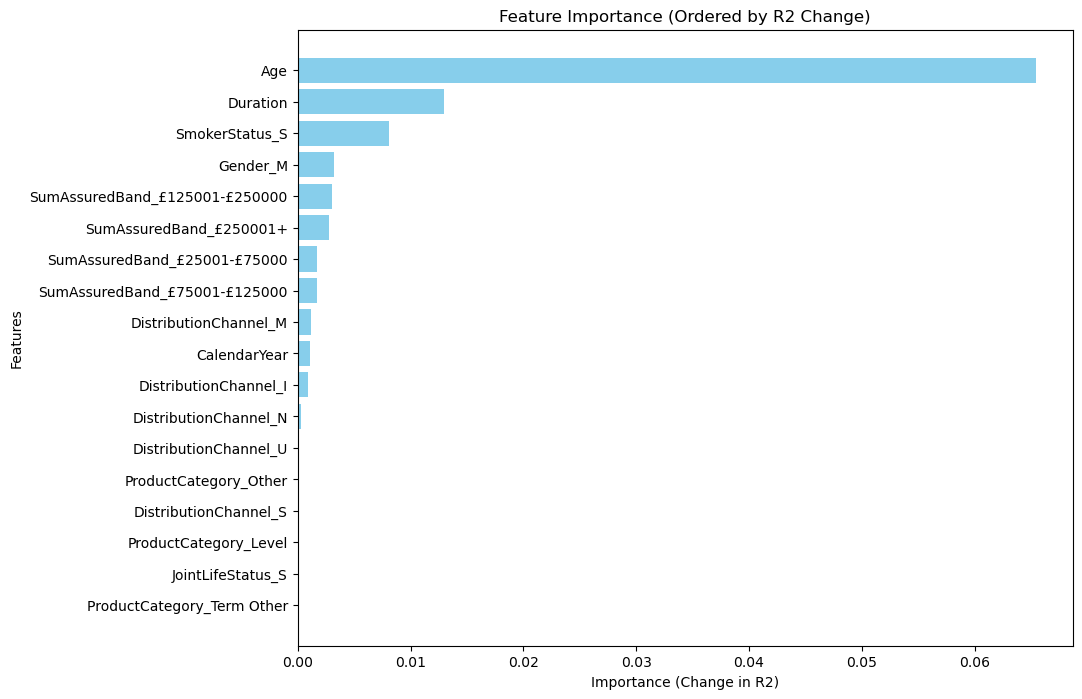

In [ ]:

def objective(trial, features, df, best_trial_params=None):
    best_trail_params_fix = other_best_params = {'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001}
    if best_trial_params is None:
        lr = best_trail_params_fix["lr"]
        weight_decay = best_trail_params_fix["weight_decay"]
        num_epochs = best_trail_params_fix["num_epochs"]
        lambda_l1 = best_trail_params_fix["lambda_l1"]
        age_cut = trial.suggest_int("age_cut", 20, 90)
        age_power = trial.suggest_float("age_power", 1.1, 5)
        age_multiplier = trial.suggest_int("age_multiplier", 0, 1)
        duration_power = trial.suggest_float("duration_power", -1, 3)
        duration_multiplier = trial.suggest_int("duration_multiplier", 0, 1)
    else:
        lr = best_trail_params_fix["lr"]
        weight_decay = best_trail_params_fix["weight_decay"]
        num_epochs = best_trail_params_fix["num_epochs"]
        lambda_l1 = best_trail_params_fix["lambda_l1"]
        age_cut = best_trial_params["age_cut"]
        age_power = best_trial_params["age_power"]
        age_multiplier = best_trial_params["age_multiplier"]
        duration_power = best_trial_params["duration_power"]
        duration_multiplier = best_trial_params["duration_multiplier"]

    pseudo_r2_scores = []

    for fold in range(1, 2):
        df["Age2"] = age_multiplier * np.maximum(df["Age"] - age_cut, 0) ** age_power
        df["Dur2"] = duration_multiplier * np.maximum(df["Duration"] + 1, 0) ** duration_power
        df["LivesExposure"] = df["LivesExposure"].clip(lower=1e-6)
        train_df = df[df["holdout"] == 0]
        test_df = df[~(df["holdout"] == 0)]

        train_lives_exposure = train_df["LivesExposure"]
        test_lives_exposure = test_df["LivesExposure"]

        if "Age2" not in features:
            features.append("Age2")
        if "Dur2" not in features:
            features.append("Dur2")

        X_train = train_df[features]
        y_train = train_df["IncurredClaims"]
        X_test = test_df[features]
        y_test = test_df["IncurredClaims"]

        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), columns=X_train.columns
        )
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

        X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(
            y_train.values.reshape(-1, 1), dtype=torch.float32
        )
        y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)
        lives_exposure_train_tensor = torch.tensor(
            train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )
        lives_exposure_test_tensor = torch.tensor(
            test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )

        # Initialize the initial Poisson model
        X_train_initial = X_train_scaled[
            ["Age", "Age2", "Gender_M", "Duration", "CalendarYear", "Dur2","SmokerStatus_S"]
        ]
        X_test_initial = X_test_scaled[
            ["Age", "Age2", "Gender_M", "Duration", "CalendarYear", "Dur2","SmokerStatus_S"]
        ]

        # Convert to tensors
        X_train_initial_tensor = torch.tensor(
            X_train_initial.values, dtype=torch.float32
        )
        X_test_initial_tensor = torch.tensor(X_test_initial.values, dtype=torch.float32)

        initial_model = PoissonModel(len(X_train_initial.columns))
        optimizer_initial = optim.Adam(
            initial_model.parameters(), lr=lr, weight_decay=weight_decay
        )

        # Train the initial Poisson model
        for epoch in range(num_epochs):
            optimizer_initial.zero_grad()
            poisson_outputs = initial_model(
                X_train_initial_tensor, lives_exposure_train_tensor
            )
            poisson_loss = weighted_poisson_loss(
                poisson_outputs, y_train_tensor, lives_exposure_train_tensor
            ) + l1_loss(initial_model, lambda_l1)
            poisson_loss.backward()
            optimizer_initial.step()

        # Get predictions from the initial model
        with torch.no_grad():
            poisson_outputs = initial_model(
                X_train_initial_tensor, lives_exposure_train_tensor
            )
            initial_predictions = poisson_outputs.detach()

        # Initialize and train the second model with all features except the ones used in the initial model
        features_except_initial = [
            f
            for f in features
           # if f not in ["Age", "Age2", "Gender_M", "Duration", "CalendarYear", "Dur2"]
        ]
        X_train_second = X_train_scaled[features_except_initial]
        X_test_second = X_test_scaled[features_except_initial]

        X_train_second_tensor = torch.tensor(X_train_second.values, dtype=torch.float32)
        X_test_second_tensor = torch.tensor(X_test_second.values, dtype=torch.float32)

        second_model = SecondPoissonModel(len(X_train_second.columns))
        optimizer_second = optim.Adam(
            second_model.parameters(), lr=lr, weight_decay=weight_decay
        )

        for epoch in range(num_epochs):
            optimizer_second.zero_grad()
            second_outputs = second_model(
                X_train_second_tensor, lives_exposure_train_tensor, initial_predictions
            )
            second_loss = weighted_poisson_loss(
                second_outputs, y_train_tensor, lives_exposure_train_tensor
            ) + l1_loss(second_model, lambda_l1)
            second_loss.backward()
            optimizer_second.step()

        # Evaluation for the second model
        second_model.eval()
        initial_model.eval()
        with torch.no_grad():
            poisson_outputs_test = initial_model(
                X_test_initial_tensor, lives_exposure_test_tensor
            )
            initial_predictions_test = poisson_outputs_test.detach()
            second_outputs = second_model(
                X_test_second_tensor,
                lives_exposure_test_tensor,
                initial_predictions_test,
            )
            second_loss = weighted_poisson_loss(
                second_outputs, y_test_tensor, lives_exposure_test_tensor
            ) + l1_loss(second_model, lambda_l1)

            y_pred = second_outputs
            y_test_tensor = y_test_tensor #+ 1e-25
            avg = torch.sum(
                 y_test_tensor 
            ) / torch.sum(lives_exposure_test_tensor)
            weighted_mean_target= avg * lives_exposure_test_tensor
            null_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log((y_test_tensor + 1e-25) / weighted_mean_target)
                    - (y_test_tensor - weighted_mean_target)
                )
            )
            model_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log((y_test_tensor + 1e-25) / y_pred)
                    - (y_test_tensor - y_pred)
                )
            )
            pseudo_r2 = 1 - (model_deviance / null_deviance)
            pseudo_r2_scores.append(pseudo_r2.item())

    mean_pseudo_r2 = np.mean(pseudo_r2_scores)
    print(f"Mean Pseudo_R2: {mean_pseudo_r2:.4f}")
    return mean_pseudo_r2

# Initial set of features
features = combined_df_encoded.columns.tolist()
features.remove("IncurredClaims")
features.remove("LivesExposure")
features.remove("Actual_deaths_lives")
features.remove("holdout")
features.remove("random_fold")
features.remove("CommencementYear")
features.remove("ExpectedClaims")
features.remove("Expected_deaths_lives")
features.remove("Expected_deaths")
exclude_features = []
features = [feature for feature in features if feature not in exclude_features]
df = combined_df_encoded.drop(columns=exclude_features, axis=1)

# Determine the best parameters using Optuna to maximize R2 score of deciles
study_Poisson = optuna.create_study(direction="maximize")
study_Poisson.optimize(
    lambda trial: objective(trial, features, df.sample(frac=0.8, random_state=1)),
    n_trials=25,
)

best_trial = study_Poisson.best_trial
best_trial_params = best_trial.params
best_trial_params["saturated_r2"] = best_trial.value
print(f"best_trial_params {best_trial_params}")

def evaluate_feature_importance(df, features, best_trial_params):
    feature_importances = {}

    one_hot_groups = {
        "ProductCategory": [
            "ProductCategory_Level",
            "ProductCategory_Other",
            "ProductCategory_Term Other",
        ],
        "Gender": ["Gender_M"],
        "SmokerStatus": ["SmokerStatus_S"],
        "DistributionChannel": [
            "DistributionChannel_I",
            "DistributionChannel_M",
            "DistributionChannel_N",
            "DistributionChannel_S",
            "DistributionChannel_U",
        ],
        "JointLifeStatus": ["JointLifeStatus_S"],
        "SumAssuredBand": [
            "SumAssuredBand_£125001-£250000",
            "SumAssuredBand_£250001+",
            "SumAssuredBand_£25001-£75000",
            "SumAssuredBand_£75001-£125000",
        ],
    }

    for feature in features:
        if feature == "Age2" or feature == "Dur2":
            continue

        df_copy = df.copy()

        group_found = False
        for group, group_features in one_hot_groups.items():
            if feature in group_features:
                group_found = True
                for gf in group_features:
                    if gf == feature:
                        df_copy[gf] = df_copy[feature].mode()[0]
                    else:
                        df_copy[gf] = 1 - df_copy[feature].mode()[0]
                break

        if not group_found:
            if feature not in ("Age", "Duration", "CalendarYear"):
                df_copy[feature] = df_copy[feature].mode()[0]
            else:
                df_copy[feature] = df_copy[feature].mean()

        study = optuna.create_study(direction="maximize")
        study.optimize(
            lambda trial: objective(trial, features, df_copy, best_trial_params),
            n_trials=1,
        )
        best_trial = study.best_trial
        print(f"trial params{study.best_params}")
        current_r2 = best_trial.value
        feature_importances[feature] = best_trial_params["saturated_r2"] - current_r2

    return feature_importances

feature_importances = evaluate_feature_importance(
    df.sample(frac=0.8, random_state=1),
    features,
    best_trial_params,
)

sorted_features = sorted(feature_importances, key=feature_importances.get, reverse=True)
sorted_importances = [feature_importances[feature] for feature in sorted_features]

plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.xlabel("Importance (Change in R2)")
plt.ylabel("Features")
plt.title("Feature Importance (Ordered by R2 Change)")
plt.gca().invert_yaxis()
plt.show()

In [ ]:

def objective(trial, features, df, best_trial_params=None):
    best_trail_params_fix = other_best_params = {'lr': 0.3026063071642011, 'weight_decay': 6.576812842536885e-06, 'num_epochs': 1316, 'lambda_l1': 0.0010042726424270001}
    if best_trial_params is None:
        lr = best_trail_params_fix["lr"]
        weight_decay = best_trail_params_fix["weight_decay"]
        num_epochs = best_trail_params_fix["num_epochs"]
        lambda_l1 = best_trail_params_fix["lambda_l1"]
        age_cut = trial.suggest_int("age_cut", 20, 90)
        age_power = trial.suggest_float("age_power", 1.1, 5)
        age_multiplier = trial.suggest_int("age_multiplier", 0, 1)
        duration_power = trial.suggest_float("duration_power", -1, 3)
        duration_multiplier = trial.suggest_int("duration_multiplier", 0, 1)
    else:
        lr = best_trail_params_fix["lr"]
        weight_decay = best_trail_params_fix["weight_decay"]
        num_epochs = best_trail_params_fix["num_epochs"]
        lambda_l1 = best_trail_params_fix["lambda_l1"]
        age_cut = best_trial_params["age_cut"]
        age_power = best_trial_params["age_power"]
        age_multiplier = best_trial_params["age_multiplier"]
        duration_power = best_trial_params["duration_power"]
        duration_multiplier = best_trial_params["duration_multiplier"]

    pseudo_r2_scores = []

    for fold in range(1, 2):
        df["Age2"] = age_multiplier * np.maximum(df["Age"] - age_cut, 0) ** age_power
        df["Dur2"] = duration_multiplier * np.maximum(df["Duration"] + 1, 0) ** duration_power
        df["LivesExposure"] = df["LivesExposure"].clip(lower=1e-6)
        train_df = df[df["holdout"] == 0]
        test_df = df[~(df["holdout"] == 0)]

        train_lives_exposure = train_df["LivesExposure"]
        test_lives_exposure = test_df["LivesExposure"]

        if "Age2" not in features:
            features.append("Age2")
        if "Dur2" not in features:
            features.append("Dur2")

        X_train = train_df[features]
        y_train = train_df["IncurredClaims"]
        X_test = test_df[features]
        y_test = test_df["IncurredClaims"]

        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), columns=X_train.columns
        )
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

        X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(
            y_train.values.reshape(-1, 1), dtype=torch.float32
        )
        y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)
        lives_exposure_train_tensor = torch.tensor(
            train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )
        lives_exposure_test_tensor = torch.tensor(
            test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )

        # Initialize the initial Poisson model
        X_train_initial = X_train_scaled[
            ["Age", "Age2", "Gender_M", "Duration", "CalendarYear", "Dur2","SmokerStatus_S"]
        ]
        X_test_initial = X_test_scaled[
            ["Age", "Age2", "Gender_M", "Duration", "CalendarYear", "Dur2","SmokerStatus_S"]
        ]

        # Convert to tensors
        X_train_initial_tensor = torch.tensor(
            X_train_initial.values, dtype=torch.float32
        )
        X_test_initial_tensor = torch.tensor(X_test_initial.values, dtype=torch.float32)

        initial_model = PoissonModel(len(X_train_initial.columns))
        optimizer_initial = optim.Adam(
            initial_model.parameters(), lr=lr, weight_decay=weight_decay
        )

        # Train the initial Poisson model
        for epoch in range(num_epochs):
            optimizer_initial.zero_grad()
            poisson_outputs = initial_model(
                X_train_initial_tensor, lives_exposure_train_tensor
            )
            poisson_loss = weighted_poisson_loss(
                poisson_outputs, y_train_tensor, lives_exposure_train_tensor
            ) + l1_loss(initial_model, lambda_l1)
            poisson_loss.backward()
            optimizer_initial.step()

        # Get predictions from the initial model
        with torch.no_grad():
            poisson_outputs = initial_model(
                X_train_initial_tensor, lives_exposure_train_tensor
            )
            initial_predictions = poisson_outputs.detach()

        # Initialize and train the second model with all features except the ones used in the initial model
        features_except_initial = [
            f
            for f in features
           # if f not in ["Age", "Age2", "Gender_M", "Duration", "CalendarYear", "Dur2"]
        ]
        X_train_second = X_train_scaled[features_except_initial]
        X_test_second = X_test_scaled[features_except_initial]

        X_train_second_tensor = torch.tensor(X_train_second.values, dtype=torch.float32)
        X_test_second_tensor = torch.tensor(X_test_second.values, dtype=torch.float32)

        second_model = SecondPoissonModel(len(X_train_second.columns))
        optimizer_second = optim.Adam(
            second_model.parameters(), lr=lr, weight_decay=weight_decay
        )

        for epoch in range(num_epochs):
            optimizer_second.zero_grad()
            second_outputs = second_model(
                X_train_second_tensor, lives_exposure_train_tensor, initial_predictions
            )
            second_loss = weighted_poisson_loss(
                second_outputs, y_train_tensor, lives_exposure_train_tensor
            ) + l1_loss(second_model, lambda_l1)
            second_loss.backward()
            optimizer_second.step()

        # Evaluation for the second model
        second_model.eval()
        initial_model.eval()
        with torch.no_grad():
            poisson_outputs_test = initial_model(
                X_test_initial_tensor, lives_exposure_test_tensor
            )
            initial_predictions_test = poisson_outputs_test.detach()
            second_outputs = second_model(
                X_test_second_tensor,
                lives_exposure_test_tensor,
                initial_predictions_test,
            )
            second_loss = weighted_poisson_loss(
                second_outputs, y_test_tensor, lives_exposure_test_tensor
            ) + l1_loss(second_model, lambda_l1)

            y_pred = second_outputs
            y_test_tensor = y_test_tensor #+ 1e-25
            avg = torch.sum(
                 y_test_tensor 
            ) / torch.sum(lives_exposure_test_tensor)
            weighted_mean_target= avg * lives_exposure_test_tensor
            null_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log((y_test_tensor + 1e-25) / weighted_mean_target)
                    - (y_test_tensor - weighted_mean_target)
                )
            )
            model_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log((y_test_tensor + 1e-25) / y_pred)
                    - (y_test_tensor - y_pred)
                )
            )
            pseudo_r2 = 1 - (model_deviance / null_deviance)
            pseudo_r2_scores.append(pseudo_r2.item())

    mean_pseudo_r2 = np.mean(pseudo_r2_scores)
    print(f"Mean Pseudo_R2: {mean_pseudo_r2:.4f}")
    return mean_pseudo_r2

# Initial set of features
features = combined_df_encoded.columns.tolist()
features.remove("IncurredClaims")
features.remove("LivesExposure")
features.remove("Actual_deaths_lives")
features.remove("holdout")
features.remove("random_fold")
features.remove("CommencementYear")
features.remove("ExpectedClaims")
features.remove("Expected_deaths_lives")
features.remove("Expected_deaths")
exclude_features = []
features = [feature for feature in features if feature not in exclude_features]
df = combined_df_encoded.drop(columns=exclude_features, axis=1)

# Determine the best parameters using Optuna to maximize R2 score of deciles
study_Poisson = optuna.create_study(direction="maximize")
study_Poisson.optimize(
    lambda trial: objective(trial, features, df.sample(frac=0.6, random_state=1)),
    n_trials=25,
)

best_trial = study_Poisson.best_trial
best_trial_params = best_trial.params
best_trial_params["saturated_r2"] = best_trial.value
print(f"best_trial_params {best_trial_params}")


[I 2025-09-28 13:58:27,976] A new study created in memory with name: no-name-7049aba6-531e-4a11-bb58-346df56533f2
[I 2025-09-28 13:59:29,418] Trial 0 finished with value: 0.24983137845993042 and parameters: {'age_cut': 58, 'age_power': 2.844996726111364, 'age_multiplier': 0, 'duration_power': 1.4979438312014457, 'duration_multiplier': 1}. Best is trial 0 with value: 0.24983137845993042.


Mean Pseudo_R2: 0.2498


[I 2025-09-28 14:00:31,198] Trial 1 finished with value: 0.24257302284240723 and parameters: {'age_cut': 32, 'age_power': 1.3847800691617298, 'age_multiplier': 1, 'duration_power': 1.3380924178043259, 'duration_multiplier': 1}. Best is trial 0 with value: 0.24983137845993042.


Mean Pseudo_R2: 0.2426


[W 2025-09-28 14:01:41,760] Trial 2 failed with parameters: {'age_cut': 79, 'age_power': 3.5067426675969893, 'age_multiplier': 1, 'duration_power': 0.45111687116065413, 'duration_multiplier': 0} because of the following error: The value nan is not acceptable.
[W 2025-09-28 14:01:41,761] Trial 2 failed with value nan.


Mean Pseudo_R2: nan


[I 2025-09-28 14:02:51,683] Trial 3 finished with value: 0.2451382875442505 and parameters: {'age_cut': 73, 'age_power': 3.766685790567964, 'age_multiplier': 0, 'duration_power': 1.3090199517833905, 'duration_multiplier': 0}. Best is trial 0 with value: 0.24983137845993042.


Mean Pseudo_R2: 0.2451


[I 2025-09-28 14:03:53,014] Trial 4 finished with value: 0.2317293882369995 and parameters: {'age_cut': 37, 'age_power': 4.554359398922156, 'age_multiplier': 1, 'duration_power': 2.31071986678827, 'duration_multiplier': 1}. Best is trial 0 with value: 0.24983137845993042.


Mean Pseudo_R2: 0.2317


[I 2025-09-28 14:04:54,580] Trial 5 finished with value: 0.24550211429595947 and parameters: {'age_cut': 28, 'age_power': 1.6745618902988189, 'age_multiplier': 0, 'duration_power': 1.1213111719374993, 'duration_multiplier': 0}. Best is trial 0 with value: 0.24983137845993042.


Mean Pseudo_R2: 0.2455


[I 2025-09-28 18:42:19,141] Trial 6 finished with value: 0.2519945502281189 and parameters: {'age_cut': 27, 'age_power': 3.777926137262252, 'age_multiplier': 0, 'duration_power': -0.7262365815414227, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2520


[I 2025-09-28 18:43:36,924] Trial 7 finished with value: 0.24316859245300293 and parameters: {'age_cut': 65, 'age_power': 3.305122334342573, 'age_multiplier': 1, 'duration_power': 0.47197271929383255, 'duration_multiplier': 0}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2432


[I 2025-09-28 18:44:55,958] Trial 8 finished with value: 0.24929767847061157 and parameters: {'age_cut': 73, 'age_power': 3.1008968166350246, 'age_multiplier': 0, 'duration_power': 2.9765378384789325, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2493


[I 2025-09-28 18:46:07,490] Trial 9 finished with value: 0.2516850233078003 and parameters: {'age_cut': 55, 'age_power': 1.4089715636503286, 'age_multiplier': 0, 'duration_power': -0.14014663923351245, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2517


[I 2025-09-28 18:47:15,096] Trial 10 finished with value: 0.24454432725906372 and parameters: {'age_cut': 66, 'age_power': 2.0285089079816867, 'age_multiplier': 1, 'duration_power': 0.05957115826304138, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2445


[I 2025-09-28 18:48:24,660] Trial 11 finished with value: 0.24546915292739868 and parameters: {'age_cut': 90, 'age_power': 4.8683042730013, 'age_multiplier': 0, 'duration_power': -0.9883684942939656, 'duration_multiplier': 0}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2455


[I 2025-09-28 18:49:32,341] Trial 12 finished with value: 0.25196224451065063 and parameters: {'age_cut': 44, 'age_power': 2.2956078953730152, 'age_multiplier': 0, 'duration_power': -0.836302701126947, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2520


[I 2025-09-28 18:50:41,070] Trial 13 finished with value: 0.2519873380661011 and parameters: {'age_cut': 20, 'age_power': 3.9507944270501585, 'age_multiplier': 0, 'duration_power': -0.8538688212627792, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2520


[I 2025-09-28 18:51:45,445] Trial 14 finished with value: 0.25191980600357056 and parameters: {'age_cut': 21, 'age_power': 3.9260040424763876, 'age_multiplier': 0, 'duration_power': -0.6046775269322116, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2519


[I 2025-09-28 18:52:51,515] Trial 15 finished with value: 0.24823987483978271 and parameters: {'age_cut': 23, 'age_power': 4.134793542215372, 'age_multiplier': 0, 'duration_power': -0.31951496064740104, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2482


[I 2025-09-28 18:53:56,033] Trial 16 finished with value: 0.2509986162185669 and parameters: {'age_cut': 44, 'age_power': 3.538291543004616, 'age_multiplier': 0, 'duration_power': 0.46597500484407295, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2510


[I 2025-09-28 18:54:57,604] Trial 17 finished with value: 0.25092822313308716 and parameters: {'age_cut': 38, 'age_power': 4.337576427931516, 'age_multiplier': 0, 'duration_power': 0.3066126298353067, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2509


[I 2025-09-28 18:56:00,804] Trial 18 finished with value: 0.24037045240402222 and parameters: {'age_cut': 20, 'age_power': 2.540250859032391, 'age_multiplier': 1, 'duration_power': -0.5290007916420931, 'duration_multiplier': 0}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2404


[I 2025-09-28 18:57:05,956] Trial 19 finished with value: 0.24936717748641968 and parameters: {'age_cut': 46, 'age_power': 4.93258267875819, 'age_multiplier': 0, 'duration_power': 0.7811661749432657, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2494


[I 2025-09-28 18:58:16,872] Trial 20 finished with value: 0.24797064065933228 and parameters: {'age_cut': 29, 'age_power': 3.5921132878752515, 'age_multiplier': 0, 'duration_power': -0.9705766304428722, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2480


[I 2025-09-28 18:59:24,910] Trial 21 finished with value: 0.22609734535217285 and parameters: {'age_cut': 35, 'age_power': 2.8045821899687438, 'age_multiplier': 1, 'duration_power': 1.897525774502673, 'duration_multiplier': 0}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2261


[I 2025-09-28 19:00:29,285] Trial 22 finished with value: 0.251973032951355 and parameters: {'age_cut': 47, 'age_power': 2.312221835702915, 'age_multiplier': 0, 'duration_power': -0.7525206685788897, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2520


[I 2025-09-28 19:01:33,738] Trial 23 finished with value: 0.2516705393791199 and parameters: {'age_cut': 49, 'age_power': 3.2405888184971263, 'age_multiplier': 0, 'duration_power': -0.49326584226845327, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2517


[I 2025-09-28 19:02:37,659] Trial 24 finished with value: 0.25068897008895874 and parameters: {'age_cut': 28, 'age_power': 1.9118278460370426, 'age_multiplier': 0, 'duration_power': -0.07167982391911931, 'duration_multiplier': 1}. Best is trial 6 with value: 0.2519945502281189.


Mean Pseudo_R2: 0.2507
best_trial_params {'age_cut': 27, 'age_power': 3.777926137262252, 'age_multiplier': 0, 'duration_power': -0.7262365815414227, 'duration_multiplier': 1, 'saturated_r2': 0.2519945502281189}


In [ ]:
%pip install optuna
import optuna

boosted Neural Net AIC: 3873338.69


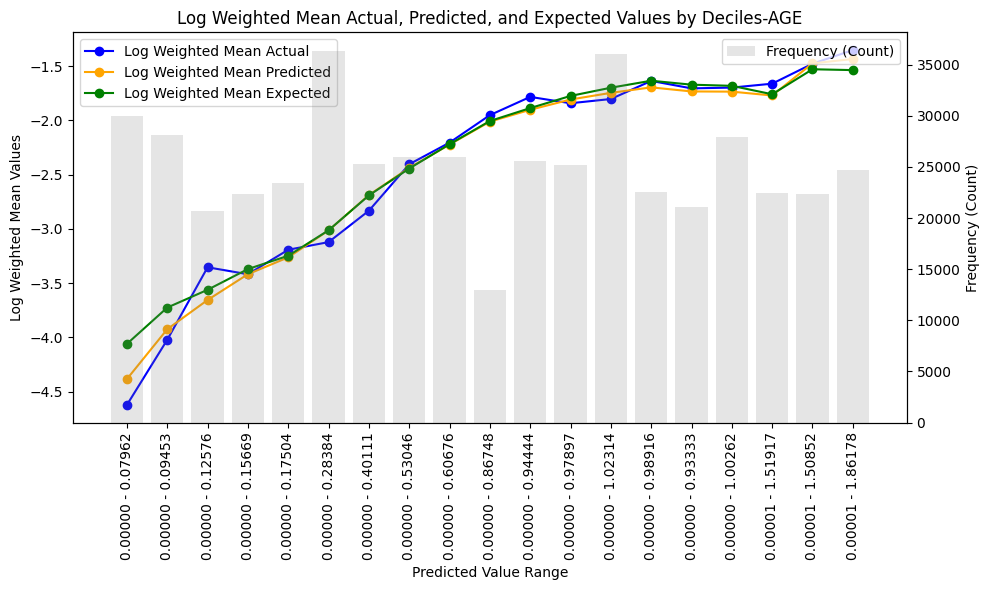

In [262]:
poisson_model.eval()
second_model.eval()
with torch.no_grad():
    second_outputs = second_model(
        X_test_second_tensor, lives_exposure_test_tensor, initial_predictions_test
    )

y_pred = second_outputs.numpy().flatten()
actual = y_test_tensor.numpy().flatten()
predicted = y_pred
weights = lives_exposure_test_tensor.numpy().flatten()
# Poisson log-likelihood (weighted by exposure)
log_likelihood = np.sum(
        weights * (actual * np.log(predicted ) - predicted - np.log(np.maximum(1, np.array([math.factorial(int(y)) for y in actual]))))
    )

    # Number of parameters in the neural net (sum of all trainable parameters)
num_params = sum(p.numel() for p in poisson_model.parameters() if p.requires_grad) + sum(p.numel() for p in second_model.parameters() if p.requires_grad)

    # AIC calculation: AIC = 2k - 2ln(L)
aic_boosted_nn = 2 * num_params - 2 * log_likelihood

print(f"boosted Neural Net AIC: {aic_boosted_nn:.2f}")
# Add ExpectedClaims from test_df if available
expected_claims = test_df["ExpectedClaims"].values.flatten() if "ExpectedClaims" in test_df.columns else np.zeros_like(actual)

# Create a DataFrame for lift analysis
df_lift = pd.DataFrame({
    "actual": actual,
    "predicted": predicted,
    "Age": age_test_tensor.numpy().flatten(),
    "expected": expected_claims,
    "weights": weights
})
df_lift = df_lift.sort_values(by="Age", ascending=False)
df_lift["decile"] = pd.qcut(df_lift["Age"], 20, labels=False)

def weighted_mean(group):
    return pd.Series({
        "weighted_actual": np.average(group["actual"], weights=group["weights"]),
        "weighted_predicted": np.average(group["predicted"], weights=group["weights"]),
        "weighted_expected": np.average(group["expected"], weights=group["weights"]),
        "range": f"{group['predicted'].min():.5f} - {group['predicted'].max():.5f}",
        "count": len(group)
    })

# Calculate weighted means and count for each decile
decile_summary = df_lift.groupby("decile").apply(weighted_mean)
decile_summary = decile_summary.iloc[1:].reset_index(drop=True)

# Take log of actual, predicted, and expected values
decile_summary["log_weighted_actual"] = np.log(decile_summary["weighted_actual"])
decile_summary["log_weighted_predicted"] = np.log(decile_summary["weighted_predicted"])
decile_summary["log_weighted_expected"] = np.log(decile_summary["weighted_expected"])

# Plot the weighted mean actual, predicted, and expected values for each decile
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(decile_summary["log_weighted_actual"], label="Log Weighted Mean Actual", color="blue", marker="o")
ax1.plot(decile_summary["log_weighted_predicted"], label="Log Weighted Mean Predicted", color="orange", marker="o")
ax1.plot(decile_summary["log_weighted_expected"], label="Log Weighted Mean Expected", color="green", marker="o")
ax1.set_xlabel("Predicted Value Range")
ax1.set_ylabel("Log Weighted Mean Values")
ax1.set_title("Log Weighted Mean Actual, Predicted, and Expected Values by Deciles-AGE")
ax1.set_xticks(ticks=range(len(decile_summary)))
ax1.set_xticklabels(decile_summary["range"], rotation=90)
ax1.legend(loc="upper left")

# Add frequency (count) as a bar plot on a secondary y-axis
ax2 = ax1.twinx()
ax2.bar(range(len(decile_summary)), decile_summary["count"], color="gray", alpha=0.2, label="Frequency (Count)")
ax2.set_ylabel("Frequency (Count)")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


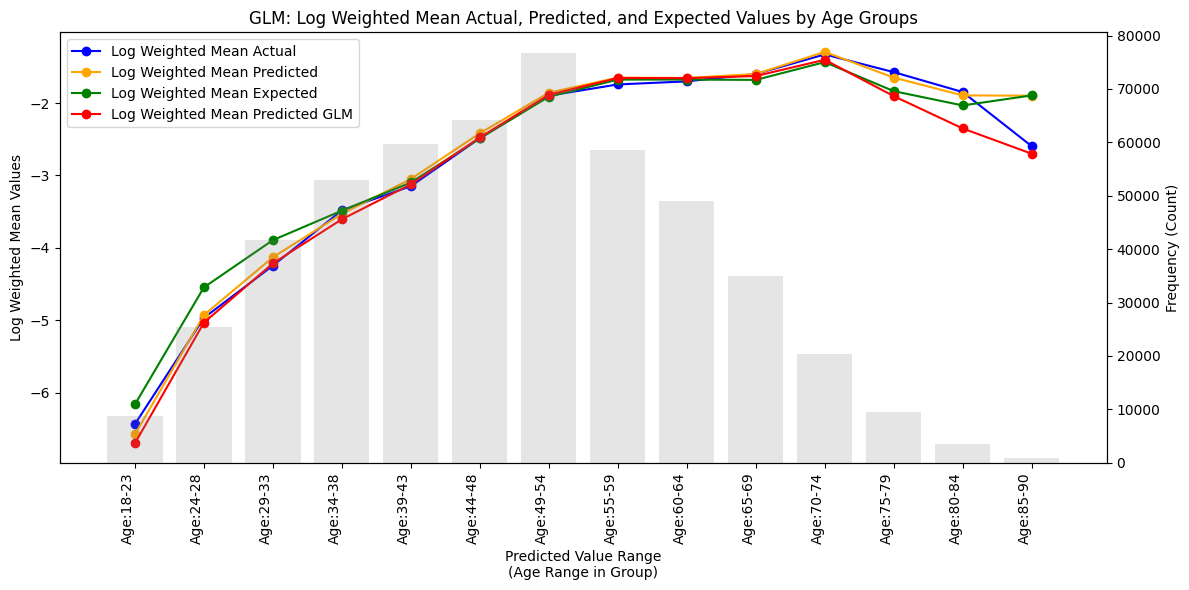

In [222]:
actual_glm = y_test.values
predicted_glm = y_pred_glm if 'y_pred_glm' in locals() else poisson_model_glm.predict(X_test, offset=np.log(test_df["LivesExposure"]))
weights_glm = test_df["LivesExposure"].values
expected_claims_glm = test_df["ExpectedClaims"].values if "ExpectedClaims" in test_df.columns else np.zeros_like(actual_glm)
ages_glm = test_df["Age"].values
poisson_model.eval()
second_model.eval()
with torch.no_grad():
    second_outputs = second_model(
        X_test_second_tensor, lives_exposure_test_tensor, initial_predictions_test
    )

y_pred = second_outputs.numpy().flatten()
#actual = y_test_tensor.numpy().flatten()
predicted = y_pred
weights = lives_exposure_test_tensor.numpy().flatten()

df_lift_glm = pd.DataFrame({
    "actual": actual_glm,
    "predicted_glm": predicted_glm,
    "Age": ages_glm,
    "expected_glm": expected_claims_glm,
    "weights_glm": weights_glm,
    "predicted_zip": predicted.flatten() if predicted.ndim > 1 else predicted,
    "weights": weights.flatten() if weights.ndim > 1 else weights
})

min_age_glm = int(df_lift_glm["Age"].min())
max_age_glm = int(df_lift_glm["Age"].max())
bins_glm = np.linspace(min_age_glm, max_age_glm, int((max_age_glm-min_age_glm+1)/2)*0+15)
labels_glm = range(len(bins_glm) - 1)
df_lift_glm["age_group"] = pd.cut(df_lift_glm["Age"], bins=bins_glm, labels=labels_glm, include_lowest=True)

def weighted_mean_glm(group):
    # Ensure all arrays are 1D for np.average
    actual = group["actual"].values.flatten()
    predicted_glm = group["predicted_glm"].values.flatten()
    predicted_zip = group["predicted_zip"].values.flatten()
    expected_glm = group["expected_glm"].values.flatten()
    weights_glm = group["weights_glm"].values.flatten()
    weights = group["weights"].values.flatten()
    return pd.Series({
        "weighted_actual": np.average(actual, weights=weights_glm),
        "weighted_predicted_glm": np.average(predicted_glm, weights=weights_glm),
        "weighted_predicted": np.average(predicted_zip, weights=weights),
        "weighted_expected": np.average(expected_glm, weights=weights_glm),
        "range": f"{predicted_glm.min():.5f} - {predicted_glm.max():.5f}",
        "count": len(group),
        "age_range": f"{group['Age'].min():.0f}-{group['Age'].max():.0f}"
    })

age_group_summary_glm = df_lift_glm.groupby("age_group").apply(weighted_mean_glm).reset_index(drop=True)
age_group_summary_glm["log_weighted_actual"] = np.log(age_group_summary_glm["weighted_actual"])
age_group_summary_glm["log_weighted_predicted"] = np.log(age_group_summary_glm["weighted_predicted"])
age_group_summary_glm["log_weighted_expected"] = np.log(age_group_summary_glm["weighted_expected"])
age_group_summary_glm["log_weighted_predicted_glm"] = np.log(age_group_summary_glm["weighted_predicted_glm"])

xtick_labels_glm = [
    f"\nAge:{a}" for r, a in zip(age_group_summary_glm["range"], age_group_summary_glm["age_range"])
]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(age_group_summary_glm["log_weighted_actual"], label="Log Weighted Mean Actual", color="blue", marker="o")
ax1.plot(age_group_summary_glm["log_weighted_predicted"], label="Log Weighted Mean Predicted", color="orange", marker="o")
ax1.plot(age_group_summary_glm["log_weighted_expected"], label="Log Weighted Mean Expected", color="green", marker="o")
ax1.plot(age_group_summary_glm["log_weighted_predicted_glm"], label="Log Weighted Mean Predicted GLM", color="red", marker="o")
ax1.set_xlabel("Predicted Value Range\n(Age Range in Group)")
ax1.set_ylabel("Log Weighted Mean Values")
ax1.set_title("GLM: Log Weighted Mean Actual, Predicted, and Expected Values by Age Groups")
ax1.set_xticks(ticks=range(len(age_group_summary_glm)))
ax1.set_xticklabels(xtick_labels_glm, rotation=90, ha="right")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.bar(range(len(age_group_summary_glm)), age_group_summary_glm["count"], color="gray", alpha=0.2, label="Frequency (Count)")
ax2.set_ylabel("Frequency (Count)")

plt.tight_layout()
plt.show()

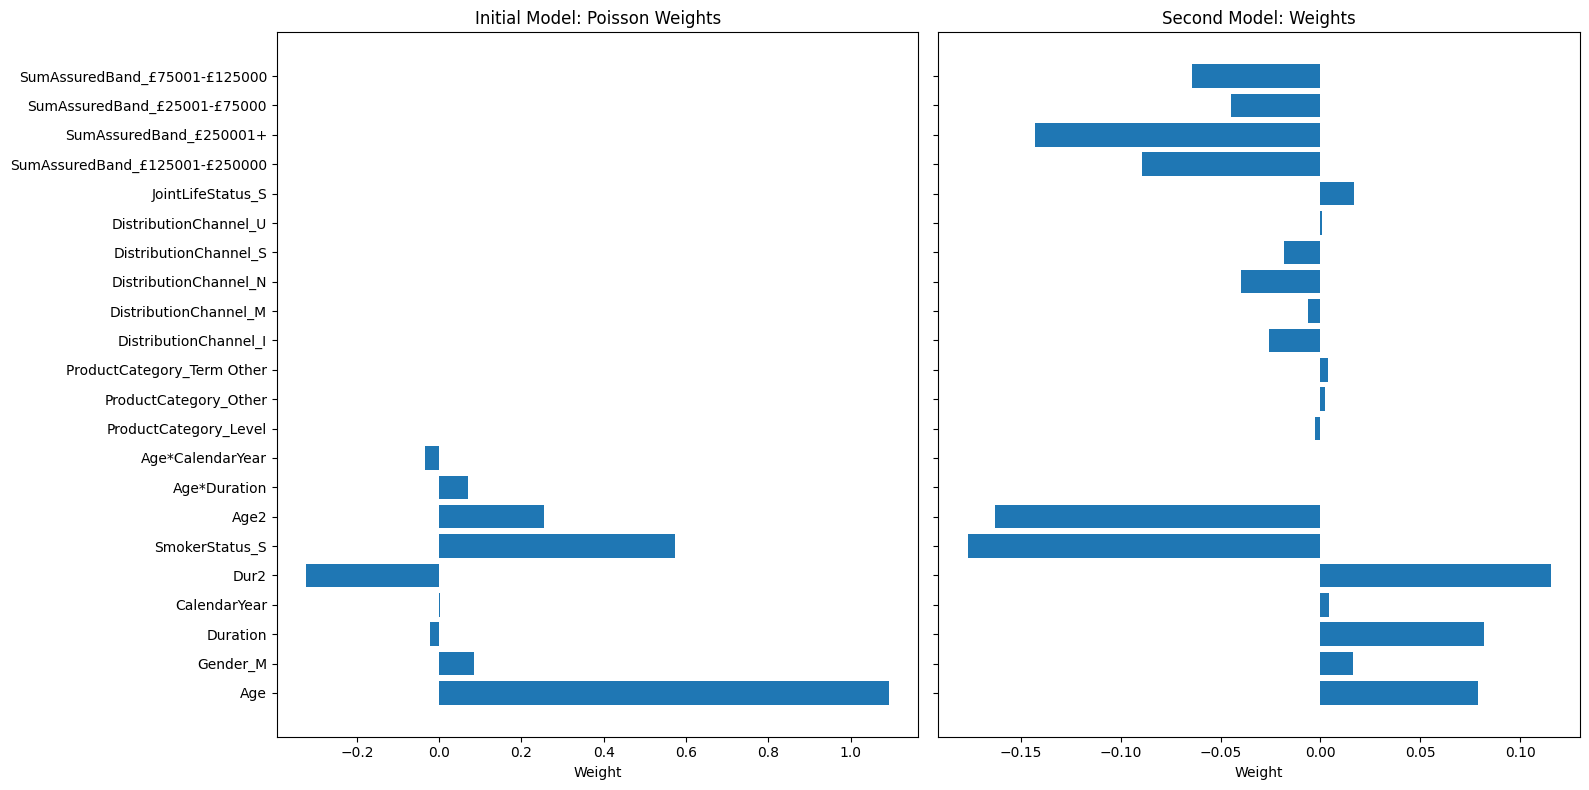

In [97]:
# For initial_model (ZIP): show both Poisson and Zero-Inflation weights
init_weights = poisson_model.state_dict()
init_fc2_weights = init_weights["fc.weight"].detach().cpu().numpy().flatten()
#init_fc_zero_weights = init_weights["fc_zero_inflation.weight"].detach().cpu().numpy().flatten()

init_feature_names = list(X_train_initial.columns) + ["Age*Duration", "Age*CalendarYear"]

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
axes[0].barh(init_feature_names, init_fc2_weights)
axes[0].set_title("Initial Model: Poisson Weights")
axes[0].set_xlabel("Weight")
sec_weights = second_model.state_dict()
sec_fc_weights = sec_weights["fc.weight"].detach().cpu().numpy().flatten()
sec_feature_names = features_except_age_sex
axes[1].barh(sec_feature_names, sec_fc_weights)
axes[1].set_title("Second Model: Weights")
axes[1].set_xlabel("Weight")

plt.tight_layout()
plt.show()

